# Preamble

In [1]:
import sys
import numpy as np
from matplotlib import pyplot as plt 
#from ultralight_boson import ub.UltralightBoson
from superrad import ultralight_boson as ub
from scipy.optimize import fsolve
import pandas as pd
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.integrate import trapz
from scipy.integrate import quad

#import my_units as myu
from utils.my_units import *

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcdefaults()
from matplotlib import font_manager
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import colors
rcParams['mathtext.rm'] = 'Times New Roman' 
rcParams['text.usetex'] = True
rcParams['font.family'] = 'times' #'sans-serif'
font_manager.findfont('serif', rebuild_if_missing=True)
fontsize = 14
rcParams.update({'font.size':fontsize})

# Define analytic functions

In [7]:
def delta_as_fn(a_star, alpha):
    return (a_star - 4*alpha/(1+4*alpha**2))*np.heaviside(a_star - 4*alpha/(1+4*alpha**2), 0)

def tau_GW_fn(alpha, mu, delta_as):
    return 1/(60*alpha**10*mu*delta_as)

def fdot_max_fn(alpha, mu, delta_as):
    return (75/4/np.pi*alpha**13*mu**2*(delta_as)**2)

In [8]:
### Analytic formulas
def fdot_fn(alpha, Mc, Mbh):
    return (75/4/np.pi*alpha**13*(Mc*MSolar)**2/GN**2/(Mbh*MSolar)**4)*Second**2

In [9]:
### Approximate value of the min and max alpha (here Delta a_star is taken to be = a_star, which is okay for small alpha)

def alpha_min_fn(mu, a_star, f_dot_obs):
    return (4*np.pi/75* f_dot_obs / (mu**2*a_star**2))**(1/13) 

def alpha_max_fn(mu, a_star, tau_cut):
    return 1/(tau_cut*60*mu*a_star)**(1/10)

In [10]:
def EM_lum_fit(alpha):
    return (0.131*alpha-0.188*alpha**2)

def EM_lum(eps, alpha, Mc, MBH):
    return eps**2*(0.131*alpha-0.188*alpha**2)*Mc/(GN*MBH)

def EM_lum_approx(eps, alpha, a_star):
    return eps**2*(0.13*alpha-0.188*alpha**2)*delta_as_fn(a_star, alpha)*alpha*(1-alpha**2/2)/(GN)

In [11]:
### GW strain from neutron star spin down, from 2109.09255, taken from 1209.0667

def hsp_fn(fGW, fdotGW, d):
    return 4e-28*(8/d)*np.sqrt(600/fGW)*np.sqrt(fdotGW/(1e-14))

In [12]:
### Electric field
def Efield_fn_approx(epsilon, alpha, mu, a_star, t=0):
    
    Gamma_sr = 4*a_star*alpha**6*mu
    Nocc = delta_as_fn(a_star, alpha)*alpha**2/(GN*mu**2)
    t_sat = 1/Gamma_sr*np.log(Nocc)
    
    if ((t < t_sat) & (t>0)):
        return 1/np.sqrt(np.pi)*epsilon*alpha**(3/2)*mu**2*np.exp(t*Gamma_sr/2)
    else:
        return 1/np.sqrt(np.pi)*epsilon*alpha**(5/2)*np.sqrt(delta_as_fn(a_star, alpha))*mu/np.sqrt(GN)

### Pair production rate
def Gamma_pair_fn_approx(epsilon, mu, alpha, a_star, t=0):
    
    E_field = Efield_fn_approx(epsilon, alpha, mu, a_star, t)
    exp_factor = 4*MElectron**6*mu**2/((ElectronCharge*E_field)**4)
    
    return AlphaEM/(2*np.pi)*ElectronCharge*E_field/MElectron*np.exp(-exp_factor)

In [13]:
### Electric field
def Efield_fn(epsilon, alpha, mu, Nocc):
    return 1/np.sqrt(np.pi)*epsilon*alpha**(3/2)*mu**2*np.sqrt(Nocc)

### Pair production rate
def Gamma_pair_fn(epsilon, mu, alpha, Nocc):
    
    E_field = Efield_fn(epsilon, alpha, mu, Nocc)
    exp_factor = 4*MElectron**6*mu**2/((ElectronCharge*E_field)**4)
    
    return AlphaEM/(2*np.pi)*ElectronCharge*E_field/MElectron*np.exp(-exp_factor)

def tplasma_fn(epsilon, mu, alpha, Nocc):
    
    ne = alpha*mu*Efield_fn(epsilon, alpha, mu, Nocc)/ElectronCharge   
    
    if Gamma_pair_fn(epsilon, mu, alpha, Nocc) > 0:
        return 1/(2*Gamma_pair_fn(epsilon, mu, alpha, Nocc))*np.log(ne/(alpha*mu)**3)
    else:
        return np.nan

# Pulsars with the same frequency

In [3]:
df_pulsar_all = pd.read_csv('data/all_pulsars.csv', index_col=0)
df_pulsar_all = df_pulsar_all.iloc[: , :-1]
df_pulsar_all.columns

print(len(df_pulsar_all))
print(len(df_pulsar_all))
df_pulsar_all = df_pulsar_all[(~df_pulsar_all['F0'].isna())] ### Remove pulsars with no F0 measurement
len(df_pulsar_all)

3342
3342


3308

## Find frequency multiples

In [4]:
start_f = 50
#df_pulsar_all_sub = df_pulsar_all[((df_pulsar_all['F0'].to_numpy() > start_f) & (df_pulsar_all['BINARY'].isna()) & ((df_pulsar_all['F1'].isna()) | (df_pulsar_all['F1'].to_numpy() > 0)))]
df_pulsar_all_sub = df_pulsar_all[((df_pulsar_all['F0'].to_numpy() > start_f) & ((df_pulsar_all['F1'].isna()) | (df_pulsar_all['F1'].to_numpy() > 0)) & (~df_pulsar_all['DIST'].isna()))]
df_pulsar_all_sub.sort_values(by='F0', inplace=True)
len(df_pulsar_all_sub)

<ipython-input-4-64650c577c81>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pulsar_all_sub.sort_values(by='F0', inplace=True)


229

In [5]:
min(df_pulsar_all_sub['F0'].to_numpy()), max(df_pulsar_all_sub['F0'].to_numpy())

(53.69521999999999, 669.933583)

In [6]:
### PSR TYPE of the pulsar that are in a pair
type_list = np.array([['J0418+6635', 'HE'], ['J0418+6635', 'HE'], ['J1342+2822F', 'BINARY'], ['J1518+0204F', 'BINARY'], ['J1624-39', 'HE'], ['J2045-68', 'HE'], ['J1727-1609', 'NRAD'], ['J2129+1210I', 'BINARY?'], ['J1342+2822F', 'BINARY'] ])

In [7]:
### Remove binaries that are in a pair
#binary_list = np.array([['J1342+2822F', 'BINARY'], ['J1518+0204F', 'BINARY'] ])

#for i in range(len(binary_list)):
#    df_pulsar_all_sub.drop(df_pulsar_all_sub[df_pulsar_all_sub['NAME'] == binary_list[i, 0]].index, inplace = True)

In [8]:
freq_list = df_pulsar_all_sub['F0'].to_numpy()
triplet_ind_list = []

for i, f in tqdm(enumerate(freq_list)):
    
    pairs_ind = np.where(np.abs(f - freq_list)/f < 0.001)[0]

    if len(pairs_ind)>2:
        triplet_ind_list.append(pairs_ind.tolist())
        print(len(pairs_ind)-1, ' pairs found for f = ', f, '  i = ', i)

### Remove double counting
triplet_ind_list = list(set( tuple(x) for x in triplet_ind_list))
triplet_ind_list = np.array(list(set( tuple(x) for x in triplet_ind_list)))
print(len(triplet_ind_list))    

229it [00:00, 60057.25it/s]

2  pairs found for f =  227.42779199999998   i =  113
2  pairs found for f =  311.493418   i =  160
2  pairs found for f =  311.52648   i =  161
2  pairs found for f =  311.52648   i =  162
2  pairs found for f =  337.837838   i =  177
2  pairs found for f =  337.837838   i =  178
2  pairs found for f =  337.974855   i =  179
3


In [9]:
for j in range(3):
    for i in range(3):
        print(np.abs(freq_list[triplet_ind_list][j][i] - freq_list[triplet_ind_list][j])/freq_list[triplet_ind_list][j][2]/0.001)
        #print(np.abs(freq_list[triplet_ind_list][0][i] - freq_list[triplet_ind_list][0])/freq_list[triplet_ind_list][0][2]/0.001)

[0.         0.68135561 1.36363835]
[0.68135561 0.         0.68228274]
[1.36363835 0.68228274 0.        ]
[0.         0.10612902 0.10612902]
[0.10612902 0.         0.        ]
[0.10612902 0.         0.        ]
[0.        0.        0.4054059]
[0.        0.        0.4054059]
[0.4054059 0.4054059 0.       ]


In [10]:
freq_list = df_pulsar_all_sub['F0'].to_numpy()
pairs_ind_list = []

for i, f in tqdm(enumerate(freq_list)):
    
    pairs_ind = np.where(np.abs(f - freq_list)/f < 0.001)[0]

    if ((len(pairs_ind)>1) & (len(pairs_ind)<=2)) :
        pairs_ind_list.append(pairs_ind.tolist())
        print(len(pairs_ind)-1, ' pairs found for f = ', f, '  i = ', i)

### Remove double counting
pairs_ind_list = list(set( tuple(x) for x in pairs_ind_list))
pairs_ind_list = np.array(list(set( tuple(x) for x in pairs_ind_list)))
print(len(pairs_ind_list))    

229it [00:00, 13875.58it/s]

1  pairs found for f =  103.263527   i =  18
1  pairs found for f =  103.305785   i =  19
1  pairs found for f =  128.205128   i =  31
1  pairs found for f =  128.205128   i =  32
1  pairs found for f =  131.233596   i =  33
1  pairs found for f =  131.356873   i =  34
1  pairs found for f =  141.043724   i =  38
1  pairs found for f =  141.145053   i =  39
1  pairs found for f =  179.600927   i =  64
1  pairs found for f =  179.700978   i =  65
1  pairs found for f =  184.501845   i =  72
1  pairs found for f =  184.614253   i =  73
1  pairs found for f =  195.3125   i =  79
1  pairs found for f =  195.32356299999998   i =  80
1  pairs found for f =  196.463654   i =  82
1  pairs found for f =  196.58299399999999   i =  83
1  pairs found for f =  207.747779   i =  91
1  pairs found for f =  207.89296299999998   i =  92
1  pairs found for f =  219.565606   i =  105
1  pairs found for f =  219.56788999999998   i =  106
1  pairs found for f =  225.225225   i =  109
1  pairs found for f =

In [22]:
df_pulsar_all_sub.columns

Index(['NAME', 'RAJ', 'DECJ', 'PMRA', 'PMDEC', 'P0', 'P1', 'F0', 'F1', 'F2',
       'S400', 'S1400', 'S2000', 'BINARY', 'DIST', 'DIST_DM', 'R_LUM',
       'R_LUM14', 'AGE'],
      dtype='object')

In [23]:
df_pulsar_all_sub.iloc[pairs_ind_list[1]]['F1'].to_numpy()[0]

nan

In [70]:
for i, ind in enumerate(pairs_ind_list):
    if ((df_pulsar_all_sub.iloc[ind]['F1'].to_numpy()[0]>0) or (df_pulsar_all_sub.iloc[ind]['F1'].to_numpy()[1]>0)):
    #if ((df_pulsar_all_sub.iloc[ind]['F1'].to_numpy()[0]>0) | (df_pulsar_all_sub.iloc[ind]['F1'].to_numpy()[1])):
        print(df_pulsar_all_sub.iloc[ind][['NAME','F0','F1']])

             NAME          F0            F1
#                                          
16      B0021-72G  247.501525  2.583000e-15
2061  J1824-2452J  247.586036           NaN
              NAME          F0            F1
#                                           
11    J0024-7204ad  267.379679           NaN
1839   J1801-0857C  267.472675  4.573000e-15
            NAME          F0            F1
#                                         
34   J0024-7204Z  219.565606  2.190000e-16
213  J0514-4002D  219.567890           NaN
            NAME          F0            F1
#                                         
1744  J1748-3009  103.263527  3.817000e-16
440   J0921-5202  103.305785           NaN
          NAME          F0            F1
#                                       
21   B0021-72M  271.987229  2.842000e-15
83  J0125-2327  272.045181           NaN
            NAME          F0            F1
#                                         
27   J0024-7204S  353.306209  1.505000e-14
752    

In [20]:
df_pulsar_all_sub.iloc[pairs_ind_list.flatten()][['F1', 'BINARY']]  

,F1,BINARY
#,,
2056,NaN,NaN
1676,NaN,BT
11,NaN,BT
1839,4.573000e-15,NaN
732,NaN,BT
8,NaN,NaN
790,NaN,NaN
1738,NaN,BT
2408,NaN,NaN


In [864]:
df_pulsar_all_sub.iloc[triplet_ind_list.flatten()][['F1', 'BINARY']]

,F1,BINARY
#,,
826,NaN,NaN
1871,NaN,NaN
2035,NaN,NaN
221,NaN,BT
1212,NaN,NaN
3153,NaN,NaN
17,1.775000e-16,DD
1235,NaN,BT
2875,NaN,NaN


## Superradiance

In [11]:
bc = ub.UltralightBoson(spin=1, model="relativistic") 

In [12]:
pair_ind = np.array([pairs_ind_list]).flatten()
triplet_ind = np.array([triplet_ind_list]).flatten()
pair_ind = pair_ind[~np.isin(pair_ind, triplet_ind)]

### Frequency triplets

In [13]:
df_pulsar_all_sub.iloc[triplet_ind]['F0']

#
826     227.272727
1871    227.427792
2035    227.583068
17      311.493418
1235    311.526480
2875    311.526480
1212    337.837838
3153    337.837838
221     337.974855
Name: F0, dtype: float64

In [29]:
### Determine the range of alpha allowed for each pulsar
mbh_min, mbh_max = 3*MSolar, 100*MSolar
abh0 = 0.5
alpha_points_sol = 100
t_cutoff = 1e3*Year
alpha_points = 50

mu_list_tr = 2*np.pi*df_pulsar_all_sub.iloc[triplet_ind]['F0'].to_numpy()*Hz

alpha_list_tr = np.nan+np.zeros((len(triplet_ind), alpha_points)) #np.nan+np.zeros((len(triplet_ind), alpha_points))

for i in range(len(triplet_ind)):
    
    mu = mu_list_tr[i]
    alpha_cutoff = 1.5*np.power(17*mu*0.1*t_cutoff, -1/10) ## take a factor of 1.5 greater than the estimated max alpha value
    alpha_min = GN*mu*mbh_min
    alpha_max = min(alpha_cutoff, GN*mu*mbh_max)
    
    if alpha_cutoff > GN*mu*mbh_max:
        print('yes ', mu)
    
    if(alpha_max > alpha_min):
        
        alpha_list_temp = np.logspace(np.log10(alpha_min), np.log10(alpha_max), alpha_points_sol)
        gw_time_list_temp = np.nan+np.zeros(alpha_points_sol)
        
        for i_a, alpha in enumerate(alpha_list_temp):

            mbh = alpha/(mu*GN)/MSolar
            try:
                wf = bc.make_waveform(mbh, abh0, alpha, units="physical+alpha")
            except ValueError:
                break 

            if wf.azimuthal_num()==1:
                gw_time_list_temp[i_a] = wf.gw_time()*Second
               
        alpha_cutoff = 10**np.interp(0, np.flipud(np.log10(gw_time_list_temp/t_cutoff)), np.flipud(np.log10(alpha_list_temp)), left=np.nan, right=np.nan)
        alpha_list_tr[i] = np.logspace(np.log10(alpha_min), np.log10(alpha_cutoff), alpha_points) #[alpha_min, alpha_cutoff] #

In [24]:
min(alpha_list_tr[:, -1]), max(alpha_list_tr[:, -1])

(0.03430407281532435, 0.035782293766343905)

In [33]:
t_age = 1e3*Year

rel_deltaf_list_tr = np.nan+np.zeros((len(triplet_ind), alpha_points))
strain_list_tr = np.nan+np.zeros((len(triplet_ind), alpha_points))
fdot_list_tr = np.nan+np.zeros((len(triplet_ind), alpha_points))
eps_min_tr = np.nan+np.zeros((len(triplet_ind), alpha_points))
eps_max_tr = np.nan+np.zeros((len(triplet_ind), alpha_points))
eps_min_lum_tr = np.nan+np.zeros((len(triplet_ind), alpha_points))
lum_cutoff = 1e30*erg/Second

for i, p_index in enumerate(triplet_ind):

    mu = mu_list_tr[i]                       
    distance = df_pulsar_all_sub.iloc[p_index]['DIST'] 
    
    for i_a, alpha in enumerate(alpha_list_tr[i]):

        mbh = alpha_list_tr[i, 0]/(mu*GN)/MSolar

        try:
            wf = bc.make_waveform(mbh, abh0, alpha, units="physical+alpha")
        except ValueError:
            break 

        if wf.azimuthal_num()==1:
            
            Mc_sat = wf.mass_cloud(0)
            Nocc = Mc_sat*MSolar/mu

            rel_deltaf_list_tr[i][i_a] = (wf.freq_gw(t_age/Second)-wf.freq_gw(0))/wf.freq_gw(0) ### How much it has spun up
            strain_list_tr[i][i_a] = wf.strain_char(t_age/Second, dObs=distance*0.001)    
            fdot_list_tr[i][i_a] = wf.freqdot_gw(t_age/Second)

            ### Compute the minimum value of epsilon allowed when the cloud reaches saturation
            func = lambda log_eps : Gamma_pair_fn(10**log_eps, mu, alpha, Nocc)/(alpha*mu) - 1  

            eps_start = 1/(ElectronCharge*alpha**(3/2))*(MElectron/mu)**(3/2)/np.sqrt(Nocc)
            eps_min_tr[i][i_a] = 10**fsolve(func, np.log10(eps_start))[0]   #res_array[i_event][i_mu, 2] = 10**fsolve(func, np.log10(eps_start))[0]  

            eps_max_tr[i][i_a] = np.sqrt(wf.power_gw(t_age/Second)*Watt/EM_lum(1, alpha, wf.mass_cloud(t_age/Second), mbh))
            eps_min_lum_tr[i][i_a] = np.sqrt(lum_cutoff/EM_lum(1, alpha, wf.mass_cloud(t_age/Second), mbh))
            #print(EM_lum(eps_min_tr[i][i_a], alpha, wf.mass_cloud(t_cutoff/Second), mbh)/(erg/Second))

<ipython-input-33-39319f86a860>:35: RuntimeWarning: overflow encountered in power
  func = lambda log_eps : Gamma_pair_fn(10**log_eps, mu, alpha, Nocc)/(alpha*mu) - 1


In [34]:
t_age = 1e6*Year

strain_list_tr_1 = np.nan+np.zeros((len(triplet_ind), alpha_points))
rel_deltaf_list_tr_1 = np.nan+np.zeros((len(triplet_ind), alpha_points))
eps_min_tr_1 = np.nan+np.zeros((len(triplet_ind), alpha_points))
eps_max_tr_1 = np.nan+np.zeros((len(triplet_ind), alpha_points))
eps_min_lum_tr_1 = np.nan+np.zeros((len(triplet_ind), alpha_points))

for i, p_index in enumerate(triplet_ind):

    mu = mu_list_tr[i]                       
    distance = df_pulsar_all_sub.iloc[p_index]['DIST'] 
    
    for i_a, alpha in enumerate(alpha_list_tr[i]):

        mbh = alpha_list_tr[i, 0]/(mu*GN)/MSolar

        try:
            wf = bc.make_waveform(mbh, abh0, alpha, units="physical+alpha")
        except ValueError:
            break 

        if wf.azimuthal_num()==1:
            
            Mc_sat = wf.mass_cloud(0)
            Nocc = Mc_sat*MSolar/mu

            rel_deltaf_list_tr_1[i][i_a] = (wf.freq_gw(t_age/Second)-wf.freq_gw(0))/wf.freq_gw(0) ### How much it has spun up
            strain_list_tr_1[i][i_a] = wf.strain_char(t_age/Second, dObs=distance*0.001)    

            ### Compute the minimum value of epsilon allowed when the cloud reaches saturation
            func = lambda log_eps : Gamma_pair_fn(10**log_eps, mu, alpha, Nocc)/(alpha*mu) - 1  

            eps_start = 1/(ElectronCharge*alpha**(3/2))*(MElectron/mu)**(3/2)/np.sqrt(Nocc)
            eps_min_tr_1[i][i_a] = 10**fsolve(func, np.log10(eps_start))[0]   #res_array[i_event][i_mu, 2] = 10**fsolve(func, np.log10(eps_start))[0]  

            eps_max_tr_1[i][i_a] = np.sqrt(wf.power_gw(t_age/Second)*Watt/EM_lum(1, alpha, wf.mass_cloud(t_age/Second), mbh))
            eps_min_lum_tr_1[i][i_a] = np.sqrt(lum_cutoff/EM_lum(1, alpha, wf.mass_cloud(t_age/Second), mbh))
            #print(EM_lum(eps_min_tr[i][i_a], alpha, wf.mass_cloud(t_cutoff/Second), mbh)/(erg/Second))

<ipython-input-34-d7c738c38955>:32: RuntimeWarning: overflow encountered in power
  func = lambda log_eps : Gamma_pair_fn(10**log_eps, mu, alpha, Nocc)/(alpha*mu) - 1


### Frequency doubles

In [16]:
np.sort(df_pulsar_all_sub.iloc[pair_ind]['F0'])*2

array([ 206.527054,  206.61157 ,  256.410256,  256.410256,  262.467192,
        262.713746,  282.087448,  282.290106,  359.201854,  359.401956,
        369.00369 ,  369.228506,  390.625   ,  390.647126,  392.927308,
        393.165988,  415.495558,  415.785926,  439.131212,  439.13578 ,
        450.45045 ,  450.45045 ,  475.317132,  475.603898,  495.00305 ,
        495.172072,  534.759358,  534.94535 ,  543.974458,  544.090362,
        560.22409 ,  560.291576,  666.666666,  666.831152,  687.285224,
        687.285224,  706.612418,  706.71378 ,  738.00738 ,  738.00738 ,
        754.716982,  754.716982,  767.556242,  768.276334,  910.00091 ,
        910.474356, 1086.956522, 1086.956522])

In [17]:
### Determine the range of alpha allowed for each pulsar
mbh_min, mbh_max = 3*MSolar, 100*MSolar
abh0 = 0.5
alpha_points_sol = 100
t_cutoff = 1e3*Year
alpha_points = 50

mu_list_pr = 2*np.pi*df_pulsar_all_sub.iloc[pair_ind]['F0'].to_numpy()*Hz

alpha_list_pr = np.nan+np.zeros((len(pair_ind), alpha_points)) #np.nan+np.zeros((len(pair_ind), alpha_points))

for i in range(len(pair_ind)):
    
    mu = mu_list_pr[i]
    alpha_cutoff = 1.5*np.power(17*mu*0.1*t_cutoff, -1/10) ## take a factor of 1.5 greater than the estimated max alpha value
    alpha_min = GN*mu*mbh_min
    alpha_max = min(alpha_cutoff, GN*mu*mbh_max)
    
    if(alpha_max > alpha_min):
        
        alpha_list_temp = np.logspace(np.log10(alpha_min), np.log10(alpha_max), alpha_points_sol)
        gw_time_list_temp = np.nan+np.zeros(alpha_points_sol)
        
        for i_a, alpha in enumerate(alpha_list_temp):

            mbh = alpha/(mu*GN)/MSolar
            try:
                wf = bc.make_waveform(mbh, abh0, alpha, units="physical+alpha")
            except ValueError:
                break 

            if wf.azimuthal_num()==1:
                gw_time_list_temp[i_a] = wf.gw_time()*Second
               
        alpha_cutoff = 10**np.interp(0, np.flipud(np.log10(gw_time_list_temp/t_cutoff)), np.flipud(np.log10(alpha_list_temp)), left=np.nan, right=np.nan)
        alpha_list_pr[i] = np.logspace(np.log10(alpha_min), np.log10(alpha_cutoff), alpha_points) #[alpha_min, alpha_cutoff] #

In [21]:
alpha_list_pr[-5:,:]

array([[0.01304698, 0.01333222, 0.01362369, 0.01392153, 0.01422589,
        0.0145369 , 0.01485471, 0.01517946, 0.01551132, 0.01585043,
        0.01619696, 0.01655106, 0.0169129 , 0.01728266, 0.01766049,
        0.01804659, 0.01844113, 0.01884429, 0.01925627, 0.01967726,
        0.02010744, 0.02054704, 0.02099624, 0.02145526, 0.02192432,
        0.02240364, 0.02289343, 0.02339393, 0.02390538, 0.024428  ,
        0.02496205, 0.02550778, 0.02606543, 0.02663528, 0.02721759,
        0.02781262, 0.02842067, 0.02904201, 0.02967693, 0.03032573,
        0.03098872, 0.0316662 , 0.0323585 , 0.03306592, 0.03378882,
        0.03452752, 0.03528236, 0.03605372, 0.03684193, 0.03764738],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,    

In [98]:
t_age = 1e3*Year

rel_deltaf_list_pr = np.nan+np.zeros((len(pair_ind), alpha_points))
strain_list_pr = np.nan+np.zeros((len(pair_ind), alpha_points))
fdot_list_pr = np.nan+np.zeros((len(pair_ind), alpha_points))
eps_min_pr = np.nan+np.zeros((len(pair_ind), alpha_points))
eps_max_pr = np.nan+np.zeros((len(pair_ind), alpha_points))
eps_min_lum_pr = np.nan+np.zeros((len(pair_ind), alpha_points))

for i, p_index in enumerate(pair_ind):

    mu = mu_list_pr[i]                       
    distance = df_pulsar_all_sub.iloc[p_index]['DIST'] 
    
    for i_a, alpha in enumerate(alpha_list_pr[i]):

        mbh = alpha_list_pr[i, 0]/(mu*GN)/MSolar

        try:
            wf = bc.make_waveform(mbh, abh0, alpha, units="physical+alpha")
        except ValueError:
            break 

        if wf.azimuthal_num()==1:
            
            Mc_sat = wf.mass_cloud(0)
            Nocc = Mc_sat*MSolar/mu

            rel_deltaf_list_pr[i][i_a] = (wf.freq_gw(t_age/Second)-wf.freq_gw(0))/wf.freq_gw(0) ### How much it has spun up
            strain_list_pr[i][i_a] = wf.strain_char(t_age/Second, dObs=distance*0.001)    
            fdot_list_pr[i][i_a] = wf.freqdot_gw(t_age/Second)

            ### Compute the minimum value of epsilon allowed when the cloud reaches saturation
            func = lambda log_eps : Gamma_pair_fn(10**log_eps, mu, alpha, Nocc)/(alpha*mu) - 1  

            eps_start = 1/(ElectronCharge*alpha**(3/2))*(MElectron/mu)**(3/2)/np.sqrt(Nocc)
            eps_min_pr[i][i_a] = 10**fsolve(func, np.log10(eps_start))[0]   #res_array[i_event][i_mu, 2] = 10**fsolve(func, np.log10(eps_start))[0]  

            eps_max_pr[i][i_a] = np.sqrt(wf.power_gw(t_age/Second)*Watt/EM_lum(1, alpha, wf.mass_cloud(t_age/Second), mbh))
            eps_min_lum_pr[i][i_a] = np.sqrt(lum_cutoff/EM_lum(1, alpha, wf.mass_cloud(t_age/Second), mbh))
            #print(EM_lum(eps_min_pr[i][i_a], alpha, wf.mass_cloud(t_cutoff/Second), mbh)/(erg/Second))

<ipython-input-98-b759a69d896d>:34: RuntimeWarning: overflow encountered in power
  func = lambda log_eps : Gamma_pair_fn(10**log_eps, mu, alpha, Nocc)/(alpha*mu) - 1


In [41]:
df_pulsar_all_sub.iloc[pair_ind]['DIST'] 

#
2056     5.500
1676     7.941
3218    11.500
1739     6.900
595      0.656
1077     4.004
16       4.690
2061     5.500
2568     2.926
3013     4.353
2943     7.924
30       4.690
223     11.440
212     11.440
790      5.200
1738     6.900
11       4.690
1839    10.600
2408     4.077
2979     1.150
34       4.690
213     11.440
1744     5.053
440      0.355
2180     4.071
1707     6.900
21       4.690
83       0.873
2263     4.570
1728     6.900
732      1.233
8        2.688
3212    10.400
1706     6.900
27       4.690
752      1.713
3203     1.830
1405     7.050
770     25.000
177      2.206
1075    10.400
2982     1.101
1092     1.325
1735     6.900
3109     3.988
988      7.500
1720     6.900
33       4.690
Name: DIST, dtype: float64

In [99]:
t_age = 1e6*myu.Year

strain_list_pr_1 = np.nan+np.zeros((len(pair_ind), alpha_points))
rel_deltaf_list_pr_1 = np.nan+np.zeros((len(pair_ind), alpha_points))
eps_min_pr_1 = np.nan+np.zeros((len(pair_ind), alpha_points))
eps_max_pr_1 = np.nan+np.zeros((len(pair_ind), alpha_points))
eps_min_lum_pr_1 = np.nan+np.zeros((len(pair_ind), alpha_points))

for i, p_index in enumerate(pair_ind):

    mu = mu_list_pr[i]                       
    distance = df_pulsar_all_sub.iloc[p_index]['DIST'] 
    
    for i_a, alpha in enumerate(alpha_list_pr[i]):

        mbh = alpha_list_pr[i, 0]/(mu*myu.GN)/myu.MSolar

        try:
            wf = bc.make_waveform(mbh, abh0, alpha, units="physical+alpha")
        except ValueError:
            break 

        if wf.azimuthal_num()==1:
            
            Mc_sat = wf.mass_cloud(0)
            Nocc = Mc_sat*myu.MSolar/mu

            rel_deltaf_list_pr_1[i][i_a] = (wf.freq_gw(t_age/myu.Second)-wf.freq_gw(0))/wf.freq_gw(0) ### How much it has spun up
            strain_list_pr_1[i][i_a] = wf.strain_char(t_age/myu.Second, dObs=distance*0.001)    

            ### Compute the minimum value of epsilon allowed when the cloud reaches saturation
            func = lambda log_eps : Gamma_pair_fn(10**log_eps, mu, alpha, Nocc)/(alpha*mu) - 1  

            eps_start = 1/(myu.ElectronCharge*alpha**(3/2))*(myu.MElectron/mu)**(3/2)/np.sqrt(Nocc)
            eps_min_pr_1[i][i_a] = 10**fsolve(func, np.log10(eps_start))[0]   #res_array[i_event][i_mu, 2] = 10**fsolve(func, np.log10(eps_start))[0]  

            eps_max_pr_1[i][i_a] = np.sqrt(wf.power_gw(t_age/myu.Second)*myu.Watt/EM_lum(1, alpha, wf.mass_cloud(t_age/myu.Second), mbh))
            eps_min_lum_pr_1[i][i_a] = np.sqrt(lum_cutoff/EM_lum(1, alpha, wf.mass_cloud(t_age/myu.Second), mbh))
            #print(EM_lum(eps_min_pr[i][i_a], alpha, wf.mass_cloud(t_cutoff/myu.Second), mbh)/(myu.erg/myu.Second))

<ipython-input-99-a71a9d330492>:32: RuntimeWarning: overflow encountered in power
  func = lambda log_eps : Gamma_pair_fn(10**log_eps, mu, alpha, Nocc)/(alpha*mu) - 1


### Old

In [854]:
mbh_min, mbh_max = 3*MSolar, 30*MSolar
abh0 = 0.7
alpha_points = 50
t_cutoff = 1e4*Year
t_age = 1e4*Year

mu_list_pr = np.zeros(len(pair_ind))
alpha_list_pr = np.nan+np.zeros((len(pair_ind), alpha_points))
gw_time_list_pr = np.nan+np.zeros((len(pair_ind), alpha_points))
rel_deltaf_list_pr = np.nan+np.zeros((len(pair_ind), alpha_points))
strain_list_pr = np.nan+np.zeros((len(pair_ind), alpha_points))
min_strain_list_pr = np.nan+np.zeros((len(pair_ind), alpha_points))
fdot_list_pr = np.nan+np.zeros((len(pair_ind), alpha_points))
eps_min_pr = np.nan+np.zeros((len(pair_ind), alpha_points))
eps_max_pr = np.nan+np.zeros((len(pair_ind), alpha_points))

for i, p_index in enumerate(pair_ind):
    
    f0 = df_pulsar_all_sub.iloc[p_index]['F0'] 
    distance = df_pulsar_all_sub.iloc[p_index]['DIST'] 
    mu = 2*np.pi*f0*Hz
    mu_list_pr[i] = mu
    
    alpha_cutoff = 1.5*np.power(17*mu*0.1*t_cutoff, -1/10) ## take a factor of 1.5 greater than the estimated max alpha value
    alpha_min = GN*mu*mbh_min
    alpha_max = min(alpha_cutoff, GN*mu*mbh_max)
    
    if(alpha_cutoff > alpha_min):
        
        alpha_list_pr[i] = np.logspace(np.log10(alpha_min), np.log10(alpha_max), alpha_points)

        for i_a, alpha in enumerate(alpha_list_pr[i]):
        
            mbh = alpha/(mu*GN)/MSolar
            try:
                wf = bc.make_waveform(mbh, abh0, alpha, units="physical+alpha")
            except ValueError:
                break 

            if wf.azimuthal_num()==1:
                gw_time_list_pr[i][i_a] = wf.gw_time()*Second
                Mc_sat = wf.mass_cloud(0)
                Nocc = Mc_sat*MSolar/mu
                
                if gw_time_list_pr[i][i_a] > t_cutoff:
                    ### Compute the minimum value of epsilon allowed when the cloud reaches saturation
                    func = lambda log_eps : Gamma_pair_fn(10**log_eps, mu, alpha, Nocc)/(alpha*mu) - 1  
                    eps_start = 1/(ElectronCharge*alpha**(3/2))*(MElectron/mu)**(3/2)/np.sqrt(Nocc)
                    eps_min = 10**fsolve(func, np.log10(eps_start))[0]
                    
                    eps_max = np.sqrt(wf.power_gw(t_age/Second)*Watt/EM_lum(1, alpha, wf.mass_cloud(t_age/Second), mbh))

                    ### Compute the maximum possible age of the cloud that allows for p_gw > p_em
                    func = lambda log_t : wf.power_gw(10**log_t/Second)*Watt/EM_lum(eps_max, alpha, wf.mass_cloud(10**log_t/Second), mbh) - 1  
                    t_max = 10**fsolve(func, np.log10(gw_time_list_pr[i][i_a]))[0]
                    #print(gw_time_list_pr[i][i_a]/Year, t_max/Year, 
                    #      wf.power_gw(2*t_max/Second)*Watt/EM_lum(eps_min, alpha, wf.mass_cloud(2*t_max/Second), mbh))

                    #print(f0, alpha, eps_max_pr[i][i_a]/eps_min_pr[i][i_a])
                    
                    if eps_max > eps_min:
                        eps_min_pr[i][i_a] = eps_min
                        eps_max_pr[i][i_a] = eps_max

                        rel_deltaf_list_pr[i][i_a] = (wf.freq_gw(t_age/Second)-wf.freq_gw(0))/wf.freq_gw(0) ### How much it has spun up
                        strain_list_pr[i][i_a] = wf.strain_char(t_age/Second, dObs=distance*0.001)    
                        fdot_list_pr[i][i_a] = wf.freqdot_gw(t_age/Second)
                        
                        min_strain_list_pr[i][i_a] = wf.strain_char(t_max/Second, dObs=distance*0.001)    


0.12178281539906463
0.12183749442161754
0.2452105862424574
0.24526885731475792


<ipython-input-854-8fd92b2bdeae>:48: RuntimeWarning: overflow encountered in power
  func = lambda log_eps : Gamma_pair_fn(10**log_eps, mu, alpha, Nocc)/(alpha*mu) - 1


0.29148188316671425
0.2916772334234438
0.22077734036366445
0.22063091499031465
0.5520344874247678
0.5522829893541188
0.21113860588079794
0.21105933019349565
0.24086992363432813
0.24086716748778328
0.27395120503407594
0.2739682741097419
0.08887976997837166
0.08887976997837166
0.18423867848250536
0.18426309186854214
0.3919351137452279
0.3916256146655897
0.1903268031872536
0.19028220518516167
0.1360722408321277
0.1360722408321277
0.14715858533713067
0.14715858533713067
0.4353187570779226
0.4353187570779226
0.1521313935996966
0.15217268285832944
0.25578763636606633
0.2559842754189977
0.30026024318263433
0.3004442421863506
0.27202121562563913
0.2722029815487487
0.13032120391846935
0.13018684764793267
0.13276199734781596
0.13276199734781596
0.10800449286644748
0.10806630509871652
0.23422032776335927
0.23422032776335927
0.42384321504754
0.42428119611746373
0.14273711679291384
0.14271459732618014
0.19393762795252045
0.19386345730651577


In [664]:
mbh_min, mbh_max = 3*MSolar, 100*MSolar
abh0 = 0.7
alpha_points = 50
t_cutoff = 1e6*Year
t_age = 1e6*Year

mu_list_pr_2 = np.zeros(len(pair_ind))
alpha_list_pr_2 = np.nan+np.zeros((len(pair_ind), alpha_points))
gw_time_list_pr_2 = np.nan+np.zeros((len(pair_ind), alpha_points))
rel_deltaf_list_pr = np.nan+np.zeros((len(pair_ind), alpha_points))
strain_list_pr = np.nan+np.zeros((len(pair_ind), alpha_points))
min_strain_list_pr = np.nan+np.zeros((len(pair_ind), alpha_points))
fdot_list_pr = np.nan+np.zeros((len(pair_ind), alpha_points))
eps_min_pr = np.nan+np.zeros((len(pair_ind), alpha_points))
eps_max_pr = np.nan+np.zeros((len(pair_ind), alpha_points))

for i, p_index in enumerate(pair_ind):
    
    f0 = df_pulsar_all_sub.iloc[p_index]['F0'] 
    distance = df_pulsar_all_sub.iloc[p_index]['DIST'] 
    mu = 2*np.pi*f0*Hz
    mu_list_pr[i] = mu
    
    alpha_cutoff = 1.5*np.power(17*mu*0.1*t_cutoff, -1/10) ## take a factor of 1.5 greater than the estimated max alpha value
    alpha_min = GN*mu*mbh_min
    alpha_max = min(alpha_cutoff, GN*mu*mbh_max)
    
    if(alpha_cutoff > alpha_min):
        
        alpha_list_pr[i] = np.logspace(np.log10(alpha_min), np.log10(alpha_max), alpha_points)

        for i_a, alpha in enumerate(alpha_list_pr[i]):
        
            mbh = alpha/(mu*GN)/MSolar
            try:
                wf = bc.make_waveform(mbh, abh0, alpha, units="physical+alpha")
            except ValueError:
                break 

            if wf.azimuthal_num()==1:
                gw_time_list_pr[i][i_a] = wf.gw_time()*Second
                Mc_sat = wf.mass_cloud(0)
                Nocc = Mc_sat*MSolar/mu
                
                if gw_time_list_pr[i][i_a] > t_cutoff:
                    ### Compute the minimum value of epsilon allowed when the cloud reaches saturation
                    func = lambda log_eps : Gamma_pair_fn(10**log_eps, mu, alpha, Nocc)/(alpha*mu) - 1  
                    eps_start = 1/(ElectronCharge*alpha**(3/2))*(MElectron/mu)**(3/2)/np.sqrt(Nocc)
                    eps_min = 10**fsolve(func, np.log10(eps_start))[0]
                    
                    eps_max = np.sqrt(wf.power_gw(t_age/Second)*Watt/EM_lum(1, alpha, wf.mass_cloud(t_age/Second), mbh))

                    ### Compute the maximum possible age of the cloud that allows for p_gw > p_em
                    func = lambda log_t : wf.power_gw(10**log_t/Second)*Watt/EM_lum(eps_max, alpha, wf.mass_cloud(10**log_t/Second), mbh) - 1  
                    t_max = 10**fsolve(func, np.log10(gw_time_list_pr[i][i_a]))[0]
                    #print(gw_time_list_pr[i][i_a]/Year, t_max/Year, 
                    #      wf.power_gw(2*t_max/Second)*Watt/EM_lum(eps_min, alpha, wf.mass_cloud(2*t_max/Second), mbh))

                    #print(f0, alpha, eps_max_pr[i][i_a]/eps_min_pr[i][i_a])
                    
                    if eps_max > eps_min:
                        eps_min_pr[i][i_a] = eps_min
                        eps_max_pr[i][i_a] = eps_max

                        rel_deltaf_list_pr[i][i_a] = (wf.freq_gw(t_age/Second)-wf.freq_gw(0))/wf.freq_gw(0) ### How much it has spun up
                        strain_list_pr[i][i_a] = wf.strain_char(t_age/Second, dObs=distance*0.001)    
                        fdot_list_pr[i][i_a] = wf.freqdot_gw(t_age/Second)
                        
                        min_strain_list_pr[i][i_a] = wf.strain_char(t_max/Second, dObs=distance*0.001)    


<ipython-input-664-b76278f90bcd>:47: RuntimeWarning: overflow encountered in power
  func = lambda log_eps : Gamma_pair_fn(10**log_eps, mu, alpha, Nocc)/(alpha*mu) - 1


In [336]:
gw_time_list[0]/Second/(1000*Year)

array([3.47627563e-20, 7.70951196e-22, 1.77820174e-23, 4.33616165e-25,
       1.14382489e-26, 3.37937340e-28, 1.20358003e-29, 8.04572378e-31,
                  nan,            nan])

In [390]:
gw_time_list[2]/t_cutoff

array([1.65294477e+01, 1.39241165e+01, 1.17307750e+01, 9.88408135e+00,
       8.32908451e+00, 7.01956815e+00, 5.91665871e+00, 4.98765588e+00,
       4.20504975e+00, 3.54569484e+00, 2.99011583e+00, 2.52192406e+00,
       2.12732693e+00, 1.79471559e+00, 1.51431816e+00, 1.27790826e+00,
       1.07855982e+00, 9.10440966e-01, 7.68640628e-01, 6.49022697e-01,
       5.48103359e-01, 4.62947901e-01, 3.91083879e-01, 3.30428065e-01,
       2.79224973e-01, 2.35995120e-01, 1.99491483e-01, 1.68662845e-01,
       1.42622941e-01, 1.20624481e-01, 1.02037274e-01, 8.63298140e-02,
       7.30537635e-02, 6.18308912e-02, 5.23420656e-02, 4.43179835e-02,
       3.75313580e-02, 3.17903361e-02, 2.69329511e-02, 2.28224470e-02,
       1.93433376e-02, 1.63980830e-02, 1.39042888e-02, 1.17923433e-02,
       1.00034251e-02, 8.48782264e-03, 7.20351659e-03, 6.11498359e-03,
       5.19218703e-03, 4.40972531e-03])

In [594]:
mu_list_pr/eV

array([1.68779683e-12, 1.68710821e-12, 8.93303571e-13, 8.93110631e-13,
       7.63398809e-13, 7.62933990e-13, 9.82742466e-13, 9.83335369e-13,
       4.27179982e-13, 4.27005241e-13, 1.02344411e-12, 1.02379357e-12,
       9.07926227e-13, 9.07935671e-13, 8.07682901e-13, 8.07637154e-13,
       2.24733817e-12, 2.24733817e-12, 1.15843147e-12, 1.15829194e-12,
       5.83230217e-13, 5.83649223e-13, 1.12469500e-12, 1.12493463e-12,
       1.52586798e-12, 1.52586798e-12, 1.42099733e-12, 1.42099733e-12,
       5.30141310e-13, 5.30141310e-13, 1.37870749e-12, 1.37836741e-12,
       8.59658655e-13, 8.59058304e-13, 7.43081915e-13, 7.42668193e-13,
       8.12890777e-13, 8.12397293e-13, 1.58696176e-12, 1.58845059e-12,
       1.56041594e-12, 1.56041594e-12, 1.88245227e-12, 1.88147340e-12,
       9.31329330e-13, 9.31329330e-13, 5.43174098e-13, 5.42664335e-13,
       1.46095729e-12, 1.46116686e-12, 1.10564231e-12, 1.10602685e-12])

## Estimate multiples probabilities

In [191]:
def find_multiplet_fn(freq_list, n_mult):
    mult_ind_list = []
    
    for i, f in enumerate(freq_list):

        pairs_ind = np.where(np.abs(f - freq_list)/f < 0.001)[0]

        if n_mult==3:   
            if len(pairs_ind)>2:
                mult_ind_list.append(pairs_ind.tolist())
        elif n_mult==2:
            if ((len(pairs_ind)>1) & (len(pairs_ind)<=2)) :
                mult_ind_list.append(pairs_ind.tolist())
            
    ### Remove double counting
    mult_ind_list = list(set( tuple(x) for x in mult_ind_list))
    return len(mult_ind_list)   

In [193]:
freq_min, freq_max = 50, 500
n_pulsar = 229

In [194]:
n_sample = 500
triplet_counts, doublet_counts = np.zeros(n_sample), np.zeros(n_sample)

for i in range(n_sample):
    random_freq = np.random.uniform(freq_min, freq_max, n_pulsar)
    triplet_counts[i] = find_multiplet_fn(random_freq, 3)
    doublet_counts[i] = find_multiplet_fn(random_freq, 2)

In [195]:
np.mean(triplet_counts), np.mean(doublet_counts)

(4.566, 24.762)

In [197]:
np.sqrt(4.5), np.sqrt(24.762)

(2.1213203435596424, 4.976143084759521)

## Frequency histograms

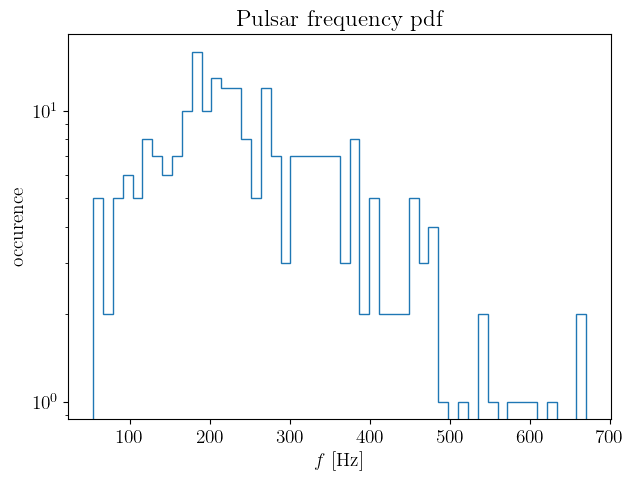

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist = ['darkslateblue', 'firebrick', 'green', 'orange']
liestyle_list = ['-.', 'solid']

#ax.hist(df_pulsar_all[df_pulsar_all['F0'].to_numpy() < 50]['F0'].to_numpy(), 100, density=False, histtype='step');
ax.hist(df_pulsar_all_sub['F0'].to_numpy(), 50, density=False, histtype='step');
ax.set_title(r'Pulsar frequency pdf')
ax.set_xlabel(r'$f\ [\rm{Hz}]$')
ax.set_ylabel(r'occurence');
#ax.set_xscale('log');  
ax.set_yscale('log');

In [278]:
start_f = 50
delta_rel = 0.01
end_f = (1+delta_rel)*max(df_pulsar_all['F0'].to_numpy())

f_temp = start_f
bin_edges = []
bin_edges.append(f_temp)

while f_temp < end_f:
    #print(f_temp)
    f_temp += delta_rel*f_temp
    bin_edges.append(f_temp)
len(np.array(bin_edges))

270

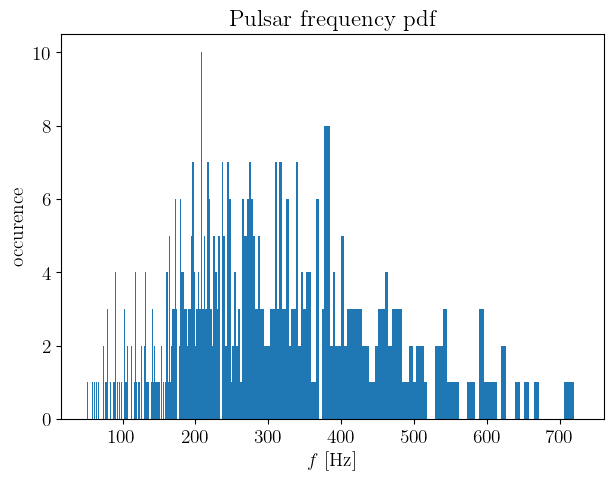

In [279]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist = ['darkslateblue', 'firebrick', 'green', 'orange']
liestyle_list = ['-.', 'solid']

hist = ax.hist(df_pulsar_all[df_pulsar_all['F0'].to_numpy() > start_f]['F0'].to_numpy(), bin_edges, density=False);
ax.set_title(r'Pulsar frequency pdf')
ax.set_xlabel(r'$f\ [\rm{Hz}]$')
ax.set_ylabel(r'occurence');
#ax.set_xscale('log');  
#ax.set_yscale('log');

In [288]:
hist[1][np.argmax(hist[0]):np.argmax(hist[0])+2]

array([207.4562175 , 209.53077968])

In [289]:
df_pulsar_all[((df_pulsar_all['F0'].to_numpy() > 207.4562175) & (df_pulsar_all['F0'].to_numpy() < 209.53077968))]

,NAME,RAJ,DECJ,PMRA,PMDEC,P0,P1,F0,F1,F2,S400,S1400,S2000,BINARY,DIST,DIST_DM,R_LUM,R_LUM14,AGE
#,,,,,,,,,,,,,,,,,,,
30,J0024-7204V,00:24:05.6,-72:04:52.6,NaN,NaN,0.004810,NaN,207.892963,NaN,NaN,NaN,NaN,NaN,BTX,4.690,2.480,NaN,NaN,NaN
222,J0514-4002M,05:14:06.8,-40:02:48,NaN,NaN,0.004798,NaN,208.428863,NaN,NaN,NaN,NaN,NaN,NaN,11.440,25.000,NaN,NaN,NaN
787,J1326-4728B,13:26:49.5,-47:29:24.6,NaN,NaN,0.004792,2.760000e-20,208.686833,-1.200000e-15,NaN,NaN,0.06,NaN,ELL1,5.200,6.883,NaN,1.490,2.760000e+09
1544,J1725-3853,17:25:27.2,-38:53:04.2,NaN,NaN,0.004792,5.000000e-20,208.688856,-2.178000e-15,NaN,NaN,NaN,NaN,NaN,3.142,3.142,NaN,NaN,1.520000e+09
1717,J1748-2446an,17:48:05.6,-24:46:42.0,2.1,-28.0,0.004802,1.560000e-19,208.231917,-6.753000e-15,-8.830000e-25,NaN,0.03,NaN,DD,4.389,4.389,NaN,0.597,4.890000e+08
2064,J1824-2452M,18:24:33.1,-34:52:08.2,0.0,-23.0,0.004784,1.230000e-19,209.017679,-5.366000e-15,-1.400000e-26,NaN,NaN,0.01,ELL1,8.360,8.360,NaN,NaN,6.170000e+08
2943,J1940+26,19:40:13,+26:01,NaN,NaN,0.004814,NaN,207.747779,NaN,NaN,NaN,NaN,NaN,NaN,7.924,7.924,NaN,NaN,NaN
3080,J2010+3051,20:10:03.9,+30:51:18.8,-10.3,-3.0,0.004816,4.870000e-21,207.629361,-2.098000e-16,NaN,NaN,0.10,NaN,ELL1,6.450,6.450,NaN,4.160,1.570000e+10
3207,B2127+11D,21:29:58.2,+12:09:59.7,NaN,NaN,0.004803,-1.080000e-18,208.211688,4.660000e-14,NaN,0.34,NaN,NaN,NaN,10.400,25.000,36.8,NaN,NaN


## Positive f_dot

In [23]:
df_pulsar = df_pulsar_all[((df_pulsar_all['F1']>0) & (df_pulsar_all['BINARY'].isna()) & (df_pulsar_all['F0']>50))]
len(df_pulsar)
df_pulsar.sort_values(by=['F0'], inplace=True)
#df_pulsar = pd.read_csv('pulsar_data/pulsar_table.csv', index_col=0, keep_default_na=True)
#df_pulsar.columns

<ipython-input-23-84b8950bc1a8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pulsar.sort_values(by=['F0'], inplace=True)


In [39]:
min(df_pulsar['F0']), min(df_pulsar['F1']), max(df_pulsar['F1'])

(56.538013, 4.17e-17, 4.66e-14)

In [26]:
df_pulsar['F0']*2

#
1810     113.076026
1302     192.724470
1718     237.076506
2671     239.297466
1841     263.100064
1837     278.721770
1699     321.185420
12       347.416438
2678     371.448554
13       373.303340
3207     416.423376
2674     437.467716
34       439.131212
20       460.175492
16       495.003050
1839     534.945350
21       543.974458
2167     618.759430
22       654.888638
1879    1339.867166
Name: F0, dtype: float64

In [40]:
alpha_min_list, alpha_max_list = np.zeros(len(df_pulsar)), np.zeros(len(df_pulsar));
abh0 = 0.5 ### Initial BH spin
tau_cutoff = 1000*Year ## Cutoff for the lifetime of the SR cloud

for i in range(len(df_pulsar)):
    [f_obs, fdot_obs, dist] = df_pulsar.iloc[i][['F0', 'F1', 'DIST']].to_numpy()
    mu = 2*np.pi*f_obs*Hz ## Fix the dark photon mass to the pulsar frequency

    alpha_min_list[i], alpha_max_list[i] = alpha_min_fn(mu, abh0, fdot_obs*Hz/Second), alpha_max_fn(mu, abh0, tau_cutoff)

In [41]:
alpha_points = 50

df_res = pd.DataFrame(columns = ['f_obs', 'fdot_obs', 'dist', 'mu', 'alpha', 'Mbh', 'fdot_ratio', 'tauGW', 'strain', 'powGW', 'EM_lum_eps1', 'eps_min', 'eps_max', 'eps_Rlum14'],
                      index = np.linspace(0, len(df_pulsar)*alpha_points-1, len(df_pulsar)*alpha_points));
res_array = np.zeros(df_res.shape)

In [42]:
bc = ub.UltralightBoson(spin=1, model="relativistic") 

In [43]:
mbh_min, mbh_max = 3*MSolar, 30*MSolar
tau_age_cutoff = 1000*Year
radio_frac = 1e-6

for pul_i in tqdm(range(len(df_pulsar))):
    
    [f_obs, fdot_obs, dist] = df_pulsar.iloc[pul_i][['F0', 'F1', 'DIST']].to_numpy()
    mu = 2*np.pi*f_obs*Hz ## Fix the dark photon mass to the pulsar frequency

    res_array[(pul_i)*alpha_points:(pul_i+1)*alpha_points, :4] = [f_obs, fdot_obs, dist, mu/eV]
    
    alpha_list = np.linspace(1.05*alpha_min_list[pul_i], 1.2*alpha_max_list[pul_i], alpha_points)
    Mbh_list = np.zeros(alpha_points)
    fdot_ratio = np.zeros(alpha_points)
    tauGW_list = np.zeros(alpha_points)
    strain_list = np.zeros(alpha_points)
    powGW_list = np.zeros(alpha_points)
    EMlum_list = np.zeros(alpha_points)
    eps_min_list = np.zeros(alpha_points)
    eps_max_list = np.zeros(alpha_points)
    eps_Rlum14_list = np.zeros(alpha_points)

    for i, alpha in enumerate(alpha_list):
        Mbh0 = alpha/(GN*mu)/MSolar; 

        if ((Mbh0 > mbh_min/MSolar) & (Mbh0 < mbh_max/MSolar)):
            Mbh_list[i] = Mbh0;
            try:
                wf = bc.make_waveform(Mbh0, abh0, alpha, units="physical+alpha")
            except ValueError:
                break 

            if wf.azimuthal_num()==1:
                f_gw = wf.freq_gw(0)
                fdot_gw = wf.freqdot_gw(0)
                tauGW = wf.gw_time()
                Mc_sat = wf.mass_cloud(0)
                Nocc = Mc_sat*MSolar/mu

                # Function to find the time when f_dot is equal to the observed value 
                func = lambda log_t : wf.freqdot_gw(10**log_t)/(2*fdot_obs) - 1
                if ( (fdot_gw > 2*fdot_obs) & (tauGW*Second/tau_cutoff > 1) ):
                    t_sol = 10**fsolve(func, np.log10(tauGW))[0]
                    #print(t_sol/(tauGW), t_sol*Second/tau_cutoff)

                    if t_sol*Second/tau_age_cutoff > 1:
                        strain_list[i] = wf.strain_char(t_sol, dObs=dist*0.001) #np.sqrt(4/10)*
                        powGW_list[i] = wf.power_gw(t_sol)
                        EMlum_list[i] = EM_lum(1, alpha, wf.mass_cloud(t_sol), Mbh0)/(erg/Second)
                        eps_max_list[i] = np.sqrt(powGW_list[i]*Watt/(erg/Second)/EMlum_list[i])

                        func = lambda log_eps : Gamma_pair_fn(10**log_eps, mu, alpha, Nocc)/(alpha*mu) - 1  
                        eps_start = 1/(ElectronCharge*alpha**(3/2))*(MElectron/mu)**(3/2)/np.sqrt(Nocc)
                        eps_min_list[i] = 10**fsolve(func, np.log10(eps_start))[0]  
                        eps_Rlum14_list[i] = np.sqrt(df_pulsar.iloc[pul_i]['R_LUM14']*1400*1e6*Hz*(0.001*Jy*(kpc**2))/(erg/Second)/(radio_frac*EMlum_list[i]))

                fdot_ratio[i] = fdot_gw/(2*fdot_obs)
                tauGW_list[i] = tauGW    

    res_array[(pul_i)*alpha_points:(pul_i+1)*alpha_points, 4] = alpha_list
    res_array[(pul_i)*alpha_points:(pul_i+1)*alpha_points, 5] = Mbh_list
    res_array[(pul_i)*alpha_points:(pul_i+1)*alpha_points, 6] = fdot_ratio
    res_array[(pul_i)*alpha_points:(pul_i+1)*alpha_points, 7] = tauGW_list*Second//Year
    res_array[(pul_i)*alpha_points:(pul_i+1)*alpha_points, 8] = strain_list
    res_array[(pul_i)*alpha_points:(pul_i+1)*alpha_points, 9] = powGW_list
    res_array[(pul_i)*alpha_points:(pul_i+1)*alpha_points, 10] = EMlum_list
    res_array[(pul_i)*alpha_points:(pul_i+1)*alpha_points, 11] = eps_min_list
    res_array[(pul_i)*alpha_points:(pul_i+1)*alpha_points, 12] = eps_max_list
    res_array[(pul_i)*alpha_points:(pul_i+1)*alpha_points, 13] = eps_Rlum14_list

  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-43-2362a2786e22>:52: RuntimeWarning: overflow encountered in power
  func = lambda log_eps : Gamma_pair_fn(10**log_eps, mu, alpha, Nocc)/(alpha*mu) - 1
100%|██████████| 20/20 [00:01<00:00, 10.74it/s]


In [44]:
df_res[['f_obs', 'fdot_obs', 'dist', 'mu', 'alpha', 'Mbh', 'fdot_ratio', 'tauGW', 'strain', 'powGW', 'EM_lum_eps1', 'eps_min', 'eps_max', 'eps_Rlum14']] = res_array
### Save the result
#df_res.to_csv('pulsar_data/pulsar_res.csv')

In [45]:
max_alpha_test = np.zeros(len(df_pulsar))
for pul_i in tqdm(range(len(df_pulsar))):
    max_alpha_test[pul_i] = max(res_array[(pul_i)*alpha_points:(pul_i+1)*alpha_points, 4][res_array[(pul_i)*alpha_points:(pul_i+1)*alpha_points, 8]>0])
min(max_alpha_test), max(max_alpha_test)

 20%|██        | 4/20 [00:00<00:00, 14193.92it/s]


ValueError: max() arg is an empty sequence

In [46]:
for pul_i in tqdm(range(len(df_pulsar))):
    
    ind_temp_0, ind_temp_1 = (pul_i)*alpha_points, (pul_i+1)*alpha_points
    #print(df_res.iloc[ind_temp_0]['f_obs'], (df_res[ind_temp_0:ind_temp_1]['alpha'].to_numpy()/(GN*df_res[ind_temp_0:ind_temp_1]['mu'].to_numpy()*eV)/MSolar)[df_res[ind_temp_0:ind_temp_1]['strain'] > 0])
    print(df_res.iloc[ind_temp_0]['f_obs'], (df_res[ind_temp_0:ind_temp_1]['alpha'].to_numpy())[df_res[ind_temp_0:ind_temp_1]['strain'] > 0])

100%|██████████| 20/20 [00:00<00:00, 672.22it/s]

56.538013 [0.02467463 0.02507564 0.02547665 0.02587766 0.02627867 0.02667968
 0.0270807  0.02748171 0.02788272 0.02828373 0.02868474 0.02908575
 0.02948676 0.02988777 0.03028878 0.03068979 0.0310908  0.03149181
 0.03189282 0.03229383 0.03269484 0.03309585 0.03349687 0.03389788
 0.03429889 0.0346999  0.03510091 0.03550192 0.03590293 0.03630394
 0.03670495 0.03710596 0.03750697 0.03790798 0.03830899 0.03871
 0.03911101 0.03951203 0.03991304 0.04031405 0.04071506 0.04111607
 0.04151708]
96.362235 [0.02848934 0.02878015 0.02907096 0.02936177 0.02965258 0.02994339
 0.0302342  0.03052501 0.03081582 0.03110663 0.03139744 0.03168825
 0.03197906 0.03226987 0.03256068 0.03285149 0.0331423  0.03343311
 0.03372392 0.03401473 0.03430554 0.03459635 0.03488716 0.03517797
 0.03546878 0.03575959 0.0360504  0.03634121 0.03663202 0.03692283
 0.03721364 0.03750445 0.03779526 0.03808607 0.03837688 0.03866769
 0.0389585 ]
118.538253 [0.03568985 0.03587032 0.03605079 0.03623126 0.03641173 0.0365922
 0.036772

In [16]:
#df_res = pd.read_csv('pulsar_data/pulsar_res.csv', index_col=0)
#df_res

,f_obs,fdot_obs,dist,mu,alpha,Mbh,fdot_ratio,tauGW,strain,powGW,EM_lum_eps6
0.0,173.708219,1.504000e-15,4.69,7.183012e-13,0.023864,4.458611,0.434756,42767.0,0.000000e+00,0.000000e+00,0.000000e+00
1.0,173.708219,1.504000e-15,4.69,7.183012e-13,0.024533,4.583596,0.613824,32766.0,0.000000e+00,0.000000e+00,0.000000e+00
2.0,173.708219,1.504000e-15,4.69,7.183012e-13,0.025202,4.708581,0.858319,25291.0,0.000000e+00,0.000000e+00,0.000000e+00
3.0,173.708219,1.504000e-15,4.69,7.183012e-13,0.025871,4.833566,1.189268,19659.0,1.351352e-24,1.820883e+34,1.675960e+43
4.0,173.708219,1.504000e-15,4.69,7.183012e-13,0.026540,4.958551,1.633580,15383.0,1.334455e-24,1.775575e+34,1.497298e+43
...,...,...,...,...,...,...,...,...,...,...,...
975.0,90.749627,4.267000e-16,8.10,3.752590e-13,0.035850,12.821104,64.159651,1671.0,1.300539e-24,1.372187e+34,4.058815e+42
976.0,90.749627,4.267000e-16,8.10,3.752590e-13,0.036645,13.105183,83.873529,1358.0,1.286614e-24,1.342887e+34,3.686089e+42
977.0,90.749627,4.267000e-16,8.10,3.752590e-13,0.037439,13.389263,108.978100,1108.0,1.273135e-24,1.314823e+34,3.354608e+42
978.0,90.749627,4.267000e-16,8.10,3.752590e-13,0.038233,13.673342,140.771959,909.0,0.000000e+00,0.000000e+00,0.000000e+00


## Plot

In [47]:
ligo_h = np.loadtxt('ligo_data/boson_O3_datafig/boson_O3_UL_1Hz.txt')  # np.loadtxt('ligo_data/hf_2111.15507_fig5.txt') 
ligo_h2 = np.loadtxt('ligo_data/hf_2107.00600_fig4.txt')  # np.loadtxt('ligo_data/hf_2111.15507_fig5.txt') 
#ligo_h[:, 1] = ligo_h[:, 1]*1e-25

ligo_h_prj = np.loadtxt('ligo_data/hf_2112.10990_fig1.txt')
ligo_h_prj[:, 1] = ligo_h_prj[:, 1]*1e-25

In [48]:
dp_limits = np.loadtxt('pulsar_data/DPlimits.txt')

In [122]:
good_doublet = []
good_doublet_i = []
good_fdot = []

B0021-72G 247.501525
J1801-0857C 267.472675
J0024-7204Z 219.565606
B0021-72M 271.987229


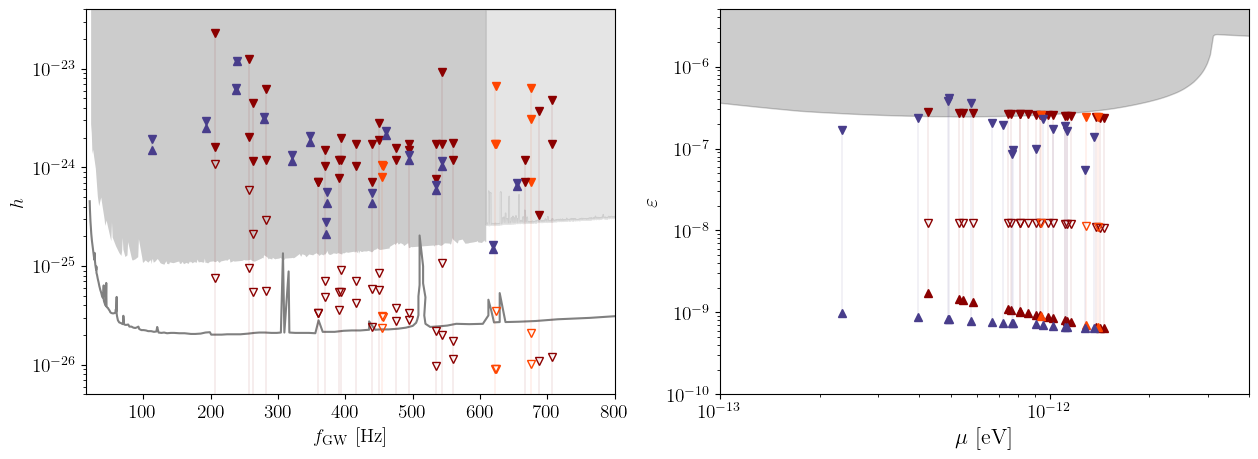

In [123]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
colorlist =  ['darkslateblue', 'darkred', 'orangered', 'green'] #['teal', 'orange', 'indianred']
liestyle_list = ['solid', 'dashed', 'dashdot']
font_s = 16
line_w = 0.1
mark_s = 6
min_h_list, max_h_list = [], []

min_y, max_y = 5e-27, 4e-23

ax[0].fill_between(ligo_h2[:, 0][ligo_h2[:, 0]>max(ligo_h[:, 0])], ligo_h2[:, 1][ligo_h2[:, 0]>max(ligo_h[:, 0])], max_y, alpha=0.1, color='k')
ax[0].fill_between(ligo_h[:, 0], ligo_h[:, 1], max_y, alpha=0.2, color='k', linewidth=0)
ax[0].plot(ligo_h_prj[:, 0], ligo_h_prj[:, 1], 'gray')

for i, p_index in enumerate(triplet_ind):
    f0 = 2*df_pulsar_all_sub.iloc[p_index]['F0']
    if i%3==0:
        strain_1 = np.concatenate([strain_list_tr_1[i], strain_list_tr_1[i+1], strain_list_tr_1[i+2]])
        strain = np.concatenate([strain_list_tr[i], strain_list_tr[i+1], strain_list_tr[i+2]])
        ax[0].axvline(f0, 0, (np.log10(max(strain))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), c=colorlist[2], linewidth=line_w, linestyle='solid')
        #ax[0].axvline(f0, (np.log10(max(strain_1))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), (np.log10(max(strain))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), c=colorlist[2], linewidth=line_w, linestyle='dashed')
        #ax[0].axvline(f0, 0, (np.log10(max(strain_1))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), c=colorlist[2], linewidth=0.8, linestyle='solid')
    #ax[0].axvline(f0, (np.log10(min(strain_list_tr[i]))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), (np.log10(max(strain_list_tr[i]))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), c=colorlist[0], linewidth=0.8)
    ax[0].plot(f0, max(strain_list_tr[i]), 'v', c=colorlist[2], markersize=mark_s)
    ax[0].plot(f0, max(strain_list_tr_1[i]), 'v', c=colorlist[2], fillstyle='none', markersize=mark_s)
    #ax[0].plot(f0, max(strain_list_tr_1[i]), 'v', c=colorlist[2], markersize=3)
    
count_pair = 0     
for i, p_index in enumerate(pair_ind):
    f0 = 2*df_pulsar_all_sub.iloc[p_index]['F0']
    strain = strain_list_pr[i][~np.isnan(strain_list_pr[i])]
    strain_1 = strain_list_pr_1[i][~np.isnan(strain_list_pr_1[i])]
    if len(strain)>1:
        count_pair = count_pair+1
        good_doublet.append(p_index)
        good_doublet_i.append(i)
        
        if ((df_pulsar_all_sub.iloc[p_index]['F1'] > 0) & (~isinstance(df_pulsar_all_sub.iloc[p_index]['BINARY'], str))):
            print(df_pulsar_all_sub.iloc[p_index]['NAME'], df_pulsar_all_sub.iloc[p_index]['F0'])
            #ax[0].plot(f0, max(strain), 'o', c=colorlist[0], fillstyle='none', markersize=9, alpha=1)        
        #    strain = np.concatenate([strain_list_pr[i][~np.isnan(strain_list_pr[i])], strain_list_pr[i+1][~np.isnan(strain_list_pr[i])]])
        #    ax[0].axvline(f0, 0, (np.log10(max(strain))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), c=colorlist[1], linewidth=1, linestyle='solid')
        #else:
        ax[0].plot(f0, max(strain), 'v', c=colorlist[1], markersize=mark_s, alpha=1)
        ax[0].plot(f0, max(strain_1), 'v', c=colorlist[1], fillstyle='none', markersize=mark_s, alpha=1)

    if i%2==0:
        strain = np.concatenate([strain_list_pr[i][~np.isnan(strain_list_pr[i])], strain_list_pr[i+1][~np.isnan(strain_list_pr[i])]])
        strain_1 = np.concatenate([strain_list_pr_1[i][~np.isnan(strain_list_pr_1[i])], strain_list_pr_1[i+1][~np.isnan(strain_list_pr_1[i])]])
        if len(strain)>1:
            1
            ax[0].axvline(f0, 0, (np.log10(max(strain))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), c=colorlist[1], linewidth=line_w, linestyle='solid')
            #ax[0].axvline(f0, (np.log10(max(strain_1))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), (np.log10(max(strain))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), c=colorlist[1], linewidth=line_w, linestyle='dashed')
            #ax[0].axvline(f0, 0, (np.log10(max(strain_1))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), c=colorlist[1], linewidth=line_w)



for pul_i in range(len(df_pulsar)):
    selct_pul = ((df_res[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1]['strain']>0) )
    #print(pul_i, len(df_res[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1]['strain'][selct_pul]>0))
    if len(df_res[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1]['strain'][selct_pul]>0):        
        min_h, max_h = min(df_res[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1]['strain'][selct_pul]), max(df_res[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1]['strain'][selct_pul])
        #list_max[pul_i] = max_h
        min_h_list.append(min_h)
        max_h_list.append(max_h)
        #ax[0].plot((2*df_pulsar.iloc[pul_i]['F0'],2*df_pulsar.iloc[pul_i]['F0']),(min_h, max_h), linewidth=2, c=colorlist[0], alpha=1)
        ax[0].plot(2*df_pulsar.iloc[pul_i]['F0'], min_h, '^', c=colorlist[0], markersize=mark_s, alpha=1)
        ax[0].plot(2*df_pulsar.iloc[pul_i]['F0'], max_h, 'v', c=colorlist[0], markersize=mark_s, alpha=1)
        ax[0].plot((2*df_pulsar.iloc[pul_i]['F0'],2*df_pulsar.iloc[pul_i]['F0']),(min_h, max_h), linewidth=line_w, c=colorlist[0], alpha=1)


ax[0].set_yscale('log');
ax[0].set_xlim(15, 800); ax[0].set_ylim(min_y, max_y)
ax[0].set_xlabel(r'$f_{\rm{GW}}\ [\rm{Hz}]$')
ax[0].set_ylabel(r'$h$');


ax[1].fill_between(dp_limits[:, 0], dp_limits[:, 1], 1, color='k', alpha=0.2)    

min_y, max_y = 1e-10,5e-6
line_w = 0.1

for i, p_index in enumerate(pair_ind):
    if i%2==0:
        e_min = eps_min_pr[i][~np.isnan(eps_min_pr[i])]
        e_min_lum = eps_min_lum_pr[i][~np.isnan(eps_min_lum_pr[i])]
        e_max = eps_max_pr[i][~np.isnan(eps_max_pr[i])]
        e_max_1 = eps_max_pr_1[i][~np.isnan(eps_max_pr_1[i])]

        if len(e_min)>1:
            ax[1].plot(mu_list_pr[i]/eV, min(e_min), '^', c=colorlist[1], markersize=mark_s, alpha=1)
            #ax[1].plot(mu_list_pr[i]/eV, min(e_min_lum), '^', c=colorlist[1], markersize=3, alpha=1)
            ax[1].plot(mu_list_pr[i]/eV, max(e_max), 'v', c=colorlist[1], markersize=mark_s, alpha=1)
            ax[1].plot(mu_list_pr[i]/eV, max(e_max_1), 'v', c=colorlist[1], fillstyle='none', markersize=mark_s, alpha=1)
            ax[1].axvline(mu_list_pr[i]/eV, (np.log10(min(e_min))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), (np.log10(max(e_max))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), c=colorlist[1], linewidth=line_w)
            #ax[1].axvline(mu_list_pr[i]/eV, (np.log10(max(e_max_1))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), (np.log10(max(e_max))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), c=colorlist[1], linewidth=line_w, linestyle='dashed')
            #ax[1].axvline(mu_list_pr[i]/eV, (np.log10(min(e_min))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), (np.log10(max(e_max_1))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), c=colorlist[1], linewidth=line_w)
            #ax[1].axvline(mu_list_pr[i]/eV, (np.log10(min(e_min_lum))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), (np.log10(max(e_min))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), c=colorlist[1], linewidth=line_w, linestyle='dotted')

for i, p_index in enumerate(triplet_ind):
    if i%3==0:
        e_min = eps_min_tr[i][~np.isnan(eps_min_tr[i])]
        e_min_lum = eps_min_lum_tr[i][~np.isnan(eps_min_lum_tr[i])]
        e_max = eps_max_tr[i][~np.isnan(eps_max_tr[i])]
        e_max_1 = eps_max_tr_1[i][~np.isnan(eps_max_tr_1[i])]

        if len(e_min)>1:
            ax[1].plot(mu_list_tr[i]/eV, min(e_min), '^', c=colorlist[2], markersize=mark_s, alpha=1)
            #ax[1].plot(mu_list_tr[i]/eV, min(e_min_lum), '^', c=colorlist[2], markersize=mark_s, alpha=1)
            ax[1].plot(mu_list_tr[i]/eV, max(e_max), 'v', c=colorlist[2], markersize=mark_s, alpha=1)
            ax[1].plot(mu_list_tr[i]/eV, max(e_max_1), 'v', c=colorlist[2], fillstyle='none', markersize=mark_s, alpha=1)
            ax[1].axvline(mu_list_tr[i]/eV, (np.log10(min(e_min))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), (np.log10(max(e_max))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), c=colorlist[2], linewidth=line_w)
            #ax[1].axvline(mu_list_tr[i]/eV, (np.log10(min(e_max_1))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), (np.log10(max(e_max))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), c=colorlist[2], linewidth=line_w, linestyle='dashed')
            #ax[1].axvline(mu_list_tr[i]/eV, (np.log10(min(e_min))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), (np.log10(max(e_max_1))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), c=colorlist[2], linewidth=line_w)
            #ax[1].axvline(mu_list_tr[i]/eV, (np.log10(min(e_min_lum))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), (np.log10(max(e_min))-np.log10(min_y))/(np.log10(max_y)-np.log10(min_y)), c=colorlist[2], linewidth=line_w, linestyle='dotted')

count_pul=0
for pul_i in range(len(df_pulsar)):
    selct_pul = ((df_res[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1]['strain']>0) )

    if len(df_res[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1]['strain'][selct_pul]>0):
        good_fdot.append(pul_i)
        count_pul=count_pul+1
        min_e, max_e = min(df_res[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1]['eps_min'][selct_pul]), max(df_res[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1]['eps_max'][selct_pul])

        ax[1].plot(df_res[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1]['mu'][selct_pul], df_res[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1]['eps_Rlum14'][selct_pul] , '.', c=colorlist[0], markersize=mark_s, alpha=1)
        
        ax[1].plot(df_res.iloc[(pul_i)*alpha_points]['mu'], min_e, '^', c=colorlist[0], markersize=mark_s, alpha=1)
        ax[1].plot(df_res.iloc[(pul_i)*alpha_points]['mu'], max_e, 'v', c=colorlist[0], markersize=mark_s, alpha=1)
        ax[1].plot((df_res.iloc[(pul_i)*alpha_points]['mu'],df_res.iloc[(pul_i)*alpha_points]['mu']),(min_e, max_e), linewidth=line_w, c=colorlist[0], alpha=1)

ax[1].set_xscale('log');  
ax[1].set_yscale('log');
ax[1].set_xlim(1e-13, 4e-12); ax[1].set_ylim(min_y, max_y);

ax[1].set_xlabel(r'$\mu\ [\rm{eV}]$', fontsize=font_s)
ax[1].set_ylabel(r'$\varepsilon$', fontsize=font_s);

#fig.savefig('plots/pulsars.pdf', bbox_inches="tight")

In [120]:
len(pd.read_csv('pulsar_data/pulsar_fdot.csv'))

16

In [131]:
df_pulsar_triplets = (df_pulsar_all_sub.iloc[triplet_ind]).reset_index(drop=True)
df_pulsar_triplets['F_GW'] = df_pulsar_triplets['F0']*2
df_pulsar_triplets['h_max'] = np.max(strain_list_tr, axis=1)
df_pulsar_triplets.sort_values(by=['F_GW']).reset_index()

,index,NAME,RAJ,DECJ,PMRA,PMDEC,P0,P1,F0,F1,...,S1400,S2000,BINARY,DIST,DIST_DM,R_LUM,R_LUM14,AGE,F_GW,h_max
0,0,J1342+2822F,13:42:11.6,+28:22:38,NaN,NaN,0.004400,NaN,227.272727,NaN,...,NaN,NaN,NaN,10.200,25.000,NaN,NaN,NaN,454.545454,8.009058e-25
1,1,J1803-3002B,18:03:34.0,-30:02:02,NaN,NaN,0.004397,NaN,227.427792,NaN,...,NaN,NaN,NaN,7.700,5.802,NaN,NaN,NaN,454.855584,1.060940e-24
2,2,J1823-3021E,18:23:38.9,-30:22:22.3,NaN,NaN,0.004394,NaN,227.583068,NaN,...,NaN,NaN,NaN,7.900,3.372,NaN,NaN,NaN,455.166136,1.034082e-24
3,3,B0021-72H,00:24:06.7,-72:04:06.8,5.1,-2.8,0.003210,-1.830000e-21,311.493418,1.775000e-16,...,NaN,NaN,DD,4.690,2.541,NaN,NaN,NaN,622.986836,1.741826e-24
4,4,J1628-3205,16:28:07.0,-32:05:48.9,NaN,NaN,0.003210,NaN,311.526480,NaN,...,NaN,NaN,BT,1.225,1.225,NaN,NaN,NaN,623.052960,6.668702e-24
5,5,J1930+1403g,19:30:18,+14:03,NaN,NaN,0.003210,NaN,311.526480,NaN,...,0.09,NaN,NaN,4.740,4.740,NaN,2.11,NaN,623.052960,1.723451e-24
6,6,J1624-39,16:24:25,-39:51:00,NaN,NaN,0.002960,NaN,337.837838,NaN,...,NaN,NaN,NaN,2.629,2.629,NaN,NaN,NaN,675.675676,3.107325e-24
7,7,J2045-68,20:45:17,-68:36:20,NaN,NaN,0.002960,NaN,337.837838,NaN,...,NaN,NaN,NaN,1.273,1.273,NaN,NaN,NaN,675.675676,6.417248e-24
8,8,J0514-4002L,05:14:06.8,-40:02:48.0,NaN,NaN,0.002959,NaN,337.974855,NaN,...,NaN,NaN,BT,11.440,25.000,NaN,NaN,NaN,675.949710,7.140887e-25


In [132]:
df_pulsar_doublets = (df_pulsar_all_sub.iloc[good_doublet]).reset_index(drop=True)
df_pulsar_doublets['F_GW'] = df_pulsar_doublets['F0']*2
df_pulsar_doublets['h_max'] = np.max(strain_list_pr[good_doublet_i], axis=1)
df_pulsar_doublets.sort_values(by=['F_GW']).reset_index()

,index,NAME,RAJ,DECJ,PMRA,PMDEC,P0,P1,F0,F1,...,S1400,S2000,BINARY,DIST,DIST_DM,R_LUM,R_LUM14,AGE,F_GW,h_max
0,20,J1748-3009,17:48:23.7,-30:09:11.2,NaN,NaN,0.009684,-3.580000e-20,103.263527,3.817000e-16,...,1.40,NaN,BT,5.053,5.053,NaN,35.7000,NaN,206.527054,1.613490e-24
1,21,J0921-5202,09:21,-52:02,NaN,NaN,0.009680,NaN,103.305785,NaN,...,0.19,NaN,NaN,0.355,0.355,NaN,0.0238,NaN,206.611570,2.296619e-23
2,4,J1122-3546,11:22,-35:46,NaN,NaN,0.007800,NaN,128.205128,NaN,...,NaN,NaN,NaN,0.656,0.656,NaN,NaN,NaN,256.410256,1.244706e-23
3,5,J1546-5925,15:46,-59:25,NaN,NaN,0.007800,NaN,128.205128,NaN,...,0.27,NaN,NaN,4.004,4.004,NaN,4.3100,NaN,256.410256,2.039279e-24
4,32,J2129-0429,21:29:45.0,-04:29:05.5,12.34,10.19,0.007620,NaN,131.233596,NaN,...,NaN,NaN,ELL1,1.830,1.385,1.670,NaN,NaN,262.467192,4.462355e-24
5,33,J1701-3006C,17:01:12.8,-30:06:59.4,NaN,NaN,0.007613,-6.410000e-20,131.356873,1.107000e-15,...,0.30,0.72,BT,7.050,4.834,NaN,14.9000,NaN,262.713746,1.158318e-24
6,36,J1551-0658,15:51:07.2,-06:58:06.5,NaN,NaN,0.007090,NaN,141.043724,NaN,...,NaN,NaN,NaN,1.325,1.325,0.878,NaN,NaN,282.087448,6.164581e-24
7,37,J1748-2446T,17:48:04.8,-24:46:45,NaN,NaN,0.007085,NaN,141.145053,NaN,...,NaN,0.02,NaN,6.900,4.390,NaN,NaN,NaN,282.290106,1.183780e-24
8,12,J0514-4002N,05:14:06.7,-40:02:47,NaN,NaN,0.005568,NaN,179.600927,NaN,...,NaN,NaN,NaN,11.440,25.000,NaN,NaN,NaN,359.201854,7.139653e-25
9,13,J0514-4002C,05:14:06.6,-40:02:49.4,NaN,NaN,0.005565,NaN,179.700978,NaN,...,NaN,NaN,NaN,11.440,25.000,NaN,NaN,NaN,359.401956,7.139642e-25


In [127]:
df_pulsar_fdot = (df_pulsar.iloc[good_fdot]).reset_index(drop=True)
df_pulsar_fdot['F_GW'] = df_pulsar_fdot['F0']*2
df_pulsar_fdot['h_max'] = max_h_list
df_pulsar_fdot['h_min'] = min_h_list
df_pulsar_fdot.sort_values(by=['F_GW']).reset_index()

,index,NAME,RAJ,DECJ,PMRA,PMDEC,P0,P1,F0,F1,...,S2000,BINARY,DIST,DIST_DM,R_LUM,R_LUM14,AGE,F_GW,h_max,h_min
0,0,J1757-2745,17:57:54.7,-27:45:40.1,-11.40,54.00,0.017687,-1.300000e-20,56.538013,4.170000e-17,...,NaN,NaN,8.208,8.208,NaN,4.72,NaN,113.076026,1.959393e-24,1.514261e-24
1,1,B1639+36A,16:41:40.8,+36:27:14.9,NaN,NaN,0.010378,-7.270000e-20,96.362235,6.750000e-16,...,NaN,NaN,7.100,6.736,151.0,7.06,NaN,192.724470,2.921555e-24,2.502112e-24
2,2,J1748-2446C,17:48:04.5,-24:46:36,NaN,NaN,0.008436,-6.060000e-19,118.538253,8.515000e-15,...,NaN,NaN,6.900,4.385,NaN,NaN,NaN,237.076506,6.310973e-24,6.100835e-24
3,3,J1910-5959B,19:10:52.0,-59:59:00.8,NaN,NaN,0.008358,-7.900000e-19,119.648733,1.132000e-14,...,NaN,NaN,4.000,1.631,NaN,0.80,NaN,239.297466,1.192882e-23,1.190303e-23
4,4,J1801-0857A,18:01:50.6,-08:57:31.8,NaN,NaN,0.007176,-5.100000e-19,139.360885,9.912000e-15,...,0.02,NaN,10.600,6.684,NaN,4.04,NaN,278.721770,3.222905e-24,3.124445e-24
5,5,J1748-2021C,17:48:51.1,-20:21:53.8,NaN,NaN,0.006227,-5.980000e-20,160.592710,1.543000e-15,...,0.04,NaN,8.500,9.318,NaN,NaN,NaN,321.185420,1.338338e-24,1.165716e-24
6,6,B0021-72C,00:23:50.3,-72:04:31.5,5.20,-3.10,0.005757,-4.990000e-20,173.708219,1.504000e-15,...,0.23,NaN,4.690,2.594,33.7,11.40,NaN,347.416438,2.068884e-24,1.790000e-24
7,7,J1911+0101B,19:11:12.5,+01:01:50.4,NaN,NaN,0.005384,-2.000000e-21,185.724277,6.899000e-17,...,NaN,NaN,7.400,8.681,NaN,NaN,NaN,371.448554,2.800306e-25,2.134588e-25
8,8,B0021-72D,00:24:13.8,-72:04:43.8,4.24,-2.24,0.005358,-3.420000e-21,186.651670,1.192000e-16,...,0.20,NaN,4.690,2.631,20.9,7.70,NaN,373.303340,5.606076e-25,4.381236e-25
9,9,J0024-7204Z,00:24:06.0,-72:05:01.4,4.00,1.00,0.004554,-4.540000e-21,219.565606,2.190000e-16,...,NaN,NaN,4.690,2.559,NaN,NaN,NaN,439.131212,5.449724e-25,4.342988e-25


In [128]:
df_pulsar_triplets.to_csv('pulsar_data/pulsar_triplets.csv')
len(df_pulsar_triplets)

9

In [129]:
df_pulsar_doublets.to_csv('pulsar_data/pulsar_doublets.csv')
len(df_pulsar_doublets)

38

In [130]:
df_pulsar_fdot.to_csv('pulsar_data/pulsar_fdot.csv')
len(df_pulsar_fdot)

16

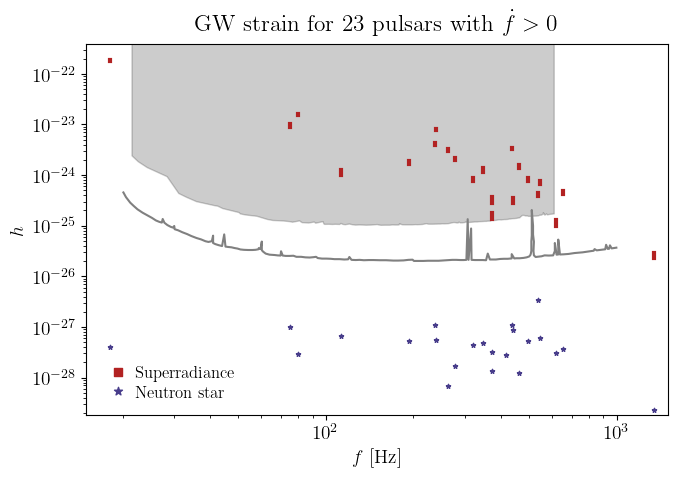

In [756]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))

#ax.plot(ligo_h[:, 0], ligo_h[:, 1], '-', linewidth=1, c='gray');
ax.fill_between(ligo_h[:, 0], ligo_h[:, 1], max_y, alpha=0.2, color='k')
ax.plot(ligo_h_prj[:, 0], ligo_h_prj[:, 1], 'gray')
list_max = np.zeros(len(df_pulsar))
count=0

for pul_i in range(len(df_pulsar)):
  
    #if (df_pulsar.iloc[pul_i]['F0'] > 5): ### Remove the three pulsars with small frequency, which require Mbh > 1000 MSolar
    count=count+1
    min_h, max_h = min(df_res[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1]['strain'][df_res[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1]['strain']>0]), max(df_res[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1]['strain'])
    list_max[pul_i] = max_h
    #ax.scatter(2*df_pulsar.iloc[pul_i]['F0'], min_h + (max_h-min_h)/2, s=15,  marker="*", c='firebrick')
    ax.plot((2*df_pulsar.iloc[pul_i]['F0'],2*df_pulsar.iloc[pul_i]['F0']),(min_h, max_h), linewidth=3, c='firebrick', alpha=1)
    ax.scatter(2*df_pulsar.iloc[pul_i]['F0'], sp_strain[pul_i], s=10,  alpha=1, marker="*", c='darkslateblue')
    #ax.bar(2*df_pulsar.iloc[pul_i]['F0'], height=max_h, width=500/(2*df_pulsar.iloc[pul_i]['F0']), bottom=min_h)
    #ax.axvline(2*df_pulsar.iloc[pul_i]['F0'], ymin=0, ymax=1, linewidth=2)

p = [plt.scatter([0, 10], [0, 0], marker='s', c='firebrick'), plt.scatter([0, 10], [0, 0], marker="*", alpha=1, c='darkslateblue')]
ax.legend(p, [r'Superradiance', r'Neutron star', ], loc='lower left', frameon=False, labelspacing=0.1, fontsize=12, handletextpad=0.01, handleheight=1);
[p[i].set_visible(False) for i in range(len(p))]

ax.set_xscale('log');  ax.set_yscale('log');
ax.set_xlim(15, 1500); ax.set_ylim(0.8*min(sp_strain), 2*max(list_max))

ax.set_title(r'GW strain for '+str(count)+' pulsars with $\dot{f} > 0$', pad=10);
ax.set_xlabel(r'$f\ [\rm{Hz}]$')
ax.set_ylabel(r'$h$');

fig.tight_layout()
#fig.savefig('plots/positive_fdot_hvsf.pdf')

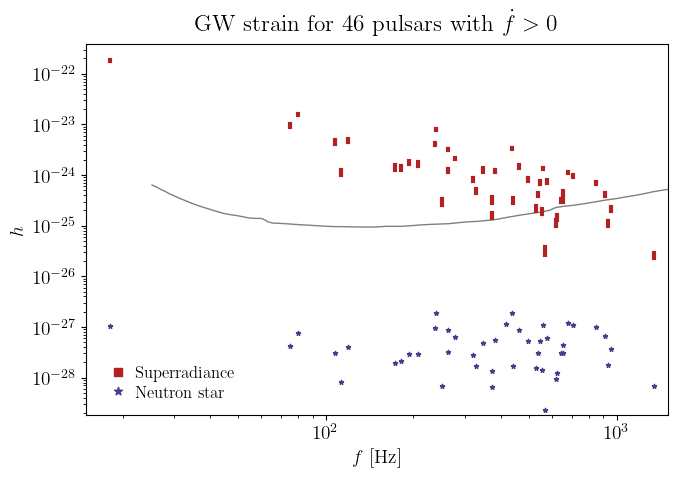

In [159]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))

#ax.plot(ligo_h[:, 0], ligo_h[:, 1], '-', linewidth=1, c='gray');
#list_max = np.zeros(len(df_pulsar))
#count=0

for pul_i in range(len(df_pulsar)):
    
    if (df_pulsar.iloc[pul_i]['F0'] > 5): ### Remove the three pulsars with small frequency, which require Mbh > 1000 MSolar
        count=count+1
        min_h, max_h = min(df_res[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1]['strain'][df_res[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1]['strain']>0]), max(df_res[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1]['strain'])
        list_max[pul_i] = max_h
        #ax.scatter(2*df_pulsar.iloc[pul_i]['F0'], min_h + (max_h-min_h)/2, s=15,  marker="*", c='firebrick')
        ax.plot((2*df_pulsar.iloc[pul_i]['F0'],2*df_pulsar.iloc[pul_i]['F0']),(min_h, max_h), linewidth=3, c='firebrick', alpha=1)
        ax.scatter(2*df_pulsar.iloc[pul_i]['F0'], sp_strain[pul_i], s=10,  alpha=1, marker="*", c='darkslateblue')
        #ax.bar(2*df_pulsar.iloc[pul_i]['F0'], height=max_h, width=500/(2*df_pulsar.iloc[pul_i]['F0']), bottom=min_h)
        #ax.axvline(2*df_pulsar.iloc[pul_i]['F0'], ymin=0, ymax=1, linewidth=2)

p = [plt.scatter([0, 10], [0, 0], marker='s', c='firebrick'), plt.scatter([0, 10], [0, 0], marker="*", alpha=1, c='darkslateblue')]
ax.legend(p, [r'Superradiance', r'Neutron star', ], loc='lower left', frameon=False, labelspacing=0.1, fontsize=12, handletextpad=0.01, handleheight=1);
[p[i].set_visible(False) for i in range(len(p))]

ax.set_xscale('log');  ax.set_yscale('log');
ax.set_xlim(15, 1500); ax.set_ylim(0.8*min(sp_strain), 2*max(list_max))

ax.set_title(r'GW strain for '+str(count)+' pulsars with $\dot{f} > 0$', pad=10);
ax.set_xlabel(r'$f\ [\rm{Hz}]$')
ax.set_ylabel(r'$h$');

fig.tight_layout()
fig.savefig('plots/positive_fdot_hvsf.pdf')

# Import pulsar data and compute the GW strain

In [703]:
df_pulsar = pd.read_csv('pulsar_data/pulsar_table.csv', index_col=0, keep_default_na=True)
df_pulsar.columns

Index(['NAME', 'RAJ', 'DECJ', 'PMRA', 'PMDEC', 'P0', 'P1', 'F0', 'F1', 'F2',
       'DIST', 'DIST_DM', 'R_LUM', 'R_LUM14', 'AGE'],
      dtype='object')

In [253]:
df_pulsar['DIST']

1      4.690
2      4.690
3      4.690
4      4.690
5      4.690
6      4.690
7      4.690
8      4.690
9      4.690
10     4.690
11     4.690
12     4.690
13     4.690
14     1.395
15     7.500
16     7.100
17     7.100
18     7.100
19     7.050
20     7.050
21     7.050
22     8.500
23     8.500
24     8.500
25     6.900
26     6.900
27     4.395
28     5.053
29    11.600
30     4.143
31     8.208
32    10.600
33    10.600
34    10.600
35    10.600
36     8.237
37     3.000
38     0.195
39     7.900
40     4.938
41     3.200
42     4.753
43     4.000
44     4.000
45     7.400
46     7.400
47    10.400
48    10.400
49     8.100
Name: DIST, dtype: float64

In [704]:
alpha_min_list, alpha_max_list = np.zeros(len(df_pulsar)), np.zeros(len(df_pulsar));
abh0 = 0.7 ### Initial BH spin
tau_cutoff = 1000*Year ## Cutoff for the lifetime of the SR cloud

for i in range(len(df_pulsar)):
    [f_obs, fdot_obs, dist] = df_pulsar.iloc[i][['F0', 'F1', 'DIST']].to_numpy()
    mu = 2*np.pi*f_obs*Hz ## Fix the dark photon mass to the pulsar frequency

    alpha_min_list[i], alpha_max_list[i] = alpha_min_fn(mu, abh0, fdot_obs*Hz/Second), alpha_max_fn(mu, abh0, tau_cutoff)

In [705]:
alpha_points = 20
epsilon = 1e-6

df_res = pd.DataFrame(columns = ['f_obs', 'fdot_obs', 'dist', 'mu', 'alpha', 'Mbh', 'fdot_ratio', 'tauGW', 'strain', 'powGW', 'EM_lum_eps6'],
                      index = np.linspace(0, len(df_pulsar)*alpha_points-1, len(df_pulsar)*alpha_points));
res_array = np.zeros(df_res.shape)

In [706]:
for pul_i in tqdm(range(len(df_pulsar))):
    
    [f_obs, fdot_obs, dist] = df_pulsar.iloc[pul_i][['F0', 'F1', 'DIST']].to_numpy()
    mu = 2*np.pi*f_obs*Hz ## Fix the dark photon mass to the pulsar frequency

    res_array[(pul_i)*alpha_points:(pul_i+1)*alpha_points, :4] = [f_obs, fdot_obs, dist, mu/eV]
    
    alpha_list = np.linspace(1.05*alpha_min_list[pul_i], 1.2*alpha_max_list[pul_i], alpha_points)
    Mbh_list = np.zeros(alpha_points)
    fdot_ratio = np.zeros(alpha_points)
    tauGW_list = np.zeros(alpha_points)
    strain_list = np.zeros(alpha_points)
    powGW_list = np.zeros(alpha_points)
    EMlum_list = np.zeros(alpha_points)

    for i, alpha in enumerate(alpha_list):
        Mbh0 = alpha/(GN*mu)/MSolar; Mbh_list[i] = Mbh0;

        #print(i, alpha)
        bc = ub.UltralightBoson(spin=1, model="relativistic") 
        bc.make_waveform(Mbh0, abh0, alpha, units="physical+alpha")
        wf = bc.make_waveform(Mbh0, abh0, alpha, units="physical+alpha")

        f_gw = wf.freq_gw(0)
        fdot_gw = wf.freqdot_gw(0)
        tauGW = wf.gw_time()

        # Function to find the time when f_dot is equal to the observed value 
        func = lambda log_t : wf.freqdot_gw(10**log_t)/(2*fdot_obs) - 1
        if ( (fdot_gw > 2*fdot_obs) & (tauGW*Second/tau_cutoff > 1) ):
            t_sol = 10**fsolve(func, np.log10(tauGW))[0]
            strain_list[i] = np.sqrt(4/10)*wf.strain_char(t_sol, dObs=dist*0.001)
            powGW_list[i] = wf.power_gw(t_sol)
            EMlum_list[i] = EM_lum(epsilon, alpha, wf.mass_cloud(t_sol), Mbh0)/(erg/Second)

        fdot_ratio[i] = fdot_gw/(2*fdot_obs)
        tauGW_list[i] = tauGW    
    
    res_array[(pul_i)*alpha_points:(pul_i+1)*alpha_points, 4] = alpha_list
    res_array[(pul_i)*alpha_points:(pul_i+1)*alpha_points, 5] = Mbh_list
    res_array[(pul_i)*alpha_points:(pul_i+1)*alpha_points, 6] = fdot_ratio
    res_array[(pul_i)*alpha_points:(pul_i+1)*alpha_points, 7] = tauGW_list*Second//Year
    res_array[(pul_i)*alpha_points:(pul_i+1)*alpha_points, 8] = strain_list
    res_array[(pul_i)*alpha_points:(pul_i+1)*alpha_points, 9] = powGW_list
    res_array[(pul_i)*alpha_points:(pul_i+1)*alpha_points, 10] = EMlum_list

  0%|          | 0/49 [00:26<?, ?it/s]


KeyboardInterrupt: 

In [702]:
alpha_list

array([0.02393522, 0.02472956, 0.0255239 , 0.02631825, 0.02711259,
       0.02790693, 0.02870127, 0.02949562, 0.03028996, 0.0310843 ,
       0.03187864, 0.03267298, 0.03346733, 0.03426167, 0.03505601,
       0.03585035, 0.03664469, 0.03743904, 0.03823338, 0.03902772])

In [701]:
res_array[res_array!=0]

array([], dtype=float64)

In [12]:
df_res[['f_obs', 'fdot_obs', 'dist', 'mu', 'alpha', 'Mbh', 'fdot_ratio', 'tauGW', 'strain', 'powGW', 'EM_lum_eps6']] = res_array
### Save the result
#df_res.to_csv('pulsar_data/pulsar_res.csv')

In [16]:
df_res = pd.read_csv('pulsar_data/pulsar_res.csv', index_col=0)
df_res

,f_obs,fdot_obs,dist,mu,alpha,Mbh,fdot_ratio,tauGW,strain,powGW,EM_lum_eps6
0.0,173.708219,1.504000e-15,4.69,7.183012e-13,0.023864,4.458611,0.434756,42767.0,0.000000e+00,0.000000e+00,0.000000e+00
1.0,173.708219,1.504000e-15,4.69,7.183012e-13,0.024533,4.583596,0.613824,32766.0,0.000000e+00,0.000000e+00,0.000000e+00
2.0,173.708219,1.504000e-15,4.69,7.183012e-13,0.025202,4.708581,0.858319,25291.0,0.000000e+00,0.000000e+00,0.000000e+00
3.0,173.708219,1.504000e-15,4.69,7.183012e-13,0.025871,4.833566,1.189268,19659.0,1.351352e-24,1.820883e+34,1.675960e+43
4.0,173.708219,1.504000e-15,4.69,7.183012e-13,0.026540,4.958551,1.633580,15383.0,1.334455e-24,1.775575e+34,1.497298e+43
...,...,...,...,...,...,...,...,...,...,...,...
975.0,90.749627,4.267000e-16,8.10,3.752590e-13,0.035850,12.821104,64.159651,1671.0,1.300539e-24,1.372187e+34,4.058815e+42
976.0,90.749627,4.267000e-16,8.10,3.752590e-13,0.036645,13.105183,83.873529,1358.0,1.286614e-24,1.342887e+34,3.686089e+42
977.0,90.749627,4.267000e-16,8.10,3.752590e-13,0.037439,13.389263,108.978100,1108.0,1.273135e-24,1.314823e+34,3.354608e+42
978.0,90.749627,4.267000e-16,8.10,3.752590e-13,0.038233,13.673342,140.771959,909.0,0.000000e+00,0.000000e+00,0.000000e+00


# Ligo sensitivity curve

In [595]:
ligo_h = np.loadtxt('ligo/ligo_2209.02863_fig6up.txt')
ligo_h[:, 1] = ligo_h[:, 1]*1e-25

In [145]:
logf_val = np.linspace(np.log10(ligo_h[0, 0]), np.log10(ligo_h[-1, 0]), 100)
logh_interp = np.interp(logf_val, np.log10(ligo_h[:, 0]), np.log10(ligo_h[:, 1]))

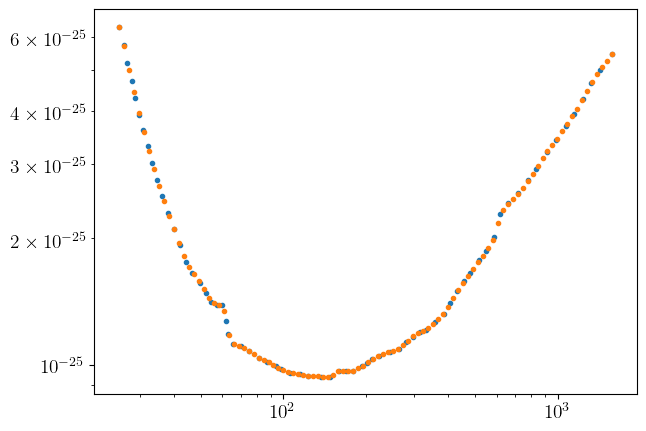

In [146]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))

ax.plot(ligo_h[:, 0], ligo_h[:, 1], '.');
ax.plot(10**logf_val, 10**logh_interp, '.');
ax.set_xscale('log');  ax.set_yscale('log');

# Ligo mergers followup

In [65]:
dp_limits = np.loadtxt('pulsar_data/DPlimits.txt')

## Select best Ligo events

In [44]:
ligo_h = np.loadtxt('ligo/ligo_2209.02863_fig6up.txt')
ligo_h[:, 1] = ligo_h[:, 1]*1e-25

In [46]:
df_events_all = pd.DataFrame(np.array([['GW190814', 230, 25.7, 0.28, 19], ['GW200115_042309', 290, 7.2, 0.42, 370], ['GW170608', 320, 17.8, 0.69, 392], ['GW191216_213338', 340, 18.87, 0.7, 490], 
                                       ['GW200202_154313', 410, 16.76, 0.69, 170], ['GW150914', 440, 63.1, 0.69, 182], ['GW190924_021846', 550, 13.3, 0.67, 360], ['GW170814', 600, 53.2, 0.72, 87] ]), 
                         columns=['commonName', 'luminosity_distance', 'final_mass_source', 'final_chi', 'delta_omega'])
df_events_all

,commonName,luminosity_distance,final_mass_source,final_chi,delta_omega
0,GW190814,230,25.7,0.28,19
1,GW200115_042309,290,7.2,0.42,370
2,GW170608,320,17.8,0.69,392
3,GW191216_213338,340,18.87,0.7,490
4,GW200202_154313,410,16.76,0.69,170
5,GW150914,440,63.1,0.69,182
6,GW190924_021846,550,13.3,0.67,360
7,GW170814,600,53.2,0.72,87


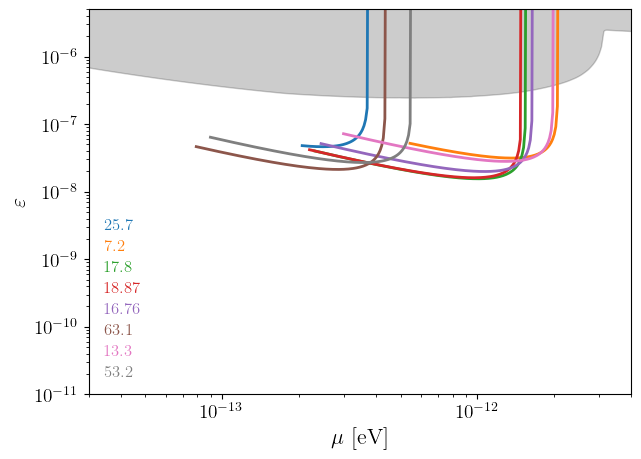

In [246]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist =  ['darkslateblue', 'orange', 'firebrick', 'green'] #['teal', 'orange', 'indianred']
liestyle_list = ['solid', '--']
font_s = 16

GWevent_list = ['GW170814', r'GW190814', r'$\rm{GW200202\textunderscore 154313}$']

ax.fill_between(dp_limits[:, 0], dp_limits[:, 1], 1, color='k', alpha=0.2)

for i_event in range(len(df_events)):
    ax.plot(res_array[i_event][:, 0][res_array[i_event][:, 2]<2], res_array[i_event][:, 1][res_array[i_event][:, 2]<2], linestyle=liestyle_list[0], linewidth=2)
    
ax.legend([df_events.iloc[i]['final_mass_source'] for i in range(len(df_events))],
          loc='lower left', frameon=False, labelspacing=0.3, fontsize=12, handletextpad=0, handlelength=0, markerscale=0, labelcolor='linecolor');

    
ax.set_xscale('log');  ax.set_yscale('log');
ax.set_xlim(3e-14, 4e-12); ax.set_ylim(1e-11,5e-6);

ax.set_xlabel(r'$\mu\ [\rm{eV}]$', fontsize=font_s)
ax.set_ylabel(r'$\varepsilon$', fontsize=font_s);

## Folloup current and projections

In [47]:
df_events = pd.DataFrame(np.array([['GW170814', 600, 53.2, 0.72, 87], ['GW190814', 230, 25.7, 0.28, 19], ['GW200202_154313', 410, 16.76, 0.69, 170]]), 
                         columns=['commonName', 'luminosity_distance', 'final_mass_source', 'final_chi', 'delta_omega'])
df_events

,commonName,luminosity_distance,final_mass_source,final_chi,delta_omega
0,GW170814,600,53.2,0.72,87
1,GW190814,230,25.7,0.28,19
2,GW200202_154313,410,16.76,0.69,170


In [33]:
bc = ub.UltralightBoson(spin=1, model="relativistic") 

In [48]:
#flux_th = 3.6e-12*erg/(Second*CentiMeter**2) #3.2e-15*erg/(Second*CentiMeter**2) ## X-ray flux sensitivity
radio_curr = 1e4*3.7e-19*erg/(Second*CentiMeter**2) ### ASKAP
tradio_curr = 10*Hour
xray_curr = 2e-14*erg/(Second*CentiMeter**2) ### Switf XRT sensitivity
txray_curr = 1e4*Second

xray_fut = 1e-15*erg/(Second*CentiMeter**2) ### Future X-ray sensitivity (Athena)
txray_fut = 1e5*Second
radio_pul = 1e4*1e-19*erg/(Second*CentiMeter**2) ### Fast and CHIME (slightly worse)
tradio_fut = 24*Hour
radio_steady = 1e4*0.5e-19*erg/(Second*CentiMeter**2) ### Fast and CHIME (slightly worse)
tradio_steady = 10*Hour

t_cutoff = 10*Year
n_mu = 300
mu_array = np.zeros((len(df_events), n_mu))
eps_min = 1+np.zeros((len(df_events), n_mu))
res_radio_curr = np.nan+np.zeros((len(df_events), n_mu))
res_xray_curr = np.nan+np.zeros((len(df_events), n_mu))
res_xray_fut = np.nan+np.zeros((len(df_events), n_mu))
res_radio_pul = np.nan+np.zeros((len(df_events), n_mu))
res_radio_steady = np.nan+np.zeros((len(df_events), n_mu))

for i_event in tqdm(range(len(df_events))):
    Mbh0, abh0, dist = float(df_events.iloc[i_event]['final_mass_source']), float(df_events.iloc[i_event]['final_chi']), float(df_events.iloc[i_event]['luminosity_distance'])*Mpc
    print(Mbh0, abh0)
    
    mu_list_temp = np.logspace(np.log10(0.001/(Mbh0*MSolar*GN)), np.log10(0.3/(Mbh0*MSolar*GN)), n_mu)
    
    mu_array[i_event] = mu_list_temp/eV
    
    for i_mu, mu in enumerate(mu_list_temp): 
        
        alpha = mu*Mbh0*MSolar*GN
        try:
            wf = bc.make_waveform(Mbh0, abh0, alpha, units="physical+alpha")
        except ValueError:
            break 
        
        if wf.azimuthal_num()==1:
            
            t_sat = wf.cloud_growth_time()*Second
            Mc_sat = wf.mass_cloud(0)
            t_gw = wf.gw_time()*Second
            
            if t_gw>24*Hour:
                Ndays = t_gw/(24*Hour)
            else:
                Ndays = 1
                        
            if(t_sat<t_cutoff):
                Nocc = Mc_sat*MSolar/mu

                ### Compute the minimum value of epsilon allowed when the cloud reaches saturation
                func = lambda log_eps : Gamma_pair_fn(10**log_eps, mu, alpha, Nocc)/(alpha*mu) - 1  

                eps_start = 1/(ElectronCharge*alpha**(3/2))*(MElectron/mu)**(3/2)/np.sqrt(Nocc)
                eps_min[i_event][i_mu] = 10**fsolve(func, np.log10(eps_start))[0]   #res_array[i_event][i_mu, 2] = 10**fsolve(func, np.log10(eps_start))[0]  
                       
                lumi_1 = EM_lum(1, alpha, Mc_sat, Mbh0)
                
                if(t_gw > tradio_steady):
                    res_radio_steady[i_event][i_mu] = np.sqrt(radio_steady*((24*Hour/min(24*Hour, t_gw))**(1/2))*(4*np.pi*dist**2)/lumi_1)
                
                if(t_gw > tradio_fut):
                    res_radio_pul[i_event][i_mu] = np.sqrt(radio_pul/(Ndays**(1/4))*(4*np.pi*dist**2)/lumi_1)
                
                if(t_gw > tradio_curr):
                     res_radio_curr[i_event][i_mu] = np.sqrt(radio_curr*(4*np.pi*dist**2)/lumi_1)
                if(t_gw > txray_curr):
                     res_xray_curr[i_event][i_mu] = np.sqrt(xray_curr*(4*np.pi*dist**2)/lumi_1)                
                if(t_gw > txray_fut):
                     res_xray_fut[i_event][i_mu] = np.sqrt(xray_fut*(4*np.pi*dist**2)/lumi_1)

  0%|          | 0/3 [00:00<?, ?it/s]

53.2 0.72


<ipython-input-48-56bbca784711>:55: RuntimeWarning: overflow encountered in power
  func = lambda log_eps : Gamma_pair_fn(10**log_eps, mu, alpha, Nocc)/(alpha*mu) - 1
 33%|███▎      | 1/3 [00:02<00:04,  2.20s/it]

25.7 0.28


 67%|██████▋   | 2/3 [00:02<00:01,  1.68s/it]

16.76 0.69


100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


In [135]:
res_radio_steady[0][res_radio_steady[0]>0]

array([2.50137962e-08, 2.46055392e-08, 2.42052927e-08, 2.38129141e-08,
       2.34282640e-08, 2.30512057e-08, 2.26816057e-08, 2.23193333e-08,
       2.19642606e-08, 2.16162627e-08, 2.12752175e-08, 2.09410056e-08,
       2.06135102e-08, 2.02926176e-08, 1.99782166e-08, 1.96701985e-08,
       1.93684575e-08, 1.90728905e-08, 1.87833969e-08, 1.84998787e-08,
       1.82222405e-08, 1.79503898e-08, 1.76842362e-08, 1.74236925e-08,
       1.71686736e-08, 1.69190975e-08, 1.66748844e-08, 1.64359575e-08,
       1.62022426e-08, 1.59736682e-08, 1.57501655e-08, 1.55316688e-08,
       1.53181149e-08, 1.51094438e-08, 1.49055984e-08, 1.47065247e-08,
       1.45121717e-08, 1.43224921e-08, 1.41374415e-08, 1.39569793e-08,
       1.37810686e-08, 1.36096762e-08, 1.34427731e-08, 1.32803345e-08,
       1.31223400e-08, 1.29687741e-08, 1.28196263e-08, 1.26748915e-08,
       1.25345705e-08, 1.23986703e-08, 1.22672047e-08, 1.21401949e-08,
       1.20176699e-08, 1.18996676e-08, 1.17862354e-08, 1.16774313e-08,
      

In [139]:
### Check mimumim alpha

for i_event in tqdm(range(len(df_events))):
    Mbh0 = float(df_events.iloc[i_event]['final_mass_source'])

    mu_min_temp = mu_array[i_event][res_radio_steady[i_event]>0][0]
    
    print(i_event, Mbh0, mu_min_temp*eV*GN*Mbh0*MSolar)

100%|██████████| 3/3 [00:00<00:00, 787.61it/s]

0 53.2 0.0361011516565497
1 25.7 0.039714078401298814
2 16.76 0.030405971090235462


In [233]:
df_events['commonName']

0           GW170814
1           GW190814
2    GW200202_154313
Name: commonName, dtype: object

## Estimate maximum distance visible

In [33]:
bc = ub.UltralightBoson(spin=1, model="relativistic") 

In [140]:
mu_list = np.logspace(-13, -11.5, 50)*eV
eps_list = np.logspace(-10, -6, 50)
dist_array = np.zeros((len(mu_list), len(eps_list)))

In [141]:
Mbh0 = 10*MSolar
abh0 = 0.7
flux_th = 3e-15*erg/(Second*CentiMeter**2) #1e5*3.7e-19*erg/(Second*CentiMeter**2) ### Radio flux sensitivity

for i_e, eps in enumerate(eps_list):
    for i_mu, mu in enumerate(mu_list):
        
        alpha = mu*Mbh0*GN
        try:
            wf = bc.make_waveform(Mbh0/MSolar, abh0, alpha, units="physical+alpha")
        except ValueError:
            break 
        
        if wf.azimuthal_num()==1:
            Mc_sat = wf.mass_cloud(0)*MSolar
            dist_array[i_mu, i_e] = np.sqrt(EM_lum(eps, alpha, Mc_sat, Mbh0)/(4*np.pi*flux_th))

In [143]:
def fmt(logx):
    x = 10**logx
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return f"{s}"
    #return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"

<ipython-input-144-8a1bd59115c8>:8: RuntimeWarning: divide by zero encountered in log10
  contours = ax.contour(mu_list/myu.eV, eps_list, np.log10(dist_array/(myu.Mpc)).T, levels=level_list) #, colors='k')


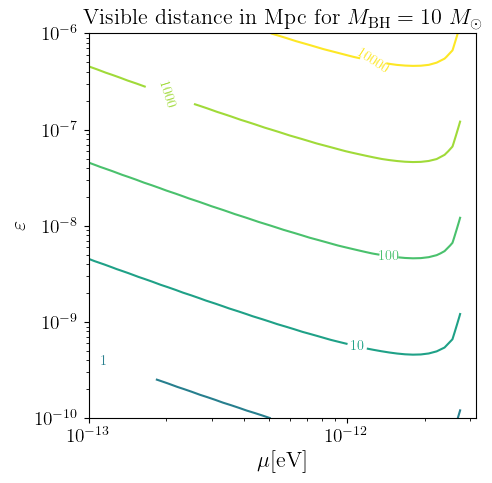

In [144]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
font_s = 16


level_list = np.arange(-3, 5, 1)
level_list_2 = [1, 12]

contours = ax.contour(mu_list/eV, eps_list, np.log10(dist_array/(Mpc)).T, levels=level_list) #, colors='k')

#xv, yv = np.meshgrid(alpha_list, eps_list)
#ax[1].plot(xv.reshape(len(alpha_list)*len(eps_list)), yv.reshape(len(alpha_list)*len(eps_list)), '.', markersize=0.2)

ax.clabel(contours, inline=True, fmt=fmt, fontsize=10)

ax.set_xscale('log');  ax.set_yscale('log');
#ax[1].set_xlim(3.1e-3, 0.3); ax[1].set_ylim(1e-10,1e-6);
#ax[0].yaxis.set_ticks_position('both')

ax.set_xlabel(r'$\mu [\rm{eV}]$', fontsize=font_s)
ax.set_ylabel(r'$\varepsilon$', fontsize=font_s);
ax.set_title(r'Visible distance in Mpc for $M_{\rm{BH}} = 10\ M_{\odot}$', fontsize=font_s);

#ax2 = ax[1].twiny()
#ax2.set_xscale('log');
#ax2.contour(alpha_list/(GN*Mbh0*MSolar)/eV, eps_list, np.log10(tSR_array/tPl_array), colors='k', levels=level_list_2, linewidths=1, linestyles='dashed') 
#ax2.fill_between(dp_limits[:, 0], dp_limits[:, 1], 1, color='k', alpha=0.15)
#ax2.set_xbound([x/(GN*Mbh0*MSolar)/eV for x in ax[1].get_xbound()])
#ax2.set_xlabel(r'$\mu\ [\rm{eV}]$', fontsize=font_s);

#ax[1].text(0.21, 7e-9, r'$\tau_{\rm plasma}/\tau_{\rm{SR}} = 10^{-2}$', fontsize=12, rotation=-90, va='center')
#props = dict(boxstyle='square', alpha=1, fill=False, linewidth=0.5)
#ax[1].text(0.0035, 1.5e-10, r'$M_{\rm{BH}} = 10\ M_{\odot}$', fontsize=12, bbox=props);

#fig.savefig('plots/plasma.pdf', bbox_inches="tight")

<ipython-input-361-d98dabd8a7ce>:7: RuntimeWarning: divide by zero encountered in log10
  contours = ax.contour(mu_list/myu.eV, eps_list, np.log10(dist_array[:, :, 0]/(myu.Mpc)).T, levels=level_list) #, colors='k')
<ipython-input-361-d98dabd8a7ce>:9: RuntimeWarning: divide by zero encountered in log10
  contours = ax.contour(mu_list/myu.eV, eps_list, np.log10(dist_array[:, :, 100]/(myu.Mpc)).T, levels=level_list) #, colors='k')
<ipython-input-361-d98dabd8a7ce>:11: RuntimeWarning: divide by zero encountered in log10
  contours = ax.contour(mu_list/myu.eV, eps_list, np.log10(dist_array[:, :, 199]/(myu.Mpc)).T, levels=level_list) #, colors='k')


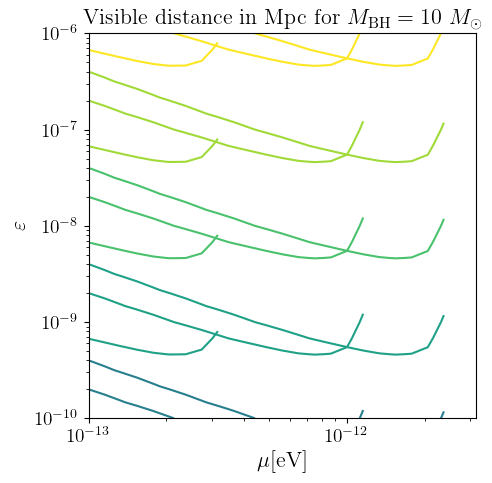

In [361]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
font_s = 16

level_list = np.arange(-3, 5, 1)
level_list_2 = [1, 12]

contours = ax.contour(mu_list/eV, eps_list, np.log10(dist_array[:, :, 0]/(Mpc)).T, levels=level_list) #, colors='k')
#ax.clabel(contours, inline=True, fmt=fmt, fontsize=10)
contours = ax.contour(mu_list/eV, eps_list, np.log10(dist_array[:, :, 100]/(Mpc)).T, levels=level_list) #, colors='k')
#ax.clabel(contours, inline=True, fmt=fmt, fontsize=10)
contours = ax.contour(mu_list/eV, eps_list, np.log10(dist_array[:, :, 199]/(Mpc)).T, levels=level_list) #, colors='k')
#ax.clabel(contours, inline=True, fmt=fmt, fontsize=10)

ax.set_xscale('log');  ax.set_yscale('log');
#ax[1].set_xlim(3.1e-3, 0.3); ax[1].set_ylim(1e-10,1e-6);
#ax[0].yaxis.set_ticks_position('both')

ax.set_xlabel(r'$\mu [\rm{eV}]$', fontsize=font_s)
ax.set_ylabel(r'$\varepsilon$', fontsize=font_s);
ax.set_title(r'Visible distance in Mpc for $M_{\rm{BH}} = 10\ M_{\odot}$', fontsize=font_s);

#fig.savefig('plots/plasma.pdf', bbox_inches="tight")

## Estimate number of events

In [554]:
dRdm1_list_PS = np.loadtxt('ligo_data/dRdm1_PS.txt')
dRdm1_list = np.loadtxt('ligo_data/dRdm1_PP.txt')
dRdm1_p1s_list = np.loadtxt('ligo_data/dRdm1_PP_p1s.txt')
dRdm1_m1s_list = np.loadtxt('ligo_data/dRdm1_PP_m1s.txt')

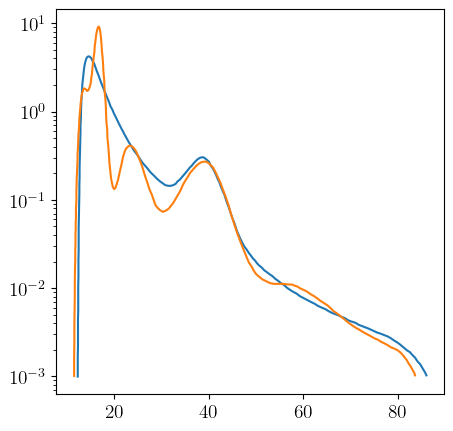

In [509]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
ax.plot(dRdm1_list[:, 0], dRdm1_list[:, 1])
ax.plot(dRdm1_list_PS[:, 0], dRdm1_list_PS[:, 1])
ax.set_yscale('log');

In [398]:
trapz(dRdm1_list[:, 1], x=dRdm1_list[:, 0]),trapz(dRdm1_p1s_list[:, 1], x=dRdm1_p1s_list[:, 0]),trapz(dRdm1_m1s_list[:, 1], x=dRdm1_m1s_list[:, 0]), trapz(dRdm1_list_PS[:, 1], x=dRdm1_list_PS[:, 0])

(25.036521249147533,
 46.425195425329285,
 14.154065615237894,
 26.808622990325276)

In [555]:
mu_list = np.logspace(-13.5, -11.8, 40)*eV
eps_list = np.logspace(-8.3, -6, 40)
lum_array = np.zeros((len(mu_list), len(eps_list), len(dRdm1_list[:, 0])))
lum_m1s_array = np.zeros((len(mu_list), len(eps_list), len(dRdm1_m1s_list[:, 0])))
lum_p1s_array = np.zeros((len(mu_list), len(eps_list), len(dRdm1_p1s_list[:, 0])))

In [556]:
abh0 = 0.7
t_cutoff = 10*Year

for i_e, eps in tqdm(enumerate(eps_list)):
    for i_mu, mu in enumerate(mu_list):
        
        for i_M, Mbh0 in enumerate(2*dRdm1_list[:, 0]*MSolar):
            
            alpha = mu*Mbh0*GN
            try:
                wf = bc.make_waveform(Mbh0/MSolar, abh0, alpha, units="physical+alpha")
            except ValueError:
                break 

            if wf.azimuthal_num()==1:
                Mc_sat = wf.mass_cloud(0)*MSolar
                t_sat = wf.cloud_growth_time()*Second
                
                if t_sat < t_cutoff:
                    lum_array[i_mu, i_e, i_M] = EM_lum(eps, alpha, Mc_sat, Mbh0)
                    #dist_array[i_mu, i_e, i_M] = np.sqrt(EM_lum(eps, alpha, Mc_sat, Mbh0)/(4*np.pi*flux_th))
                    
        for i_M, Mbh0 in enumerate(2*dRdm1_m1s_list[:, 0]*MSolar):
            
            alpha = mu*Mbh0*GN
            try:
                wf = bc.make_waveform(Mbh0/MSolar, abh0, alpha, units="physical+alpha")
            except ValueError:
                break 

            if wf.azimuthal_num()==1:
                Mc_sat = wf.mass_cloud(0)*MSolar
                t_sat = wf.cloud_growth_time()*Second
                
                if t_sat < t_cutoff:
                    lum_m1s_array[i_mu, i_e, i_M] = EM_lum(eps, alpha, Mc_sat, Mbh0)

        for i_M, Mbh0 in enumerate(2*dRdm1_p1s_list[:, 0]*MSolar):
            
            alpha = mu*Mbh0*GN
            try:
                wf = bc.make_waveform(Mbh0/MSolar, abh0, alpha, units="physical+alpha")
            except ValueError:
                break 

            if wf.azimuthal_num()==1:
                Mc_sat = wf.mass_cloud(0)*MSolar
                t_sat = wf.cloud_growth_time()*Second
                
                if t_sat < t_cutoff:
                    lum_p1s_array[i_mu, i_e, i_M] = EM_lum(eps, alpha, Mc_sat, Mbh0)

40it [31:45, 47.63s/it]


In [557]:
Nevt_array = np.zeros((len(mu_list), len(eps_list), 3))+np.nan
n_years = 1
xray_fut = 1e-15*erg/(Second*CentiMeter**2) ### Future X-ray sensitivity (Athena)

for i_e, eps in enumerate(eps_list):
    for i_mu, mu in enumerate(mu_list):
        
        dist_list = np.sqrt(lum_array[i_mu, i_e, :]/(4*np.pi*xray_fut))
        Nevt_array[i_mu, i_e, 0] = n_years*4*np.pi/3*trapz(dRdm1_list[:, 1]*(dist_list/(1000*Mpc))**3, x=dRdm1_list[:, 0])   
        
        dist_list = np.sqrt(lum_m1s_array[i_mu, i_e, :]/(4*np.pi*xray_fut))
        Nevt_array[i_mu, i_e, 1] = n_years*4*np.pi/3*trapz(dRdm1_m1s_list[:, 1]*(dist_list/(1000*Mpc))**3, x=dRdm1_m1s_list[:, 0]) 
        
        dist_list = np.sqrt(lum_p1s_array[i_mu, i_e, :]/(4*np.pi*xray_fut))
        Nevt_array[i_mu, i_e, 2] = n_years*4*np.pi/3*trapz(dRdm1_p1s_list[:, 1]*(dist_list/(1000*Mpc))**3, x=dRdm1_p1s_list[:, 0])

<ipython-input-558-c8b3cd281d18>:5: RuntimeWarning: divide by zero encountered in log10
  contours = ax.contourf(mu_list/myu.eV, eps_list, np.log10(Nevt_array[:, :, 2]).T, levels=[np.log10(n_event), 100], colors='orange', alpha=0.3) #, colors='k')
<ipython-input-558-c8b3cd281d18>:6: RuntimeWarning: divide by zero encountered in log10
  contours = ax.contour(mu_list/myu.eV, eps_list, np.log10(Nevt_array[:, :, 0]).T, levels=[np.log10(n_event)], colors='orange') #, colors='k')
<ipython-input-558-c8b3cd281d18>:8: RuntimeWarning: divide by zero encountered in log10
  contours = ax.contourf(mu_list/myu.eV, eps_list, np.log10(Nevt_array[:, :, 1]).T, levels=[np.log10(n_event), 100], colors='white') #, colors='k')


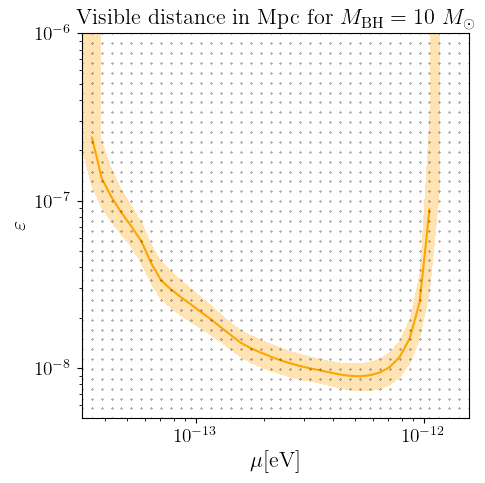

In [558]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
font_s = 16
n_event = 3

contours = ax.contourf(mu_list/eV, eps_list, np.log10(Nevt_array[:, :, 2]).T, levels=[np.log10(n_event), 100], colors='orange', alpha=0.3) #, colors='k')
contours = ax.contour(mu_list/eV, eps_list, np.log10(Nevt_array[:, :, 0]).T, levels=[np.log10(n_event)], colors='orange') #, colors='k')

contours = ax.contourf(mu_list/eV, eps_list, np.log10(Nevt_array[:, :, 1]).T, levels=[np.log10(n_event), 100], colors='white') #, colors='k')

xv, yv = np.meshgrid(mu_list/eV, eps_list)
ax.plot(xv.reshape(len(mu_list)*len(eps_list)), yv.reshape(len(mu_list)*len(eps_list)), '.', c='k', markersize=0.5)

ax.set_xscale('log');  ax.set_yscale('log');
#ax[1].set_xlim(3.1e-3, 0.3); ax[1].set_ylim(1e-10,1e-6);
#ax[0].yaxis.set_ticks_position('both')

ax.set_xlabel(r'$\mu [\rm{eV}]$', fontsize=font_s)
ax.set_ylabel(r'$\varepsilon$', fontsize=font_s);
ax.set_title(r'Visible distance in Mpc for $M_{\rm{BH}} = 10\ M_{\odot}$', fontsize=font_s);

#fig.savefig('plots/plasma.pdf', bbox_inches="tight")

## Check if the we get to cosmological distances

In [146]:
dRdm1_list_PS = np.loadtxt('ligo_data/dRdm1_PS.txt')
dRdm1_list = np.loadtxt('ligo_data/dRdm1_PP.txt')
dRdm1_p1s_list = np.loadtxt('ligo_data/dRdm1_PP_p1s.txt')
dRdm1_m1s_list = np.loadtxt('ligo_data/dRdm1_PP_m1s.txt')

In [147]:
mu_list = np.logspace(-13.5, -11.8, 20)*eV
eps_list = np.logspace(-8.3, -6, 20)
lum_array = np.zeros((len(mu_list), len(eps_list), len(dRdm1_list[:, 0])))
lum_m1s_array = np.zeros((len(mu_list), len(eps_list), len(dRdm1_m1s_list[:, 0])))
lum_p1s_array = np.zeros((len(mu_list), len(eps_list), len(dRdm1_p1s_list[:, 0])))

In [148]:
abh0 = 0.7
t_cutoff = 10*Year

for i_e, eps in tqdm(enumerate(eps_list)):
    for i_mu, mu in enumerate(mu_list):
        
        for i_M, Mbh0 in enumerate(2*dRdm1_list[:, 0]*MSolar):
            
            alpha = mu*Mbh0*GN
            try:
                wf = bc.make_waveform(Mbh0/MSolar, abh0, alpha, units="physical+alpha")
            except ValueError:
                break 

            if wf.azimuthal_num()==1:
                Mc_sat = wf.mass_cloud(0)*MSolar
                t_sat = wf.cloud_growth_time()*Second
                
                if t_sat < t_cutoff:
                    lum_array[i_mu, i_e, i_M] = EM_lum(eps, alpha, Mc_sat, Mbh0)
                    #dist_array[i_mu, i_e, i_M] = np.sqrt(EM_lum(eps, alpha, Mc_sat, Mbh0)/(4*np.pi*flux_th))

20it [02:00,  6.02s/it]


In [150]:
len(dRdm1_list[:, 0])

188

In [159]:
#dist_max_array = np.zeros((len(mu_list), len(eps_list), len(dRdm1_list[:, 0])))+np.nan
dist_max_array = np.zeros((len(mu_list), len(eps_list)))+np.nan
n_years = 1
xray_fut = 1e-15*erg/(Second*CentiMeter**2) ### Future X-ray sensitivity (Athena)

for i_e, eps in enumerate(eps_list):
    for i_mu, mu in enumerate(mu_list):
        
        dist_list = np.sqrt(lum_array[i_mu, i_e, :]/(4*np.pi*xray_fut))
        dist_max_array[i_mu, i_e] = np.max(dist_list/Mpc )

In [160]:
dist_max_array[5, 0]

183.24061805767371

In [171]:
def fmt(logx):
    x = 10**logx
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return f"{s}"
    #return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"

<ipython-input-177-eede077ec36e>:12: RuntimeWarning: divide by zero encountered in log10
  contours = ax[1].contour(mu_list/myu.eV, eps_list, np.log10(dist_max_array[:, :]).T, alpha=1) #, colors='k')


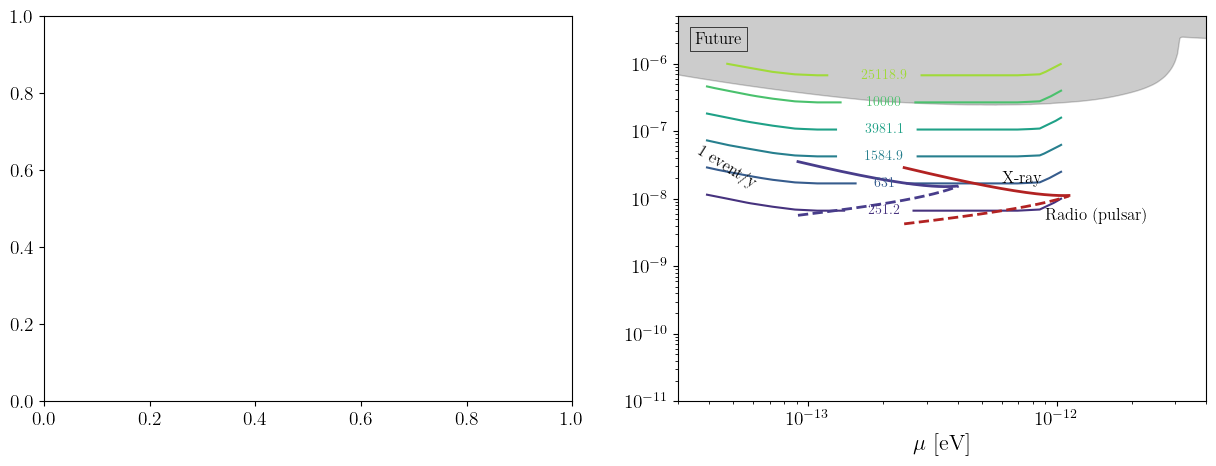

In [177]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
colorlist =  ['darkslateblue', 'orange', 'firebrick', 'green'] #['teal', 'orange', 'indianred']
liestyle_list = ['solid', 'dashed', 'dashdot']
font_s = 16
min_gw_time_radio = 10*Hour
min_gw_time_xray = 20*1000*Second
min_gw_time_pul = 24*Hour

levels=[1, 1.5, 2, 2.5, 3, 3.5, 4]

n_event = 1
contours = ax[1].contour(mu_list/eV, eps_list, np.log10(dist_max_array[:, :]).T, alpha=1) #, colors='k')
ax[1].clabel(contours, inline=True, fontsize=10, fmt=fmt)

ax[1].fill_between(dp_limits[:, 0], dp_limits[:, 1], 1, color='k', alpha=0.2)

for i_event in range(len(df_events)):
    if i_event!=1:
        ax[1].plot(mu_array[i_event], res_radio_pul[i_event], linestyle=liestyle_list[1], linewidth=2, color=colorlist[i_event])    
        #ax[1].plot(mu_array[i_event], res_radio_steady[i_event], linestyle=liestyle_list[2], linewidth=1.5, color=colorlist[i_event])    
        ax[1].plot(mu_array[i_event], res_xray_fut[i_event], linestyle=liestyle_list[0], linewidth=2, color=colorlist[i_event])    

ax[1].text(9e-13, 5e-9, r'Radio (pulsar)', fontsize=12, rotation=0)
ax[1].text(6e-13, 1.7e-8, r'X-ray', fontsize=12, rotation=0)
ax[1].text(0.35e-13, 1.4e-8, r'1 event/y', fontsize=12, rotation=-32)

ax[1].set_xscale('log');  ax[1].set_yscale('log');
ax[1].set_xlim(3e-14, 4e-12); ax[1].set_ylim(1e-11,5e-6);

ax[1].set_xlabel(r'$\mu\ [\rm{eV}]$', fontsize=font_s);

ax[1].text(0.35e-13, 2e-6, r'Future', fontsize=12, bbox=props);

#fig.savefig('plots/ligo_mergers.pdf', bbox_inches="tight")

## Plot

In [49]:
mu_list = np.load('lists/mu_list.npy')
eps_list = np.load('lists/eps_list.npy')
Nevt_array = np.load('lists/Nevt_array.npy')

<ipython-input-56-f3f34118db9d>:41: RuntimeWarning: divide by zero encountered in log10
  contours = ax[1].contourf(mu_list/myu.eV, eps_list, np.log10(Nevt_array[:, :, 2]).T, levels=[np.log10(n_event), 100], colors='turquoise', alpha=0.2) #, colors='k')
<ipython-input-56-f3f34118db9d>:42: RuntimeWarning: divide by zero encountered in log10
  contours = ax[1].contour(mu_list/myu.eV, eps_list, np.log10(Nevt_array[:, :, 0]).T, levels=[np.log10(n_event)], colors='turquoise', alpha=0.5) #, colors='k')
<ipython-input-56-f3f34118db9d>:43: RuntimeWarning: divide by zero encountered in log10
  contours = ax[1].contourf(mu_list/myu.eV, eps_list, np.log10(Nevt_array[:, :, 1]).T, levels=[np.log10(n_event), 100], colors='white') #, colors='k')


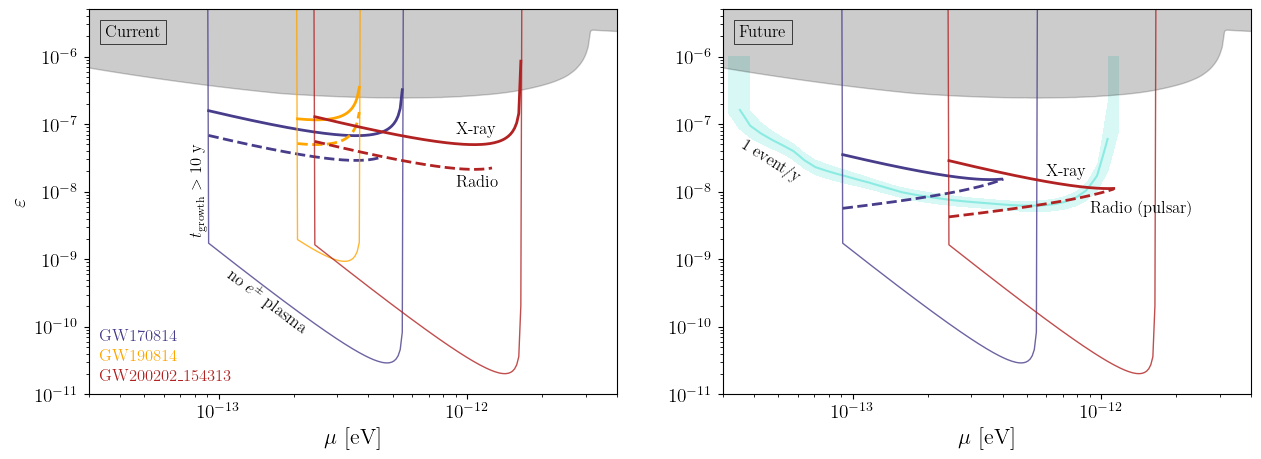

In [56]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
colorlist =  ['darkslateblue', 'orange', 'firebrick', 'green'] #['teal', 'orange', 'indianred']
liestyle_list = ['solid', 'dashed', 'dashdot']
font_s = 16
min_gw_time_radio = 10*Hour
min_gw_time_xray = 20*1000*Second
min_gw_time_pul = 24*Hour

GWevent_list = ['GW170814', r'GW190814', r'$\rm{GW200202\textunderscore 154313}$']

ax[0].fill_between(dp_limits[:, 0], dp_limits[:, 1], 1, color='k', alpha=0.2)

for i_event in range(len(df_events)):
    if i_event==0: # removes some points at the SR boundary which have longer decay time
        ax[0].plot(mu_array[i_event][mu_array[i_event]<5e-13], res_radio_curr[i_event][mu_array[i_event]<5e-13], linestyle=liestyle_list[1], linewidth=2, color=colorlist[i_event])
    else:
        ax[0].plot(mu_array[i_event], res_radio_curr[i_event], linestyle=liestyle_list[1], linewidth=2, color=colorlist[i_event])
    ax[0].plot(mu_array[i_event], res_xray_curr[i_event], linestyle=liestyle_list[0], linewidth=2, color=colorlist[i_event])
    
    ax[0].plot(mu_array[i_event], eps_min[i_event], linestyle=liestyle_list[0], linewidth=1, color=colorlist[i_event], alpha=0.8)
    

ax[0].text(7.75e-14, 2.5e-9, r'$t_{\rm{growth}} > 10$ y', fontsize=12, rotation='vertical')
ax[0].text(1.05e-13, 0.8e-10, r'no $e^{\pm}$ plasma', fontsize=12, rotation=-37)
#ax.text(5.6e-13, 8.5e-8, r'Radio (transient)', fontsize=10, rotation=-5)
#ax.text(7e-13, 2.4e-8, r'X-ray', fontsize=10, rotation=-5.8)
ax[0].text(9e-13, 1.2e-8, r'Radio', fontsize=12, rotation=0)
ax[0].text(9e-13, 0.7e-7, r'X-ray', fontsize=12, rotation=0)
[ax[0].text(3.3e-14, 10**(-10.2-i*0.3), GWevent_list[i], fontsize=12, color=colorlist[i]) for i in range(len(df_events))]
    
ax[0].set_xscale('log');  ax[0].set_yscale('log');
ax[0].set_xlim(3e-14, 4e-12); ax[0].set_ylim(1e-11,5e-6);

ax[0].set_xlabel(r'$\mu\ [\rm{eV}]$', fontsize=font_s)
ax[0].set_ylabel(r'$\varepsilon$', fontsize=font_s);

props = dict(boxstyle='square', alpha=1, fill=False, linewidth=0.5)
ax[0].text(0.35e-13, 2e-6, r'Current', fontsize=12, bbox=props);

n_event = 1
contours = ax[1].contourf(mu_list/eV, eps_list, np.log10(Nevt_array[:, :, 2]).T, levels=[np.log10(n_event), 100], colors='turquoise', alpha=0.2) #, colors='k')
contours = ax[1].contour(mu_list/eV, eps_list, np.log10(Nevt_array[:, :, 0]).T, levels=[np.log10(n_event)], colors='turquoise', alpha=0.5) #, colors='k')
contours = ax[1].contourf(mu_list/eV, eps_list, np.log10(Nevt_array[:, :, 1]).T, levels=[np.log10(n_event), 100], colors='white') #, colors='k')

ax[1].fill_between(dp_limits[:, 0], dp_limits[:, 1], 1, color='k', alpha=0.2)

for i_event in range(len(df_events)):
    if i_event!=1:
        ax[1].plot(mu_array[i_event], res_radio_pul[i_event], linestyle=liestyle_list[1], linewidth=2, color=colorlist[i_event])    
        #ax[1].plot(mu_array[i_event], res_radio_steady[i_event], linestyle=liestyle_list[2], linewidth=1.5, color=colorlist[i_event])    
        ax[1].plot(mu_array[i_event], res_xray_fut[i_event], linestyle=liestyle_list[0], linewidth=2, color=colorlist[i_event])    
        ax[1].plot(mu_array[i_event], eps_min[i_event], linestyle=liestyle_list[0], linewidth=1, color=colorlist[i_event], alpha=0.8)  

ax[1].text(9e-13, 5e-9, r'Radio (pulsar)', fontsize=12, rotation=0)
ax[1].text(6e-13, 1.7e-8, r'X-ray', fontsize=12, rotation=0)
ax[1].text(0.35e-13, 1.4e-8, r'1 event/y', fontsize=12, rotation=-32)

ax[1].set_xscale('log');  ax[1].set_yscale('log');
ax[1].set_xlim(3e-14, 4e-12); ax[1].set_ylim(1e-11,5e-6);

ax[1].set_xlabel(r'$\mu\ [\rm{eV}]$', fontsize=font_s);

ax[1].text(0.35e-13, 2e-6, r'Future', fontsize=12, bbox=props);

fig.savefig('plots/ligo_mergers.pdf', bbox_inches="tight")

# Figure 1

In [10]:
dp_limits = np.loadtxt('pulsar_data/DPlimits.txt')

## Luminosity contours

In [11]:
bc = ub.UltralightBoson(spin=1, model="relativistic") 

In [12]:
mu_list_lum = np.logspace(-14.3, -11, 200)*eV
eps_list_lum = np.logspace(-10, -5, 200)
Mbh0_list_lum = np.array([10, 100])*MSolar
em_lum_array = np.zeros((len(Mbh0_list_lum), len(mu_list_lum), len(eps_list_lum)))

In [13]:
abh0 = 0.9

for i_mbh, Mbh0 in tqdm(enumerate(Mbh0_list_lum)):
    for i_e, eps in enumerate(eps_list_lum):
        for i_mu, mu in enumerate(mu_list_lum):

                alpha = mu*Mbh0*GN
                try:
                    wf = bc.make_waveform(Mbh0/MSolar, abh0, alpha, units="physical+alpha")
                except ValueError:
                    break 

                if wf.azimuthal_num()==1:
                    Mc_sat = wf.mass_cloud(0)*MSolar

                    Nocc = Mc_sat/mu

                    ### Compute the minimum value of epsilon allowed when the cloud reaches saturation
                    func = lambda log_eps : Gamma_pair_fn(10**log_eps, mu, alpha, Nocc)/(alpha*mu) - 1  

                    eps_start = 1/(ElectronCharge*alpha**(3/2))*(MElectron/mu)**(3/2)/np.sqrt(Nocc)
                    eps_min_temp = 10**fsolve(func, np.log10(eps_start))[0]  

                    if eps > eps_min_temp:
                        em_lum_array[i_mbh][i_e, i_mu] = EM_lum(eps, alpha, Mc_sat, Mbh0)
                    else:
                        em_lum_array[i_mbh][i_e, i_mu] = np.nan                   

0it [00:00, ?it/s]<ipython-input-13-16c5763f3faf>:19: RuntimeWarning: overflow encountered in power
  func = lambda log_eps : Gamma_pair_fn(10**log_eps, mu, alpha, Nocc)/(alpha*mu) - 1
2it [02:31, 75.66s/it]


In [669]:
wf = bc.make_waveform(10, 0.7, 0.2, units="physical+alpha")
wf.azimuthal_num(), wf.cloud_growth_time()*Second/Hour, wf.gw_time()*Second/Hour

(1, 1.0342359759362012, 2.2567429964645354)

## Plot

In [676]:
#np.save('lists/mu_list.npy', mu_list)
#np.save('lists/eps_list.npy', eps_list)
#np.save('lists/Nevt_array.npy', Nevt_array)

In [231]:
#np.save('lists/mu_list_lum.npy', mu_list_lum)
#np.save('lists/eps_list_lum.npy',  eps_list_lum)
#np.save('lists/em_lum_array.npy', em_lum_array)

In [226]:
mu_list = np.load('lists/mu_list.npy')
eps_list = np.load('lists/eps_list.npy')
Nevt_array = np.load('lists/Nevt_array.npy')

In [227]:
mu_list_lum = np.load('lists/mu_list_lum.npy')
eps_list_lum = np.load('lists/eps_list_lum.npy')
em_lum_array = np.load('lists/em_lum_array.npy')

In [184]:
def fmt(logx):
    x = 10**logx
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return f"{s}"
    #return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"

In [206]:
mu_list_pr

array([7.62933990e-22, 7.63398809e-22, 1.37836741e-21, 1.37870749e-21,
       5.30141310e-22, 5.30141310e-22, 1.02344411e-21, 1.02379357e-21,
       9.31329330e-22, 9.31329330e-22, 8.59058304e-22, 8.59658655e-22,
       7.42668193e-22, 7.43081915e-22, 9.82742466e-22, 9.83335369e-22,
       1.10564231e-21, 1.10602685e-21, 1.52586798e-21, 1.52586798e-21,
       9.07926227e-22, 9.07935671e-22, 4.27005241e-22, 4.27179982e-22,
       8.12397293e-22, 8.12890777e-22, 1.12469500e-21, 1.12493463e-21,
       1.15829194e-21, 1.15843147e-21, 2.24733817e-21, 2.24733817e-21,
       8.07637154e-22, 8.07682901e-22, 1.46095729e-21, 1.46116686e-21,
       5.42664335e-22, 5.43174098e-22, 1.42099733e-21, 1.42099733e-21,
       1.58696176e-21, 1.58845059e-21, 5.83230217e-22, 5.83649223e-22,
       1.56041594e-21, 1.56041594e-21, 1.88147340e-21, 1.88245227e-21])

In [224]:
argmin, argmax = np.nanargmin(mu_list_pr/eV), np.nanargmax(mu_list_pr/eV)
points_x = [mu_list_pr[argmin]/eV, mu_list_pr[argmin]/eV, mu_list_pr[argmax]/eV, mu_list_pr[argmax]/eV, mu_list_pr[argmin]/eV]
points_y = [min(eps_min_pr[argmin][~np.isnan(eps_min_pr[argmin])]), 
            max(eps_max_pr[argmin][~np.isnan(eps_max_pr[argmin])]),
            max(eps_max_pr[argmax][~np.isnan(eps_max_pr[argmax])]),  
            min(eps_min_pr[argmax][~np.isnan(eps_min_pr[argmax])]), 
            min(eps_min_pr[argmin][~np.isnan(eps_min_pr[argmin])])]

<ipython-input-264-25e4f665ca02>:8: RuntimeWarning: divide by zero encountered in log10
  ax.contourf(mu_list/myu.eV, eps_list, np.log10(Nevt_array[:, :, 2]).T, levels=[np.log10(n_event), 100], colors='darkslateblue', alpha=0.6) #, colors='k')
<ipython-input-264-25e4f665ca02>:9: RuntimeWarning: divide by zero encountered in log10
  ax.contour(mu_list/myu.eV, eps_list, np.log10(Nevt_array[:, :, 0]).T, levels=[np.log10(n_event)], colors='darkslateblue', alpha=0.8) #, colors='k')
<ipython-input-264-25e4f665ca02>:10: RuntimeWarning: divide by zero encountered in log10
  ax.contourf(mu_list/myu.eV, eps_list, np.log10(Nevt_array[:, :, 1]).T, levels=[np.log10(n_event), 100], colors='white') #, colors='k')
<ipython-input-264-25e4f665ca02>:14: RuntimeWarning: divide by zero encountered in log10
  contours = ax.contour(mu_list_lum/myu.eV, eps_list_lum, np.log10(em_lum_array[0]/(myu.erg/myu.Second)),
<ipython-input-264-25e4f665ca02>:16: RuntimeWarning: divide by zero encountered in log10
  contou

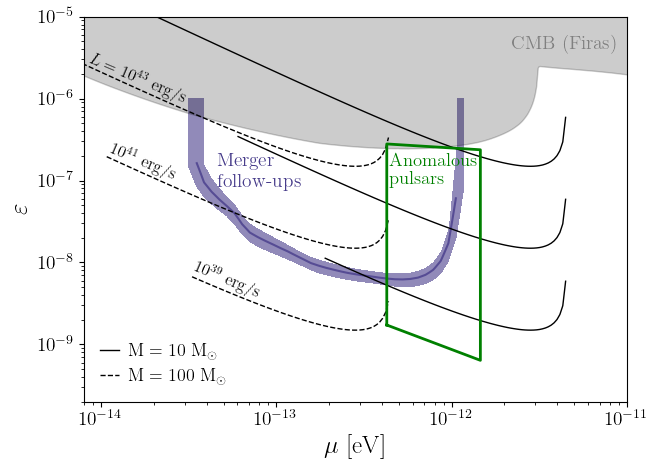

In [264]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist =  ['darkslateblue', 'firebrick', 'orange', 'green'] #['teal', 'orange', 'indianred']
liestyle_list = ['solid', 'dashed', 'dashdot']
font_s = 16


n_event = 1
ax.contourf(mu_list/eV, eps_list, np.log10(Nevt_array[:, :, 2]).T, levels=[np.log10(n_event), 100], colors='darkslateblue', alpha=0.6) #, colors='k')
ax.contour(mu_list/eV, eps_list, np.log10(Nevt_array[:, :, 0]).T, levels=[np.log10(n_event)], colors='darkslateblue', alpha=0.8) #, colors='k')
ax.contourf(mu_list/eV, eps_list, np.log10(Nevt_array[:, :, 1]).T, levels=[np.log10(n_event), 100], colors='white') #, colors='k')

level_list = [39, 41, 43] #np.arange(34, 44, 1)

contours = ax.contour(mu_list_lum/eV, eps_list_lum, np.log10(em_lum_array[0]/(erg/Second)),
                      levels=level_list, colors='k', linewidths=1)
contours2 = ax.contour(mu_list_lum/eV, eps_list_lum, np.log10(em_lum_array[1]/(erg/Second)),
                      levels=level_list, colors='k', linestyles='dashed', linewidths=1)


line1, = ax.plot([1, 2, 3], label=r'$\mathrm{M} = 10\ \mathrm{M}_{\odot}$', c='k', linewidth=1)
line2, = ax.plot([1, 2, 3], label=r'$\mathrm{M} = 100\ \mathrm{M}_{\odot}$', c='k', linewidth=1, linestyle='dashed')
ax.legend(handles=[line1, line2], loc='lower left', frameon=False, handlelength=1, handletextpad=0.5,fontsize=13)
#line1.set_visible(False)
#ax.clabel(contours, inline=True, fontsize=10) #fmt=fmt, 

#xv, yv = np.meshgrid(mu_list_lum/eV, eps_list_lum)
#ax.plot(xv.reshape(len(mu_list_lum)*len(eps_list_lum)), yv.reshape(len(mu_list_lum)*len(eps_list_lum)), '.', c='k', markersize=0.5)

ax.plot(points_x, points_y, c=colorlist[3], markersize=10, linewidth=2, alpha=1)

ax.fill_between(dp_limits[:, 0], dp_limits[:, 1], 1, color='k', alpha=0.2)

ax.set_xscale('log');  ax.set_yscale('log');
ax.set_xlim(8e-15, 1e-11); ax.set_ylim(2e-10,1e-5);

ax.set_xlabel(r'$\mu\ [\rm{eV}]$', fontsize=18)
ax.set_ylabel(r'$\varepsilon$', fontsize=18);

#ax.text(1e-14, 3.8e-8, r'$L = 10^{41}\ \mathrm{erg}/\mathrm{s}$', fontsize=12, rotation=-21)
#ax.text(5.5e-14, 3e-10, r'$L = 10^{38}\ \mathrm{erg}/\mathrm{s}$', fontsize=12, rotation=-16)
ax.text(0.83e-14, 0.9e-6, r'$L = 10^{43}\ \mathrm{erg}/\mathrm{s}$', fontsize=12, rotation=-23)
ax.text(1.1e-14, 1.02e-7, r'$10^{41}\ \mathrm{erg}/\mathrm{s}$', fontsize=12, rotation=-23)
ax.text(3.3e-14, 3.8e-9, r'$10^{39}\ \mathrm{erg}/\mathrm{s}$', fontsize=12, rotation=-23)
ax.text(4.4e-13, 1.5e-7, r'Anomalous', fontsize=13.5, rotation=0, color=colorlist[3])
ax.text(4.4e-13, 0.9e-7, r'pulsars', fontsize=13.5, rotation=0, color=colorlist[3])
ax.text(2.2e-12, 4e-6, r'CMB (Firas)', fontsize=14, rotation=0, color='gray')
ax.text(4.6e-14, 1.5e-7, r'Merger', fontsize=14, rotation=0, color='darkslateblue');
ax.text(4.6e-14, 0.83e-7, r'follow-ups', fontsize=14, rotation=0, color='darkslateblue');
#ax.text(1.2e-13, 9e-9, r'1 event/y', fontsize=14, rotation=-18)
#[ax.text(1e-14, 10**(-9.5-i*0.3), r'M =\ '+str([10, 100][i])+' $\mathrm{M}_{\odot}$', fontsize=font_s, color=colorlist[i]) for i in range(len(Mbh0_list_lum))];

fig.savefig('plots/eps_mu.pdf', bbox_inches="tight")

<ipython-input-15-c32fa5e9cb96>:9: RuntimeWarning: divide by zero encountered in log10
  contours = ax.contour(mu_list_lum/myu.eV, eps_list_lum, np.log10(em_lum_array[0]/(myu.erg/myu.Second)),
<ipython-input-15-c32fa5e9cb96>:11: RuntimeWarning: divide by zero encountered in log10
  contours2 = ax.contour(mu_list_lum/myu.eV, eps_list_lum, np.log10(em_lum_array[1]/(myu.erg/myu.Second)),


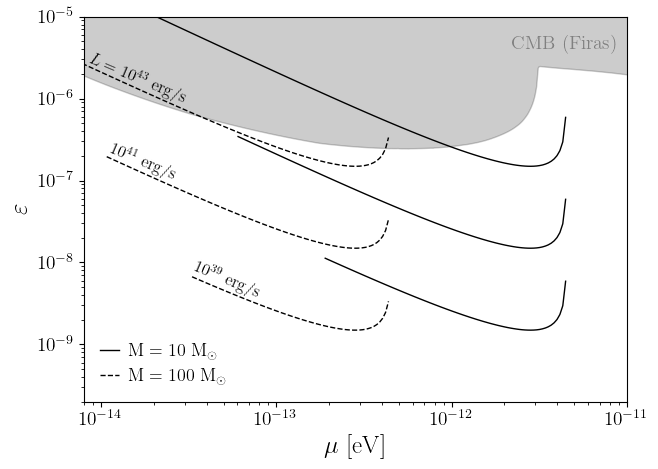

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist =  ['darkslateblue', 'firebrick', 'orange', 'green'] #['teal', 'orange', 'indianred']
liestyle_list = ['solid', 'dashed', 'dashdot']
font_s = 16


level_list = [39, 41, 43] #np.arange(34, 44, 1)

contours = ax.contour(mu_list_lum/eV, eps_list_lum, np.log10(em_lum_array[0]/(erg/Second)),
                      levels=level_list, colors='k', linewidths=1)
contours2 = ax.contour(mu_list_lum/eV, eps_list_lum, np.log10(em_lum_array[1]/(erg/Second)),
                      levels=level_list, colors='k', linestyles='dashed', linewidths=1)


line1, = ax.plot([1, 2, 3], label=r'$\mathrm{M} = 10\ \mathrm{M}_{\odot}$', c='k', linewidth=1)
line2, = ax.plot([1, 2, 3], label=r'$\mathrm{M} = 100\ \mathrm{M}_{\odot}$', c='k', linewidth=1, linestyle='dashed')
ax.legend(handles=[line1, line2], loc='lower left', frameon=False, handlelength=1, handletextpad=0.5,fontsize=13)
#line1.set_visible(False)
#ax.clabel(contours, inline=True, fontsize=10) #fmt=fmt, 

#xv, yv = np.meshgrid(mu_list_lum/eV, eps_list_lum)
#ax.plot(xv.reshape(len(mu_list_lum)*len(eps_list_lum)), yv.reshape(len(mu_list_lum)*len(eps_list_lum)), '.', c='k', markersize=0.5)


ax.fill_between(dp_limits[:, 0], dp_limits[:, 1], 1, color='k', alpha=0.2)

ax.set_xscale('log');  ax.set_yscale('log');
ax.set_xlim(8e-15, 1e-11); ax.set_ylim(2e-10,1e-5);

ax.set_xlabel(r'$\mu\ [\rm{eV}]$', fontsize=18)
ax.set_ylabel(r'$\varepsilon$', fontsize=18);

#ax.text(1e-14, 3.8e-8, r'$L = 10^{41}\ \mathrm{erg}/\mathrm{s}$', fontsize=12, rotation=-21)
#ax.text(5.5e-14, 3e-10, r'$L = 10^{38}\ \mathrm{erg}/\mathrm{s}$', fontsize=12, rotation=-16)
ax.text(0.83e-14, 0.9e-6, r'$L = 10^{43}\ \mathrm{erg}/\mathrm{s}$', fontsize=12, rotation=-23)
ax.text(1.1e-14, 1.02e-7, r'$10^{41}\ \mathrm{erg}/\mathrm{s}$', fontsize=12, rotation=-23)
ax.text(3.3e-14, 3.8e-9, r'$10^{39}\ \mathrm{erg}/\mathrm{s}$', fontsize=12, rotation=-23)
ax.text(2.2e-12, 4e-6, r'CMB (Firas)', fontsize=14, rotation=0, color='gray')
#ax.text(1.2e-13, 9e-9, r'1 event/y', fontsize=14, rotation=-18)
#[ax.text(1e-14, 10**(-9.5-i*0.3), r'M =\ '+str([10, 100][i])+' $\mathrm{M}_{\odot}$', fontsize=font_s, color=colorlist[i]) for i in range(len(Mbh0_list_lum))];

fig.savefig('plots/eps_mu_lum.pdf', bbox_inches="tight")

# Plots

## Strain vs BH mass

In [147]:
df_res['ligo_h'] = 10**np.interp(np.log10(2*df_res['f_obs'].to_numpy()), np.log10(ligo_h[:, 0]), np.log10(ligo_h[:, 1]))

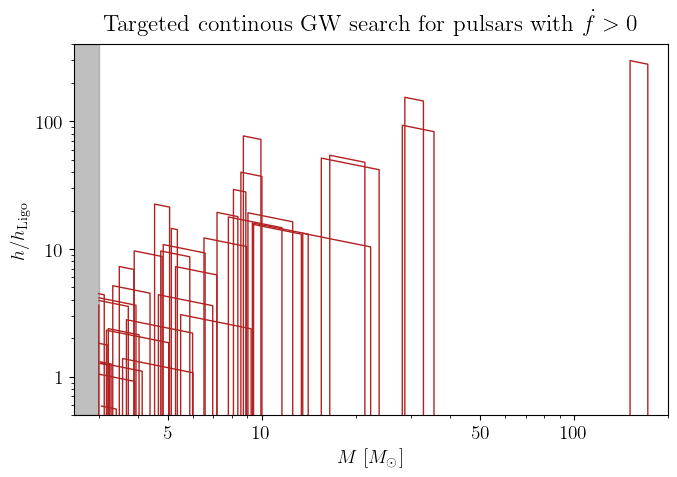

In [155]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist = ['darkslateblue', 'firebrick', 'green', 'orange']
liestyle_list = ['-.', 'solid']

#df_res_mbh = df_res[((df_res['Mbh'] > 3) &
#                     (df_res['strain']/df_res['ligo_h'] > 1))]
df_res_mbh = df_res[df_res['Mbh'] > 3]


for pul_i in range(len(df_pulsar)):

    ax.plot(df_res_mbh[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1]['Mbh'].to_numpy(), 
            df_res_mbh[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1]['strain'].to_numpy()/df_res_mbh[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1]['ligo_h'].to_numpy(), 
            '-', c='firebrick', linewidth=1);

ax.set_xlim(2.5, 200); ax.set_ylim(0.5, 400);
ax.set_title(r'Targeted continous GW search for pulsars with $\dot{f} > 0$', pad=10);
ax.set_xlabel(r'$M\ [M_\odot]$')
ax.set_ylabel(r'$h/h_{\rm{Ligo}}$');
#ax.axvline(x = 3, color = 'k', label = 'axvline - full height')
ax.axvspan(0, 3, alpha=0.5, color='gray')

ax.set_xscale('log');  ax.set_yscale('log');
ax.set_xticks([5, 10, 50, 100]); ax.set_yticks([1, 10, 100])
ax.set_xticklabels([5, 10, 50, 100]); ax.set_yticklabels([1, 10, 100]);

fig.tight_layout()
fig.savefig('plots/positive_fdot.pdf')

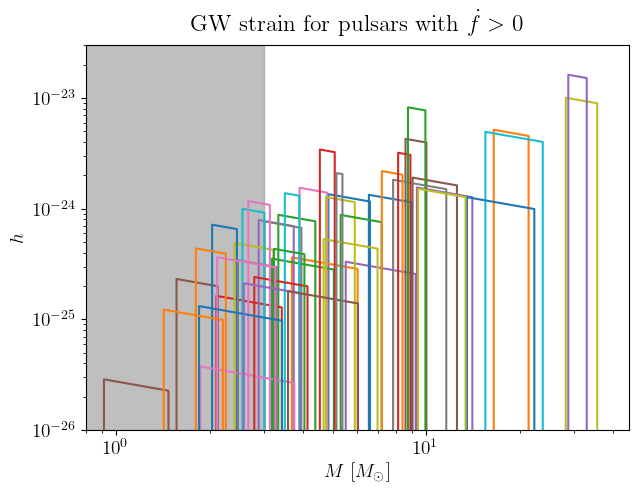

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist = ['darkslateblue', 'firebrick', 'green', 'orange']
liestyle_list = ['-.', 'solid']

for pul_i in range(len(df_pulsar)):

    ax.plot(df_res[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1]['Mbh'].to_numpy(), df_res[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1]['strain'].to_numpy(), '-');

ax.set_xlim(0.8, 45); ax.set_ylim(1e-26, (3e-23));
ax.set_title(r'GW strain for pulsars with $\dot{f} > 0$', pad=10);
ax.set_xlabel(r'$M\ [M_\odot]$')
ax.set_ylabel(r'$h$');
#ax.axvline(x = 3, color = 'k', label = 'axvline - full height')
ax.axvspan(0, 3, alpha=0.5, color='gray')

ax.set_xscale('log');  ax.set_yscale('log');

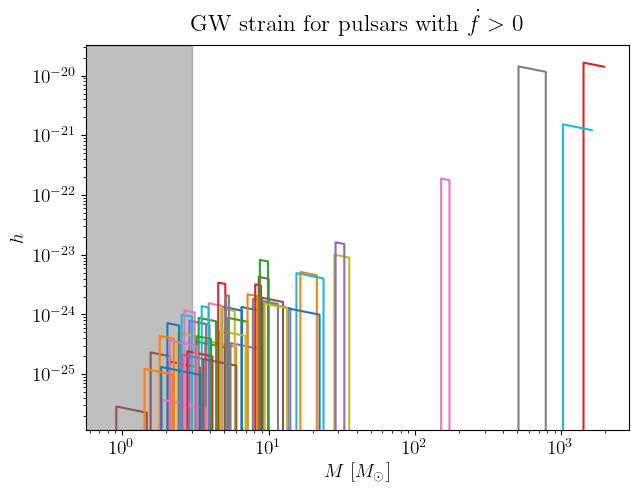

In [105]:
ith_pul = 1 ### Accesing the i_th pulsar

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist = ['darkslateblue', 'firebrick', 'green', 'orange']
liestyle_list = ['-.', 'solid']

for pul_i in range(len(df_pulsar)):

    ax.plot(df_res[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1]['Mbh'].to_numpy(), df_res[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1]['strain'].to_numpy(), '-');

#ax.set_xlim(0.8, 45); ax.set_ylim(1e-26, (3e-23));
ax.set_title(r'GW strain for pulsars with $\dot{f} > 0$', pad=10);
ax.set_xlabel(r'$M\ [M_\odot]$')
ax.set_ylabel(r'$h$');
#ax.axvline(x = 3, color = 'k', label = 'axvline - full height')
ax.axvspan(0, 3, alpha=0.5, color='gray')

ax.set_xscale('log');  ax.set_yscale('log');

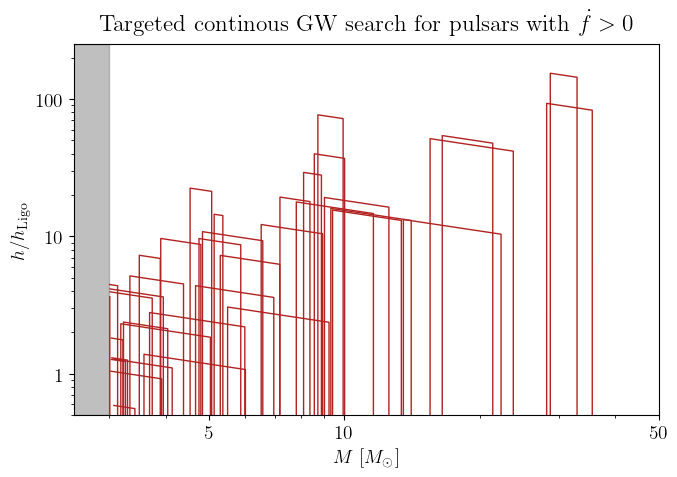

In [104]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist = ['darkslateblue', 'firebrick', 'green', 'orange']
liestyle_list = ['-.', 'solid']

#df_res_mbh = df_res[((df_res['Mbh'] > 3) &
#                     (df_res['strain']/df_res['ligo_h'] > 1))]
df_res_mbh = df_res[df_res['Mbh'] > 3]


for pul_i in range(len(df_pulsar)):

    ax.plot(df_res_mbh[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1]['Mbh'].to_numpy(), 
            df_res_mbh[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1]['strain'].to_numpy()/df_res_mbh[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1]['ligo_h'].to_numpy(), 
            '-', c='firebrick', linewidth=1);

ax.set_xlim(2.5, 50); ax.set_ylim(0.5, 250);
ax.set_title(r'Targeted continous GW search for pulsars with $\dot{f} > 0$', pad=10);
ax.set_xlabel(r'$M\ [M_\odot]$')
ax.set_ylabel(r'$h/h_{\rm{Ligo}}$');
#ax.axvline(x = 3, color = 'k', label = 'axvline - full height')
ax.axvspan(0, 3, alpha=0.5, color='gray')

ax.set_xscale('log');  ax.set_yscale('log');
ax.set_xticks([5, 10, 50]); ax.set_yticks([1, 10, 100])
ax.set_xticklabels([5, 10, 50]); ax.set_yticklabels([1, 10, 100]);

fig.tight_layout()
fig.savefig('plots/positive_fdot.pdf')

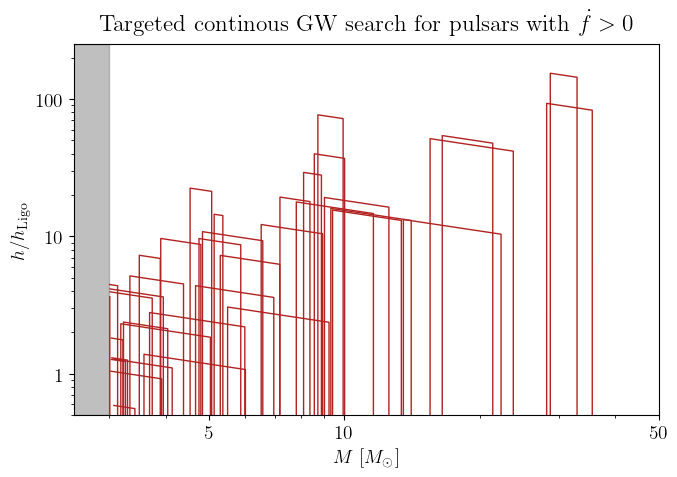

In [104]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist = ['darkslateblue', 'firebrick', 'green', 'orange']
liestyle_list = ['-.', 'solid']

#df_res_mbh = df_res[((df_res['Mbh'] > 3) &
#                     (df_res['strain']/df_res['ligo_h'] > 1))]
df_res_mbh = df_res[df_res['Mbh'] > 3]


for pul_i in range(len(df_pulsar)):

    ax.plot(df_res_mbh[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1]['Mbh'].to_numpy(), 
            df_res_mbh[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1]['strain'].to_numpy()/df_res_mbh[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1]['ligo_h'].to_numpy(), 
            '-', c='firebrick', linewidth=1);

ax.set_xlim(2.5, 50); ax.set_ylim(0.5, 250);
ax.set_title(r'Targeted continous GW search for pulsars with $\dot{f} > 0$', pad=10);
ax.set_xlabel(r'$M\ [M_\odot]$')
ax.set_ylabel(r'$h/h_{\rm{Ligo}}$');
#ax.axvline(x = 3, color = 'k', label = 'axvline - full height')
ax.axvspan(0, 3, alpha=0.5, color='gray')

ax.set_xscale('log');  ax.set_yscale('log');
ax.set_xticks([5, 10, 50]); ax.set_yticks([1, 10, 100])
ax.set_xticklabels([5, 10, 50]); ax.set_yticklabels([1, 10, 100]);

fig.tight_layout()
fig.savefig('plots/positive_fdot.pdf')

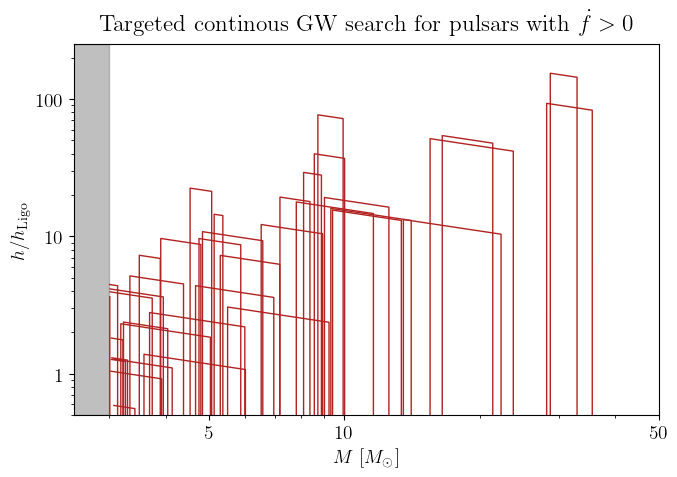

In [104]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist = ['darkslateblue', 'firebrick', 'green', 'orange']
liestyle_list = ['-.', 'solid']

#df_res_mbh = df_res[((df_res['Mbh'] > 3) &
#                     (df_res['strain']/df_res['ligo_h'] > 1))]
df_res_mbh = df_res[df_res['Mbh'] > 3]


for pul_i in range(len(df_pulsar)):
    
    ax.plot(df_res_mbh[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1]['Mbh'].to_numpy(), 
            df_res_mbh[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1]['strain'].to_numpy()/df_res_mbh[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1]['ligo_h'].to_numpy(), 
            '-', c='firebrick', linewidth=1);

ax.set_xlim(2.5, 50); ax.set_ylim(0.5, 250);
ax.set_title(r'Targeted continous GW search for pulsars with $\dot{f} > 0$', pad=10);
ax.set_xlabel(r'$M\ [M_\odot]$')
ax.set_ylabel(r'$h/h_{\rm{Ligo}}$');
#ax.axvline(x = 3, color = 'k', label = 'axvline - full height')
ax.axvspan(0, 3, alpha=0.5, color='gray')

ax.set_xscale('log');  ax.set_yscale('log');
ax.set_xticks([5, 10, 50]); ax.set_yticks([1, 10, 100])
ax.set_xticklabels([5, 10, 50]); ax.set_yticklabels([1, 10, 100]);

fig.tight_layout()
fig.savefig('plots/positive_fdot.pdf')

## Strain vs GW frequency

In [156]:
sp_strain = np.zeros(len(df_pulsar))

for pul_i in range(len(df_pulsar)):
    
    [f_obs, fdot_obs, dist] = df_pulsar.iloc[pul_i][['F0', 'F1', 'DIST']].to_numpy()    
    sp_strain[pul_i] = hsp_fn(2*f_obs, 2*fdot_obs, dist)

In [157]:
min(sp_strain)

2.271572412657966e-29

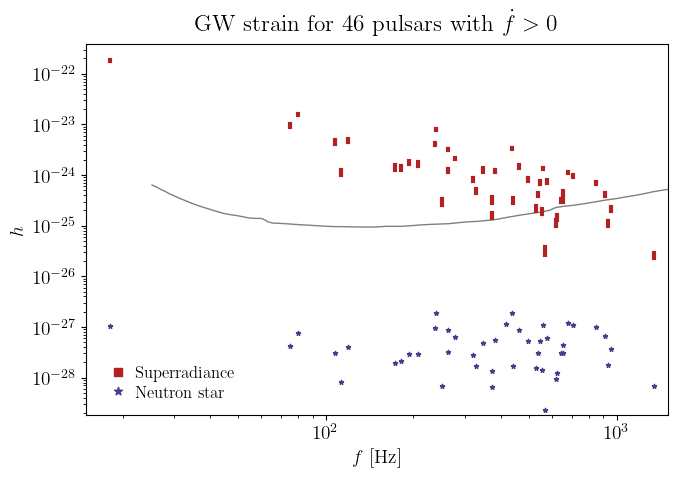

In [159]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))

ax.plot(ligo_h[:, 0], ligo_h[:, 1], '-', linewidth=1, c='gray');
list_max = np.zeros(len(df_pulsar))
count=0

for pul_i in range(len(df_pulsar)):
    
    if (df_pulsar.iloc[pul_i]['F0'] > 5): ### Remove the three pulsars with small frequency, which require Mbh > 1000 MSolar
        count=count+1
        min_h, max_h = min(df_res[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1]['strain'][df_res[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1]['strain']>0]), max(df_res[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1]['strain'])
        list_max[pul_i] = max_h
        #ax.scatter(2*df_pulsar.iloc[pul_i]['F0'], min_h + (max_h-min_h)/2, s=15,  marker="*", c='firebrick')
        ax.plot((2*df_pulsar.iloc[pul_i]['F0'],2*df_pulsar.iloc[pul_i]['F0']),(min_h, max_h), linewidth=3, c='firebrick', alpha=1)
        ax.scatter(2*df_pulsar.iloc[pul_i]['F0'], sp_strain[pul_i], s=10,  alpha=1, marker="*", c='darkslateblue')
        #ax.bar(2*df_pulsar.iloc[pul_i]['F0'], height=max_h, width=500/(2*df_pulsar.iloc[pul_i]['F0']), bottom=min_h)
        #ax.axvline(2*df_pulsar.iloc[pul_i]['F0'], ymin=0, ymax=1, linewidth=2)

p = [plt.scatter([0, 10], [0, 0], marker='s', c='firebrick'), plt.scatter([0, 10], [0, 0], marker="*", alpha=1, c='darkslateblue')]
ax.legend(p, [r'Superradiance', r'Neutron star', ], loc='lower left', frameon=False, labelspacing=0.1, fontsize=12, handletextpad=0.01, handleheight=1);
[p[i].set_visible(False) for i in range(len(p))]

ax.set_xscale('log');  ax.set_yscale('log');
ax.set_xlim(15, 1500); ax.set_ylim(0.8*min(sp_strain), 2*max(list_max))

ax.set_title(r'GW strain for '+str(count)+' pulsars with $\dot{f} > 0$', pad=10);
ax.set_xlabel(r'$f\ [\rm{Hz}]$')
ax.set_ylabel(r'$h$');

fig.tight_layout()
fig.savefig('plots/positive_fdot_hvsf.pdf')

## Maximal value of epsilon

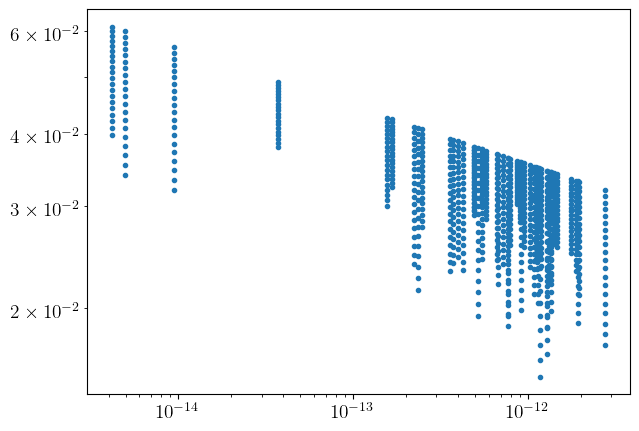

In [119]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))

ax.plot(df_res['mu'].to_numpy(), df_res['alpha'].to_numpy(), '.')
ax.set_xscale('log');  ax.set_yscale('log');


In [134]:
min_eps_pair_list = np.zeros(len(df_res))

for i in range(len(df_res)):
    
    mu = df_res.iloc[i]['mu']*eV
    alpha = df_res.iloc[i]['alpha']

    func = lambda log_eps : Gamma_pair_fn(10**log_eps, mu, alpha, abh0)/(alpha*mu) - 1  

    eps_start = 1/(ElectronCharge*alpha**(5/2)*np.sqrt(delta_as_fn(abh0, alpha)))*MElectron/MPlanck*np.sqrt(2*MElectron/mu)

    min_eps_pair_list[i] = 10**fsolve(func, np.log10(eps_start))[0]

In [138]:
df_res_largef = df_res[( (df_res['f_obs'].to_numpy() > 5) & (df_res['powGW'].to_numpy()>0) )]

In [139]:
### Check the maximum value of epsilon that allows P_EM < fracion*P_GW 
fraction = 0.01

eps_max = np.sqrt(fraction*df_res_largef['powGW'].to_numpy()*Watt/(erg/Second)/(df_res_largef['EM_lum_eps6'].to_numpy()))*1e-6

In [140]:
mu_list = 2*np.pi*df_res_largef['f_obs'].to_numpy()*Hz/eV

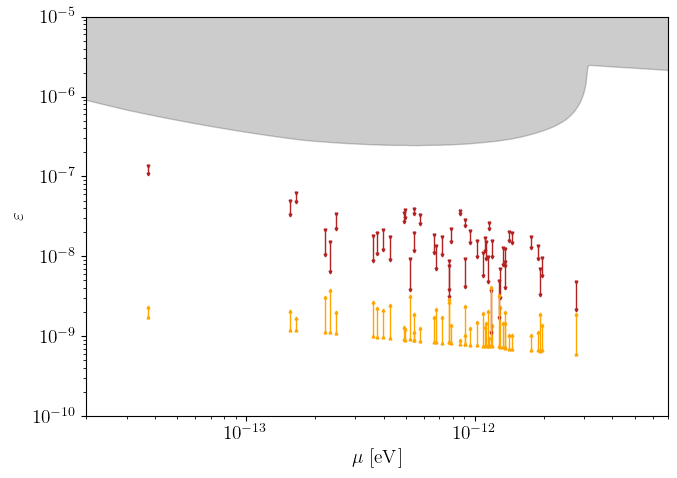

In [277]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))

for pul_i in range(len(df_pulsar)):
    
    f0 = df_pulsar.iloc[pul_i]['F0']
    if (f0 > 5): ### Remove the three pulsars with small frequency, which require Mbh > 1000 MSolar

        good_alphas = df_res.iloc[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1]['powGW'].to_numpy() > 0

        df_pul_i = df_res.iloc[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1][good_alphas]
        eps_max_i = np.sqrt(fraction*df_pul_i['powGW'].to_numpy()*Watt/(erg/Second)/df_pul_i['EM_lum_eps6'].to_numpy())*1e-6
        min_eps, max_eps = min(eps_max_i), max(eps_max_i)
        
        min_eps_pair, max_eps_pair = min(min_eps_pair_list[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1][good_alphas]), max(min_eps_pair_list[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1][good_alphas])
        
        ax.plot((2*np.pi*f0*Hz/eV, 2*np.pi*f0*Hz/eV),(min_eps, max_eps), marker='v', markersize=2,  linewidth=1, c='firebrick', alpha=1)
        ax.plot((2*np.pi*f0*Hz/eV, 2*np.pi*f0*Hz/eV),(min_eps_pair, max_eps_pair), marker='^', markersize=2,  linewidth=1, c='orange', alpha=1)
        

#x_test = np.logspace(-14, -11)
#ax.plot(x_test, 2e-9*np.sqrt(1e-13)/np.sqrt(x_test))
        
ax.fill_between(dp_limits[:, 0], dp_limits[:, 1], 1, color='k', alpha=0.2)
ax.set_xscale('log');  ax.set_yscale('log');
ax.set_xlim(2e-14, 7e-12); ax.set_ylim(1e-10,1e-5);

#ax.set_title(r'GW strain for '+str(count)+' pulsars with $\dot{f} > 0$', pad=10);
ax.set_xlabel(r'$\mu\ [\rm{eV}]$')
ax.set_ylabel(r'$\varepsilon$');

fig.tight_layout()
fig.savefig('plots/epsilon_allowed.pdf')

In [115]:
obs_lumi = df_pulsar['R_LUM14'].to_numpy()*1400*Hz*(0.001*Jy*(kpc**2))/(erg/Second)

for pul_i in range(len(df_pulsar)):
    
    f0 = df_pulsar.iloc[pul_i]['F0']
    if (f0 > 5): ### Remove the three pulsars with small frequency, which require Mbh > 1000 MSolar

        good_alphas = df_res.iloc[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1]['powGW'].to_numpy() > 0
        
        df_pul_i = df_res.iloc[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1][good_alphas]
        
        min_eps_pair = min_eps_pair_list[(pul_i)*alpha_points:(pul_i+1)*alpha_points-1][good_alphas]
        
        eps_max_i = np.sqrt(fraction*df_pul_i['powGW'].to_numpy()*Watt/(erg/Second)/df_pul_i['EM_lum_eps6'].to_numpy())*1e-6

        print(pul_i, max(eps_max_i**2/1e-12*df_pul_i['EM_lum_eps6'].to_numpy()/obs_lumi[pul_i]), max(min_eps_pair**2/1e-12*df_pul_i['EM_lum_eps6'].to_numpy()/obs_lumi[pul_i])) 

0 1.200308403511106e+19 3.2987650640156212e+16
1 1.4851558679731607e+18 7.510154917970805e+16
2 nan nan
3 nan nan
4 nan nan
5 3.125403592401962e+18 1.92461409602388e+16
6 nan nan
7 nan nan
8 nan nan
9 nan nan
10 nan nan
11 nan nan
12 nan nan
14 7.850803978728311e+18 5.670125739237246e+17
15 2.7285996076370055e+19 8.27021342717378e+16
16 5.835786230571476e+17 8.311254281899113e+17
17 5.656536259934208e+19 2.0023233060178074e+17
18 1.665144815337022e+19 1.3840988360435564e+16
19 5.549337235552187e+19 1.0812489215304326e+16
20 1.1574541065526112e+19 3.098663646428361e+16
21 nan nan
22 nan nan
23 nan nan
24 3.347833384475656e+18 3.0749597757491376e+16
25 nan nan
26 nan nan
27 2.8619221194306616e+18 2.1441441137865492e+16
28 nan nan
29 5.6902601070252384e+19 5.339332158138203e+17
30 8.319479793279345e+18 2.914400630692555e+17
31 2.91352568810614e+20 7.299367824244867e+16
32 1.2657027378974782e+20 1.607840114389841e+17
33 nan nan
34 nan nan
35 4.566518687744331e+16 3706538031893649.0
36 1.45

## Money plot

In [18]:
dp_limits = np.loadtxt('pulsar_data/DPlimits.txt')

### Ligo mergers followups

In [5]:
Mbh_list = np.array([63, 17.8, 25.6])
abh0_list = np.array([0.69, 0.69, 0.28])
d_list = np.array([430, 320, 241]) # Mpc
GWevent_list = np.array(['GW150914', 'GW170608', 'GW190814'])

In [7]:
Mbh_list*MSolar*GN*8*1e-14*eV

array([0.03755497, 0.01061077, 0.01526043])

In [582]:
n_points1, n_points2 = 8, 30 #np.logspace(-13.045, -12.3, n_points)
mu_list = np.array([np.append(np.append(np.logspace(-13.55, -13.2, 4), np.logspace(-13.108, -13.02, n_points1)), 
                              np.append(np.logspace(-12.85, -12.52, 4), np.logspace(-12.5, -12.3, n_points2))),
                    np.append(np.append(np.logspace(-13.55, -12.65, 4), np.logspace(-12.63, -12.54, n_points1)), 
                              np.append(np.logspace(-12.3, -12, 4), np.logspace(-12, -11.75, n_points2))),
                    np.append(np.logspace(-13.55, -12.65, 4), np.logspace(-12.63, -12.38, n_points1+4+n_points2))])

eps_pair_1y = 0.1+np.zeros((len(Mbh_list), len(mu_list[0])))
t_cutoff = 5*Year

flux_th = 3.2e-15*erg/(Second*CentiMeter**2) ## X-ray flux sensitivity
eps_xray = 1+np.zeros((len(Mbh_list), len(mu_list[0])))

tauGW_list, hGW_list, fGW_list = np.zeros((len(Mbh_list), len(mu_list[0]))), np.zeros((len(Mbh_list), len(mu_list[0]))), np.zeros((len(Mbh_list), len(mu_list[0])))
powEM_list, powGW_list = np.zeros((len(Mbh_list), len(mu_list[0]))), np.zeros((len(Mbh_list), len(mu_list[0])))

for i_event in tqdm(range(len(Mbh_list))):
    
    Mbh = Mbh_list[i_event]*MSolar
    a_star = abh0_list[i_event]
    dist = d_list[i_event]*Mpc

    Mbh0 = Mbh_list[i_event]   
    abh0 = abh0_list[i_event]
    dMpc = d_list[i_event]

    for i, mu in enumerate(mu_list[i_event]):   

        mu_eV = mu*eV    
        alpha = mu_eV*Mbh*GN

        #print(Mbh0, alpha)

        bc = ub.UltralightBoson(spin=1, model="relativistic") 

        try:
            wf = bc.make_waveform(Mbh0, abh0, alpha, units="physical+alpha")
        except ValueError:
            break 
        
        if wf.azimuthal_num()==1:
            
            t_sat = wf.cloud_growth_time()*Second

            tauGW_list[i_event, i] = wf.gw_time()
            hGW_list[i_event, i] = wf.strain_char(0, dObs=dMpc)
            fGW_list[i_event, i] = wf.freq_gw(0)
            
            Mc_sat = wf.mass_cloud(0)*MSolar
            eps_xray[i_event, i] = np.sqrt(flux_th*(4*np.pi*dist**2)/EM_lum(1, alpha, Mc_sat, Mbh))
            powEM_list[i_event, i] = EM_lum(1, alpha, Mc_sat, Mbh)
            powGW_list[i_event, i] = wf.power_gw(0)

            if (t_cutoff > t_sat):
                Mc = wf.mass_cloud(0)*MSolar
                Nocc = Mc/mu_eV

                ### Compute the minimum value of epsilon allowed when the cloud reaches saturation
                func = lambda log_eps : Gamma_pair_fn(10**log_eps, mu_eV, alpha, Nocc)/(alpha*mu_eV) - 1  

                eps_start = 1/(ElectronCharge*alpha**(3/2))*(MElectron/mu_eV)**(3/2)/np.sqrt(Nocc)

                #eps_start = 1/(ElectronCharge*alpha**(5/2)*np.sqrt(delta_as_fn(a_star, alpha)))*MElectron/MPlanck*np.sqrt(2*MElectron/mu_eV)
                eps_pair_1y[i_event, i] = 10**fsolve(func, np.log10(eps_start))[0]   

            else:
                Mc = wf.mass_cloud((-t_sat+t_cutoff)/Second)*MSolar
                Nocc = Mc/mu_eV

                eps_start = 1/(ElectronCharge*alpha**(3/2))*(MElectron/mu_eV)**(3/2)/np.sqrt(Nocc)

                ### Compute the minimum value of epsilon allowed when the cloud reaches saturation
                func = lambda log_eps : Gamma_pair_fn(10**log_eps, mu_eV, alpha, Nocc)/(alpha*mu_eV) - 1  

                if eps_start > 1e-5:
                    eps_pair_1y[i_event, i] = 1
                else:
                    eps_pair_1y[i_event, i] = 10**fsolve(func, np.log10(eps_start))[0]    
                

  0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-582-6e03c970c999>:59: RuntimeWarning: overflow encountered in power
  func = lambda log_eps : Gamma_pair_fn(10**log_eps, mu_eV, alpha, Nocc)/(alpha*mu_eV) - 1
100%|██████████| 3/3 [13:48<00:00, 276.05s/it]


In [646]:
### Save results
#np.save('lists/eps_pair_1y.npy', eps_pair_1y)
#np.save('lists/eps_xray.npy', eps_xray)
#np.save('lists/tauGW_list.npy', tauGW_list)
#np.save('lists/hGW_list.npy', hGW_list)
#np.save('lists/fGW_list.npy', fGW_list)
#np.save('lists/powEM_list.npy', powEM_list)
#np.save('lists/powGW_list.npy', powGW_list)

In [647]:
n_points1, n_points2 = 8, 30 #np.logspace(-13.045, -12.3, n_points)
mu_list = np.array([np.append(np.append(np.logspace(-13.55, -13.2, 4), np.logspace(-13.108, -13.02, n_points1)), 
                              np.append(np.logspace(-12.85, -12.52, 4), np.logspace(-12.5, -12.3, n_points2))),
                    np.append(np.append(np.logspace(-13.55, -12.65, 4), np.logspace(-12.63, -12.54, n_points1)), 
                              np.append(np.logspace(-12.3, -12, 4), np.logspace(-12, -11.75, n_points2))),
                    np.append(np.logspace(-13.55, -12.65, 4), np.logspace(-12.63, -12.38, n_points1+4+n_points2))])

t_cutoff = 5*Year
flux_th = 3.2e-15*erg/(Second*CentiMeter**2) ## X-ray flux sensitivity


eps_pair_1y = np.load('lists/eps_pair_1y.npy')
eps_xray = np.load('lists/eps_xray.npy')
tauGW_list = np.load('lists/tauGW_list.npy') 
hGW_list = np.load('lists/hGW_list.npy')
fGW_list = np.load('lists/fGW_list.npy')
powEM_list = np.load('lists/powEM_list.npy')
powGW_list = np.load('lists/powGW_list.npy')

In [652]:
tauGW_list*Second/Hour, (tauGW_list*Second/Hour)[tauGW_list*Second/Hour < 1]

(array([[2.99966229e+12, 1.66405533e+11, 9.40301835e+09, 5.43970913e+08,
         5.86892645e+07, 4.33644590e+07, 3.20549478e+07, 2.37053831e+07,
         1.75385903e+07, 1.29820528e+07, 9.61387330e+06, 7.12303821e+06,
         1.30507272e+05, 1.05218843e+04, 9.21344147e+02, 9.37510321e+01,
         6.38245751e+01, 5.61049273e+01, 4.94292328e+01, 4.36570367e+01,
         3.86680614e+01, 3.43595089e+01, 3.06438137e+01, 2.74468143e+01,
         2.47063355e+01, 2.23712085e+01, 2.02577118e+01, 1.85970155e+01,
         1.74550397e+01, 1.65103896e+01, 1.57848234e+01, 1.54822426e+01,
         1.58880203e+01, 1.71349477e+01, 1.99501842e+01, 2.92942539e+01,
         1.03788212e+02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00],
        [7.96472159e+17, 4.23551254e+14, 2.38464344e+11, 1.49712915e+08,
         9.21129957e+07, 6.74413076e+07, 4.93968481e+07, 3.61947151e+07,
         

In [653]:
hGW_ratio = hGW_list/10**np.interp(fGW_list, np.log10(ligo_h[:, 0]), np.log10(ligo_h[:, 1]))
hGW_ratio>1

array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True,  True,  True,  True,  True,
         True,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, Fa

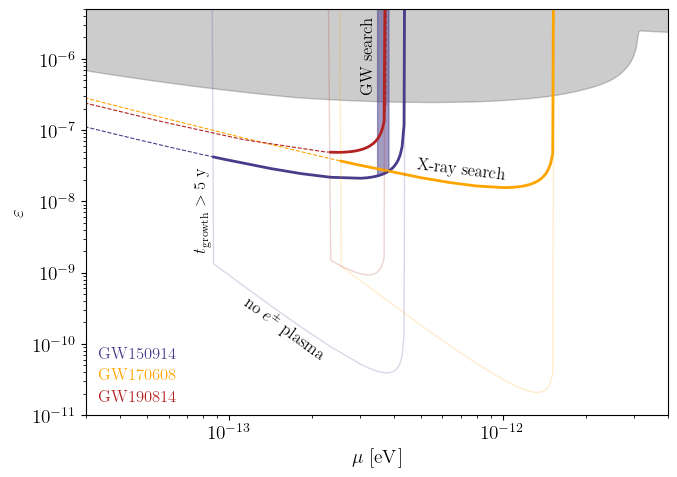

In [665]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist =  ['darkslateblue', 'orange', 'firebrick'] #['teal', 'orange', 'indianred']
liestyle_list = ['solid', '--']

ax.fill_between(dp_limits[:, 0], dp_limits[:, 1], 1, color='k', alpha=0.2)

for i_event in range(len(Mbh_list)):
    ax.plot(mu_list[i_event][eps_pair_1y[i_event] < 1], eps_xray[i_event][eps_pair_1y[i_event] < 1], linestyle=liestyle_list[0], linewidth=2, color=colorlist[i_event])
    #ax.plot(mu_list[i_event], eps_xray[i_event], linestyle=liestyle_list[0], linewidth=2, color=colorlist[i_event])
    #ax.plot(mu_list[i_event], eps_xray[i_event], marker='.')
    
#ax.legend([GWevent_list[i] for i in range(len(Mbh_list))], #[GWevent_list[i]+r' ($M_{\rm{BH}} = $'+str(Mbh_list[i])+'$\ M_{\odot}, a^{*} = $'+str(abh0_list[i])+', d = '+str(d_list[i])+' Mpc)' for i in range(len(Mbh_list))], 
#          loc='lower left', frameon=False, labelspacing=0.3, fontsize=12, handletextpad=0, handlelength=0, markerscale=0, labelcolor='linecolor');

for i_event in range(len(Mbh_list)):
    #ax.plot(mu_list[i_event][eps_pair_1y[i_event] > 0.1], eps_xray[i_event][eps_pair_1y[i_event] > 0.1], linestyle=liestyle_list[1], linewidth=0.8, color=colorlist[i_event])
    ax.plot(mu_list[i_event], eps_xray[i_event], linestyle=liestyle_list[1], linewidth=0.8, color=colorlist[i_event])
    ax.plot(mu_list[i_event], eps_pair_1y[i_event], color=colorlist[i_event], linewidth=1, alpha=0.2)
    ax.fill_between(mu_list[i_event][hGW_ratio[i_event]>1], eps_xray[i_event][hGW_ratio[i_event]>1], 1, color=colorlist[i_event], alpha=0.5)

#ax.plot(mu_list_test[0], np.zeros(len(mu_list_test[1]))+1e-7, '.')
    
ax.text(7.5e-14, 2.2e-9, r'$t_{\rm{growth}} > 5$ y', fontsize=12, rotation='vertical')
ax.text(1.1e-13, 0.6e-10, r'no $e^{\pm}$ plasma', fontsize=12, rotation=-36)
ax.text(4.8e-13, 2e-8, r'X-ray search', fontsize=12, rotation=-7)
ax.text(3e-13, 3.5e-7, r'GW search', fontsize=12, rotation='vertical')
[ax.text(3.3e-14, 10**(-10.2-i*0.3), GWevent_list[i], fontsize=12, color=colorlist[i]) for i in range(len(Mbh_list))]

#for i_event in range(len(Mbh_list)):
#    ax.axvline(mu_list_1year[i_event]/eV, color=colorlist[i_event])
    
ax.set_xscale('log');  ax.set_yscale('log');
ax.set_xlim(3e-14, 4e-12); ax.set_ylim(1e-11,5e-6);

#ax.set_title(r'GW strain for '+str(count)+' pulsars with $\dot{f} > 0$', pad=10);
ax.set_xlabel(r'$\mu\ [\rm{eV}]$')
ax.set_ylabel(r'$\varepsilon$');

fig.tight_layout()
fig.savefig('plots/ligo_mergers.pdf')

In [580]:
mu_list_test = np.array([np.append(np.append(np.logspace(-13.55, -13.2, 4), np.logspace(-13.108, -13.02, n_points1)), 
                                   np.append(np.logspace(-12.85, -12.52, 4), np.logspace(-12.5, -12.3, n_points2))), 
                         np.append(np.append(np.logspace(-13.55, -12.65, 4), np.logspace(-12.63, -12.54, n_points1)), 
                                   np.append(np.logspace(-12.3, -12, 4), np.logspace(-12, -11.75, n_points2)))])

### Ligo mergers followups (OLD)

In [479]:
Mbh_list = np.array([63, 17.8, 25.6])
abh0_list = np.array([0.69, 0.69, 0.28])
d_list = np.array([430, 320, 241]) # Mpc
GWevent_list = np.array(['GW150914', 'GW170608', 'GW190814'])

In [480]:
n_points = 500
mu_list = np.array([np.logspace(-15, -12.2, n_points), np.logspace(-14, -11.8, n_points), np.logspace(-14, -11.8, n_points)])
eps_pair = 1+np.zeros((3, n_points))

for i_event in range(len(Mbh_list)):
    
    Mbh = Mbh_list[i_event]*MSolar
    a_star = abh0_list[i_event]
    
    for i, mu in enumerate(mu_list[i_event]):   
        
        mu_eV = mu*eV
        alpha = mu_eV*Mbh*GN

        ### Compute the minimum value of epsilon allowed when the cloud reaches saturation
        func = lambda log_eps : Gamma_pair_fn_approx(10**log_eps, mu_eV, alpha, a_star)/(alpha*mu_eV) - 1  

        if delta_as_fn(a_star, alpha)>0:
            eps_start = 1/(ElectronCharge*alpha**(5/2)*np.sqrt(delta_as_fn(a_star, alpha)))*MElectron/MPlanck*np.sqrt(2*MElectron/mu_eV)
            #print(i_event, i, eps_start, func(np.log10(eps_start)), 10**fsolve(func, np.log10(eps_start))[0]  )
            eps_pair[i_event, i] = 10**fsolve(func, np.log10(eps_start))[0]    


In [481]:
n_points = 500
mu_list = np.array([np.logspace(-15, -12.2, n_points), np.logspace(-14, -11.8, n_points), np.logspace(-14, -11.8, n_points)]) #np.array([np.logspace(-13.3, -12.3, n_points), np.logspace(-14, -11.8, n_points), np.logspace(-14, -11.8, n_points)])
eps_pair_1y = 1e-6+np.zeros((3, n_points))
t_cutoff = 1*Year

for i_event in range(len(Mbh_list)):
    
    Mbh = Mbh_list[i_event]*MSolar
    a_star = abh0_list[i_event]
    
    for i, mu in enumerate(mu_list[i_event]):   
        
        mu_eV = mu*eV
        alpha = mu_eV*Mbh*GN
        
        if delta_as_fn(a_star, alpha)>0:
            
            Gamma_sr = 4*a_star*alpha**6*mu_eV
            Nocc = delta_as_fn(a_star, alpha)*alpha**2/(GN*mu**2)
            t_sat = 1/Gamma_sr*np.log(Nocc)
            
            if (t_cutoff > t_sat):
                ### Compute the minimum value of epsilon allowed when the cloud reaches saturation
                func = lambda log_eps : Gamma_pair_fn_approx(10**log_eps, mu_eV, alpha, a_star)/(alpha*mu_eV) - 1  

                eps_start = 1/(ElectronCharge*alpha**(5/2)*np.sqrt(delta_as_fn(a_star, alpha)))*MElectron/MPlanck*np.sqrt(2*MElectron/mu_eV)
                eps_pair_1y[i_event, i] = 10**fsolve(func, np.log10(eps_start))[0]   
                
            else:
                #print(t_sat/(2/Gamma_sr))
                func = lambda log_eps : Gamma_pair_fn_approx(10**log_eps, mu_eV, alpha, a_star, t_cutoff)/(alpha*mu_eV) - 1  
                eps_start = 1/(ElectronCharge*alpha**(3/2))*(MElectron/mu_eV)**(3/2)*np.exp(-t_cutoff*Gamma_sr/2)
                #print(alpha, t_cutoff*Gamma_sr/2, 1/(ElectronCharge*alpha**(3/2))*(MElectron/mu_eV)**(3/2), np.exp(-t_cutoff*Gamma_sr/2), eps_start)
                
                if eps_start > 1e-5:
                    eps_pair_1y[i_event, i] = 1
                else:
                    eps_pair_1y[i_event, i] = 10**fsolve(func, np.log10(eps_start))[0]    
               
        else:
            eps_pair_1y[i_event, i] = 0.1

In [482]:
flux_th = 3.2e-15*erg/(Second*CentiMeter**2) ## X-ray flux sensitivity
eps_xray = 1+np.zeros((3, n_points))

for i_event in range(len(Mbh_list)):
    
    Mbh = Mbh_list[i_event]*MSolar    
    a_star = abh0_list[i_event]
    dist = d_list[i_event]*Mpc
    
    for i, mu in enumerate(mu_list[i_event]):   
        
        mu_eV = mu*eV
        alpha = mu_eV*Mbh*GN
        
        if(EM_lum_approx(1, alpha, a_star)>0):
            eps_xray[i_event, i] = np.sqrt(flux_th*(4*np.pi*dist**2)/EM_lum_approx(1, alpha, a_star))

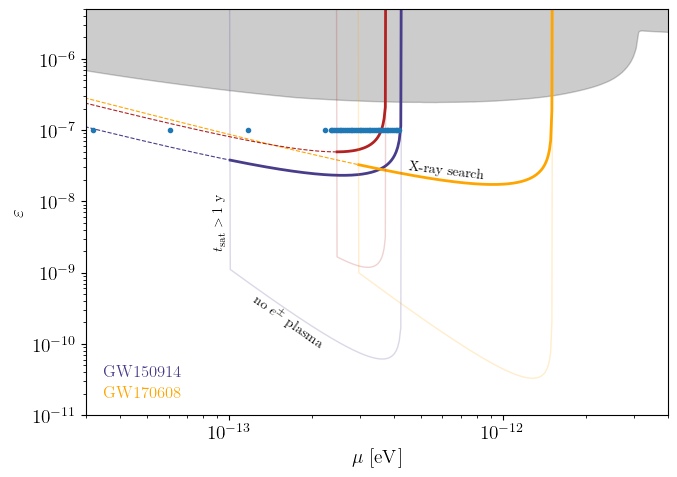

In [501]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist =  ['darkslateblue', 'orange', 'firebrick'] #['teal', 'orange', 'indianred']
liestyle_list = ['solid', '--']

ax.fill_between(dp_limits[:, 0], dp_limits[:, 1], 1, color='k', alpha=0.2)

for i_event in range(len(Mbh_list)):
    ax.plot(mu_list[i_event][eps_pair_1y[i_event] < 1], eps_xray[i_event][eps_pair_1y[i_event] < 1], linestyle=liestyle_list[0], linewidth=2, color=colorlist[i_event])
    
ax.legend([GWevent_list[i] for i in range(len(Mbh_list[:2]))], #[GWevent_list[i]+r' ($M_{\rm{BH}} = $'+str(Mbh_list[i])+'$\ M_{\odot}, a^{*} = $'+str(abh0_list[i])+', d = '+str(d_list[i])+' Mpc)' for i in range(len(Mbh_list))], 
          loc='lower left', frameon=False, labelspacing=0.3, fontsize=12, handletextpad=0.1, handlelength=0, labelcolor='linecolor');

for i_event in range(len(Mbh_list)):
    ax.plot(mu_list[i_event][eps_pair_1y[i_event] > 0.1], eps_xray[i_event][eps_pair_1y[i_event] > 0.1], linestyle=liestyle_list[1], linewidth=0.8, color=colorlist[i_event])
    #ax.fill_between(mu_list[i_event], eps_pair_1y[i_event], 1, color=colorlist[i_event], linewidth=1, alpha=0.0)
    ax.plot(mu_list[i_event], eps_pair_1y[i_event], color=colorlist[i_event], linewidth=1, alpha=0.2)
    #ax.plot(mu_list[i_event], eps_pair_10y[i_event], color=colorlist[i_event], linewidth=1, alpha=0.15)

ax.plot(mu_list_test[2], np.zeros(len(mu_list_test[1]))+1e-7, '.')
    
    
ax.text(8.7e-14, 2.2e-9, r'$t_{\rm{sat}} > 1$ y', fontsize=10, rotation='vertical')
#ax.text(6.18e-14, 4e-9, r'$t_{\rm{sat}} > 10$ y', fontsize=10, rotation='vertical')
ax.text(1.2e-13, 0.9e-10, r'no $e^{\pm}$ plasma', fontsize=10, rotation=-35)
ax.text(4.5e-13, 2.1e-8, r'X-ray search', fontsize=10, rotation=-7)
  
#for i_event in range(len(Mbh_list)):
#    ax.axvline(mu_list_1year[i_event]/eV, color=colorlist[i_event])
    
ax.set_xscale('log');  ax.set_yscale('log');
ax.set_xlim(3e-14, 4e-12); ax.set_ylim(1e-11,5e-6);

#ax.set_title(r'GW strain for '+str(count)+' pulsars with $\dot{f} > 0$', pad=10);
ax.set_xlabel(r'$\mu\ [\rm{eV}]$')
ax.set_ylabel(r'$\varepsilon$');

fig.tight_layout()
#fig.savefig('plots/ligo_mergers.pdf')

In [500]:
mu_list_test = np.array([np.append(np.append(np.logspace(-13.5, -12.97, 4), np.logspace(-12.95, -12.85, n_points1)), 
                                   np.append(np.logspace(-12.85, -12.52, 4), np.logspace(-12.5, -12.3, n_points2))), 
                         np.append(np.append(np.logspace(-13.5, -12.5, 4), np.logspace(-12.47, -12.41, n_points1)), 
                                   np.append(np.logspace(-12.3, -12, 4), np.logspace(-12, -11.75, n_points2))),
                         np.append(np.logspace(-13.5, -12.65, 4), np.logspace(-12.63, -12.38, n_points1+4+n_points2))])


In [381]:
### Compute some SR growth times

tauSR_list, tauGW_list = np.zeros(len(Mbh_list)), np.zeros(len(Mbh_list))
tauSR_list_approx, tauGW_list_approx = np.zeros(len(Mbh_list)), np.zeros(len(Mbh_list))
tau_efold = 3600*Second #24*3600*Second


mu_list_1year = (1/(4*abh0_list*tau_efold))**(1/7)/(GN*Mbh_list*MSolar)**(6/7)*np.array([0.79922563, 0.73658688, 1.83788685])**(1/6) #np.array([1e-13, 5e-13, 1e-13]) #np.array([3e-13, 1e-12, 2.5e-13]) #

for i_event in range(len(Mbh_list)):
    
    Mbh0 = Mbh_list[i_event]   
    abh0 = abh0_list[i_event]
    mu_approx = mu_list_1year[i_event]#(1/(4*abh0*tau_efold))**(1/7)/(GN*Mbh0*MSolar)**(6/7) 
    
    alpha = Mbh0*MSolar*GN*mu_approx

    print(Mbh0, abh0, mu_approx, alpha)

    bc = ub.UltralightBoson(spin=1, model="relativistic") 
    bc.make_waveform(Mbh0, abh0, alpha, units="physical+alpha")
    wf = bc.make_waveform(Mbh0, abh0, alpha, units="physical+alpha")

    tauSR_list[i_event] = wf.efold_time() #wf.cloud_growth_time()
    tauGW_list[i_event] = wf.gw_time()
    
    #print(wf.azimuthal_num())
    
    tauSR_list_approx[i_event] = 1/(4*abh0*alpha**6*mu_approx)/Second
    tauGW_list_approx[i_event] = 1/(60*alpha**10*mu_approx*delta_as_fn(abh0, alpha))/Second

63.0 0.69 1.7367023570288313e-22 0.08152725882377942
17.8 0.69 5.061988442228375e-22 0.06713949166458624
25.6 0.28 4.911172924388746e-22 0.09368328020174495


<ipython-input-381-c21e15ece302>:30: RuntimeWarning: divide by zero encountered in double_scalars
  tauGW_list_approx[i_event] = 1/(60*alpha**10*mu_approx*delta_as_fn(abh0, alpha))/myu.Second


In [382]:
tauSR_list, tauSR_list*Second/Hour

(array([9.15815510e+03, 9.08010836e+03, 3.01348434e+10]),
 array([2.54393197e+00, 2.52225232e+00, 8.37078984e+06]))

In [358]:
tauSR_list_approx*Second/Hour

array([27.47801569, 81.18741117, 67.63481475])

In [330]:
tauSR_list, tauSR_list*Second/Year

(array([1.16284132e+09, 5.96221385e+10, 2.40206194e+10]),
 array([  36.87345636, 1890.60561048,  761.68884382]))

In [320]:
tauSR_list/tauSR_list_approx, tauGW_list/tauGW_list_approx

(array([1.09140397, 1.06351024, 1.53867553]),
 array([2.80165337, 2.72743188, 2.719283  ]))

In [315]:
### Compute some SR growth times

mu_list = np.logspace(-14, -12.8, 10)
tauSR_list, tauSR_list_approx = np.zeros(len(mu_list)), np.zeros(len(mu_list))
tauGW_list, tauGW_list_approx = np.zeros(len(mu_list)), np.zeros(len(mu_list))

i_event=0

for i_mu in range(len(mu_list)):
    
    Mbh0 = Mbh_list[i_event]   
    abh0 = abh0_list[i_event]
    mu = mu_list[i_mu]*eV
    
    alpha = Mbh0*MSolar*GN*mu

    print(Mbh0, abh0, mu, alpha)

    bc = ub.UltralightBoson(spin=1, model="relativistic") 
    bc.make_waveform(Mbh0, abh0, alpha, units="physical+alpha")
    wf = bc.make_waveform(Mbh0, abh0, alpha, units="physical+alpha")

    tauSR_list[i_mu] = wf.efold_time() #wf.cloud_growth_time()
    tauGW_list[i_mu] = wf.gw_time()
    
    print(wf.azimuthal_num())
    
    tauSR_list_approx[i_mu] = 1/(4*abh0*alpha**6*mu)/Second
    tauGW_list_approx[i_mu] = 1/(60*alpha**10*mu*delta_as_fn(abh0, alpha))/Second

63.0 0.69 1.0000000000000001e-23 0.004694371404162606
1
63.0 0.69 1.359356390878524e-23 0.006381323769405829
1
63.0 0.69 1.847849797422287e-23 0.00867449324820685
1
63.0 0.69 2.5118864315095825e-23 0.011791727834582636
1
63.0 0.69 3.414548873833601e-23 0.016029160591440085
1
63.0 0.69 4.641588833612773e-23 0.021789341890392267
1
63.0 0.69 6.309573444801917e-23 0.029619481151741865
1
63.0 0.69 8.576958985908946e-23 0.04026343099812646
1
63.0 0.69 1.165914401179831e-22 0.05473235224599968
1
63.0 0.69 1.584893192461111e-22 0.0744007728134142
1


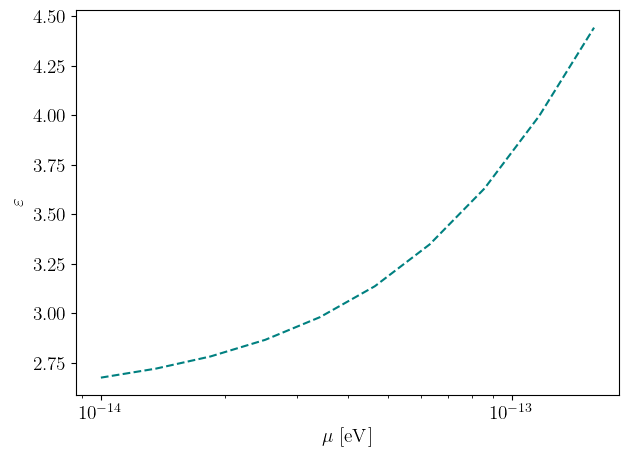

In [316]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist = ['teal', 'orange', 'indianred'] #darkslateblue, firebrick
liestyle_list = ['solid', '--']

#ax.plot(mu_list, tauSR_list/tauSR_list_approx, linestyle=liestyle_list[0], color=colorlist[i_event])
ax.plot(mu_list, tauGW_list/tauGW_list_approx, linestyle=liestyle_list[1], color=colorlist[i_event])

ax.set_xscale('log');  #ax.set_yscale('log');
#ax.set_xlim(1e-14, 4e-12); ax.set_ylim(5e-12,1e-5);

#ax.set_title(r'GW strain for '+str(count)+' pulsars with $\dot{f} > 0$', pad=10);
ax.set_xlabel(r'$\mu\ [\rm{eV}]$')
ax.set_ylabel(r'$\varepsilon$');

In [302]:
tauSR_list/tauSR_list_approx

array([3.17851131, 1.43492528, 4.62491885])

In [303]:
tauSR_list

array([   323.82293005, 287366.67834413, 257918.51444431])

In [297]:
tauGW_list/tauGW_list_approx

array([5.03822519, 3.61847329, 3.33105103])

In [186]:
a_star = 0.7
mu_list = np.logspace(-14, -11, 500)
eps_pair_10 = 1+np.zeros(len(mu_list))
eps_pair_100 = 1+np.zeros(len(mu_list))

Mbh = 10*MSolar
for i, mu in enumerate(mu_list):
    
    mu_eV = mu*eV
    alpha = mu_eV*Mbh*GN
    
    func = lambda log_eps : Gamma_pair_fn(10**log_eps, mu_eV, alpha, a_star)/(alpha*mu_eV) - 1  
    
    if delta_as_fn(a_star, alpha)>0:
        eps_start = 1/(ElectronCharge*alpha**(5/2)*np.sqrt(delta_as_fn(a_star, alpha)))*MElectron/MPlanck*np.sqrt(2*MElectron/mu_eV)
        eps_pair_10[i] = 10**fsolve(func, np.log10(eps_start))[0]    
    
Mbh = 100*MSolar
for i, mu in enumerate(mu_list[mu_list<1e-12]):
    
    mu_eV = mu*eV
    alpha = mu_eV*Mbh*GN
    
    func = lambda log_eps : Gamma_pair_fn(10**log_eps, mu_eV, alpha, a_star)/(alpha*mu_eV) - 1  
    
    if delta_as_fn(a_star, alpha)>0:
        eps_start = 1/(ElectronCharge*alpha**(5/2)*np.sqrt(delta_as_fn(a_star, alpha)))*MElectron/MPlanck*np.sqrt(2*MElectron/mu_eV)
        eps_pair_100[i] = 10**fsolve(func, np.log10(eps_start))[0]    


<ipython-input-78-cb0ef1c474c3>:10: RuntimeWarning: overflow encountered in power
  exp_factor = 4*myu.MElectron**6*mu**2/((myu.ElectronCharge*E_field)**4)
<ipython-input-186-627f390fe48a>:12: RuntimeWarning: overflow encountered in true_divide
  func = lambda log_eps : Gamma_pair_fn(10**log_eps, mu_eV, alpha, a_star)/(alpha*mu) - 1
<ipython-input-186-627f390fe48a>:12: RuntimeWarning: overflow encountered in power
  func = lambda log_eps : Gamma_pair_fn(10**log_eps, mu_eV, alpha, a_star)/(alpha*mu) - 1
<ipython-input-186-627f390fe48a>:24: RuntimeWarning: overflow encountered in true_divide
  func = lambda log_eps : Gamma_pair_fn(10**log_eps, mu_eV, alpha, a_star)/(alpha*mu) - 1
<ipython-input-186-627f390fe48a>:24: RuntimeWarning: overflow encountered in power
  func = lambda log_eps : Gamma_pair_fn(10**log_eps, mu_eV, alpha, a_star)/(alpha*mu) - 1


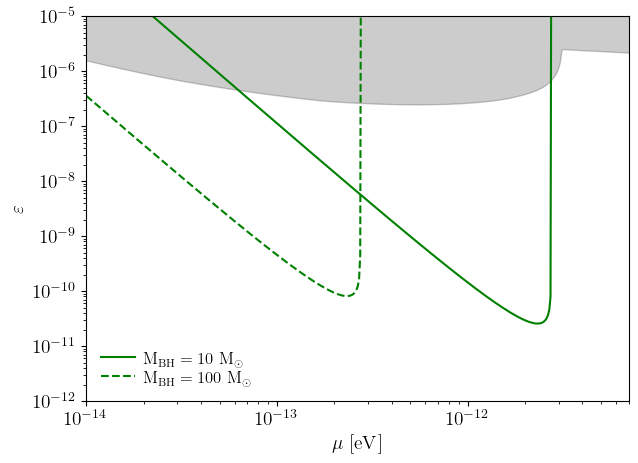

In [196]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))

ax.fill_between(dp_limits[:, 0], dp_limits[:, 1], 1, color='k', alpha=0.2)

ax.plot(mu_list, eps_pair_10, '-', color='green')
ax.plot(mu_list, eps_pair_100, '--', color='green')
ax.legend([r'$\rm{M}_{\rm{BH}} = 10\ \rm{M}_{\odot}$', r'$\rm{M}_{\rm{BH}} = 100\ \rm{M}_{\odot}$'], loc='lower left', 
          frameon=False, labelspacing=0.1, fontsize=12, handletextpad=0.5, handleheight=1);


ax.set_xscale('log');  ax.set_yscale('log');
ax.set_xlim(1e-14, 7e-12); ax.set_ylim(1e-12,1e-5);

#ax.set_title(r'GW strain for '+str(count)+' pulsars with $\dot{f} > 0$', pad=10);
ax.set_xlabel(r'$\mu\ [\rm{eV}]$')
ax.set_ylabel(r'$\varepsilon$');



## Cloud lifetime

In [598]:
alpha_list = np.logspace(-2.5,-0.48, 50) #np.logspace(-2.5,-0.72, 50)
tGW_list = np.zeros(len(alpha_list))

In [599]:
bc = ub.UltralightBoson(spin=1, model="relativistic") 

In [600]:
Mbh0, abh0 = 10, 0.9 #0.7

for i, alpha in tqdm(enumerate(alpha_list)):    
    try:
        wf = bc.make_waveform(Mbh0, abh0, alpha, units="physical+alpha")
    except ValueError:
        break 

    if wf.azimuthal_num()==1:
        tGW_list[i] = wf.gw_time()*Second

50it [00:01, 28.17it/s]


In [601]:
eps_list = np.logspace(-10, -6, 70)
tEM_array = np.zeros((len(eps_list), len(alpha_list)))

for i_a, alpha in enumerate(alpha_list): 
     for i_e, eps in enumerate(eps_list): 
        tEM_array[i_e, i_a] = np.log(2)*GN*Mbh0*MSolar/(eps**2*EM_lum_fit(alpha))

In [602]:
tGW_array = np.zeros((len(eps_list), len(alpha_list)))

for i_e, eps in enumerate(eps_list): 
    tGW_array[i_e, :] = tGW_list

In [332]:
def approx_eps_transition(alpha, a_star):
    return np.sqrt(np.log(2)/(EM_lum_fit(alpha))*60*alpha**11*delta_as_fn(a_star, alpha))

In [333]:
approx_eps_transition(alpha_list, abh0)

array([4.68198291e-12, 7.10886057e-12, 1.07931119e-11, 1.63858025e-11,
       2.48748655e-11, 3.77592322e-11, 5.73128631e-11, 8.69850177e-11,
       1.32006939e-10, 2.00311192e-10, 3.03924447e-10, 4.61076933e-10,
       6.99396393e-10, 1.06074248e-09, 1.60852142e-09, 2.43874897e-09,
       3.69677470e-09, 5.60255200e-09, 8.48879869e-09, 1.28585874e-08,
       1.94721965e-08, 2.94779832e-08, 4.46094135e-08, 6.74813862e-08,
       1.02035370e-07, 1.54207197e-07, 2.32927334e-07, 3.51616551e-07,
       5.30417693e-07, 7.99517911e-07, 1.20408016e-06, 1.81153898e-06,
       2.72235073e-06, 4.08575657e-06, 6.12275707e-06, 9.15934608e-06,
       1.36741233e-05, 2.03656464e-05, 3.02460762e-05, 4.47682157e-05,
       6.59915373e-05, 9.67860460e-05, 1.41053831e-04, 2.03901278e-04,
       2.91584233e-04, 4.10785841e-04, 5.66132744e-04, 7.53038895e-04,
       9.36729758e-04, 9.74877807e-04])

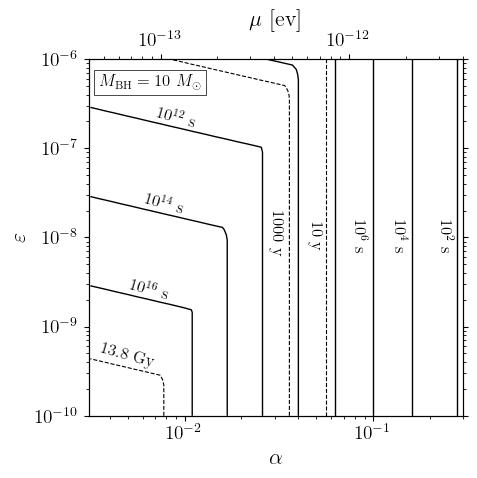

In [564]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
colorlist =  ['darkslateblue', 'orange', 'firebrick'] #['teal', 'orange', 'indianred']
liestyle_list = ['solid', '--']

#level_list = np.log10([1e3, 24*Hour/Second, Year/Second, 100*Year/Second, 
#                       1e4*Year/Second, 1e6*Year/Second, 1e8*Year/Second, 1e10*Year/Second])
level_list = [i for i in np.arange(2,18, 2)]
level_list_2 = [np.log10(10*Year/Second), np.log10(1000*Year/Second), np.log10(13.8e9*Year/Second)]

contours = ax.contour(alpha_list, eps_list, np.log10(np.minimum(tGW_array, tEM_array)/Second), colors='k', 
                      levels=level_list, linewidths=1) #, levels= level_list, colors='black') #, levels=[2, 4, 6, 8, 10, 12, 14, 16] )#, cmap='BuPu')
#ax.clabel(contours, inline=False, fontsize=10)
contours = ax.contour(alpha_list, eps_list, np.log10(np.minimum(tGW_array, tEM_array)/Second), colors='k', 
                      levels=level_list_2, linewidths=0.8, linestyles='dashed') #, levels= level_list, colors='black') #, levels=[2, 4, 6, 8, 10, 12, 14, 16] )#, cmap='BuPu')
#ax.plot(alpha_list, approx_eps_transition(alpha_list, abh0), linewidth=0.5, c='firebrick')
#cbar = plt.colorbar(contours, shrink=0.5, ticks=[2,6,10,14,16])
#cbar.ax.set_yticklabels([r'100 s', r'$10^6$ s', r'$10^{10}$ s', r'$10^{14}$ s', r'$10^{18}$ s'], fontsize=10) 

#manual_locations = [(1e-1, 100), (1e-2, 1e-8), (1e-3, 1e-8), (1e-1, 1e-8), (1e-2, 1e-8), (1e-3, 1e-8), (1e-1, 1e-8), (1e-2, 1e-8) ]

#fmt = {}
#strs = ['1000 s', '1 day', '1 y', '100 y', r'$10^4$ y', r'$10^4$ y', r'$10^4$ y', r'$10^4$ y']
#for l, s in zip(contours.levels, strs):
#    fmt[l] = s


ax.text(0.005, 2e-9, r'$10^{16}$ s', fontsize=12, rotation=-16)
ax.text(0.006, 1.82e-8, r'$10^{14}$ s', fontsize=12, rotation=-16)
ax.text(0.007, 1.68e-7, r'$10^{12}$ s', fontsize=12, rotation=-16)
#ax.text(0.004, 4e-10, r'$t_{\rm{U}}$', fontsize=12, rotation=-16)
ax.text(0.0035, 3.4e-10, r'$13.8$ Gy', fontsize=12, rotation=-16)
#ax.text(0.042, 1.85e-8, r'$10^{10}$ s', fontsize=12, rotation=-90)
#ax.text(0.065, 7e-9, r'$10^{8}$ s', fontsize=12, rotation=-90)
ax.text(0.077, 7e-9, r'$10^{6}$ s', fontsize=12, rotation=-90)
ax.text(0.125, 7e-9, r'$10^{4}$ s', fontsize=12, rotation=-90)
ax.text(0.22, 7e-9, r'$10^{2}$ s', fontsize=12, rotation=-90)
ax.text(0.045, 7.5e-9, r'$10$ y', fontsize=12, rotation=-90)
ax.text(0.028, 6.5e-9, r'$1000$ y', fontsize=12, rotation=-90)

props = dict(boxstyle='square', alpha=1, fill=False, linewidth=0.5)
ax.text(0.0035, 5e-7, r'$M_{\rm{BH}} = 10\ M_{\odot}$', fontsize=12, bbox=props)

ax.set_xscale('log');  ax.set_yscale('log');
ax.set_xlim(3.1e-3, 0.3); #ax.set_ylim(3e-10,1e-6);
ax.yaxis.set_ticks_position('both')

#ax.set_title(r'Lifetime of the superradiance cloud', pad=10);
ax.set_xlabel(r'$\alpha$', fontsize=16)
ax.set_ylabel(r'$\varepsilon$', fontsize=16);

ax2 = ax.twiny()
ax2.set_xscale('log');
#ax2.contour(alpha_list/(GN*Mbh0*MSolar)/eV, eps_list, np.log10(np.minimum(tGW_array, tEM_array)/Second), colors='k', levels=level_list_2, linewidths=1, linestyles='dashed') 
ax2.set_xbound([x/(GN*Mbh0*MSolar)/eV for x in ax.get_xbound()])
ax2.set_xlabel(r'$\mu\ [\rm{ev}]$', fontsize=16)

fig.tight_layout()
#fig.savefig('plots/cloud_lifetime.pdf')

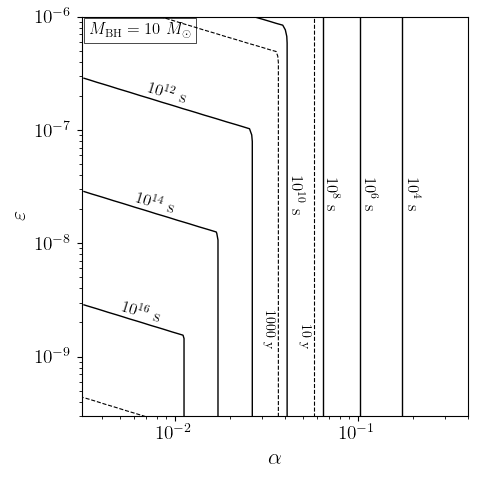

In [62]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
colorlist =  ['darkslateblue', 'orange', 'firebrick'] #['teal', 'orange', 'indianred']
liestyle_list = ['solid', '--']

#level_list = np.log10([1e3, 24*Hour/Second, Year/Second, 100*Year/Second, 
#                       1e4*Year/Second, 1e6*Year/Second, 1e8*Year/Second, 1e10*Year/Second])
level_list = [i for i in np.arange(2,18, 2)]
level_list_2 = [np.log10(10*Year/Second), np.log10(1000*Year/Second), np.log10(13.8e9*Year/Second)]

contours = ax.contour(alpha_list, eps_list, np.log10(np.minimum(tGW_array, tEM_array)/Second), colors='k', 
                      levels=level_list, linewidths=1) #, levels= level_list, colors='black') #, levels=[2, 4, 6, 8, 10, 12, 14, 16] )#, cmap='BuPu')
contours = ax.contour(alpha_list, eps_list, np.log10(np.minimum(tGW_array, tEM_array)/Second), colors='k', 
                      levels=level_list_2, linewidths=0.8, linestyles='dashed') #, levels= level_list, colors='black') #, levels=[2, 4, 6, 8, 10, 12, 14, 16] )#, cmap='BuPu')
#ax.plot(alpha_list, approx_eps_transition(alpha_list, abh0), linewidth=0.5, c='firebrick')
#cbar = plt.colorbar(contours, shrink=0.5, ticks=[2,6,10,14,16])
#cbar.ax.set_yticklabels([r'100 s', r'$10^6$ s', r'$10^{10}$ s', r'$10^{14}$ s', r'$10^{18}$ s'], fontsize=10) 

#manual_locations = [(1e-1, 100), (1e-2, 1e-8), (1e-3, 1e-8), (1e-1, 1e-8), (1e-2, 1e-8), (1e-3, 1e-8), (1e-1, 1e-8), (1e-2, 1e-8) ]

#fmt = {}
#strs = ['1000 s', '1 day', '1 y', '100 y', r'$10^4$ y', r'$10^4$ y', r'$10^4$ y', r'$10^4$ y']
#for l, s in zip(contours.levels, strs):
#    fmt[l] = s

#ax.clabel(contours, inline=False, fontsize=10)

ax.text(0.005, 2e-9, r'$10^{16}$ s', fontsize=12, rotation=-17)
ax.text(0.006, 1.82e-8, r'$10^{14}$ s', fontsize=12, rotation=-17)
ax.text(0.007, 1.72e-7, r'$10^{12}$ s', fontsize=12, rotation=-17)
ax.text(0.042, 1.85e-8, r'$10^{10}$ s', fontsize=12, rotation=-90)
ax.text(0.065, 2e-8, r'$10^{8}$ s', fontsize=12, rotation=-90)
ax.text(0.105, 2e-8, r'$10^{6}$ s', fontsize=12, rotation=-90)
ax.text(0.18, 2e-8, r'$10^{4}$ s', fontsize=12, rotation=-90)
ax.text(0.048, 1.2e-9, r'$10$ y', fontsize=10, rotation=-90)
ax.text(0.0305, 1.2e-9, r'$1000$ y', fontsize=10, rotation=-90)

props = dict(boxstyle='square', alpha=1, fill=False, linewidth=0.5)
ax.text(0.0034, 7e-7, r'$M_{\rm{BH}} = 10\ M_{\odot}$', fontsize=12, bbox=props)

ax.set_xscale('log');  ax.set_yscale('log');
ax.set_xlim(3.1e-3, 0.4); ax.set_ylim(3e-10,1e-6);
#ax.set_xlim(3.1e-3, 0.22); ax.set_ylim(1e-9,1e-6);

#ax.set_title(r'Lifetime of the superradiance cloud', pad=10);
ax.set_xlabel(r'$\alpha$', fontsize=16)
ax.set_ylabel(r'$\varepsilon$', fontsize=16);

fig.tight_layout()
#fig.savefig('plots/cloud_lifetime.pdf')

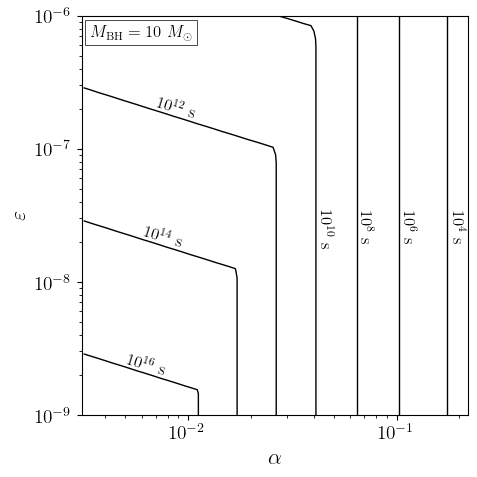

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
colorlist =  ['darkslateblue', 'orange', 'firebrick'] #['teal', 'orange', 'indianred']
liestyle_list = ['solid', '--']

#level_list = np.log10([1e3, 24*Hour/Second, Year/Second, 100*Year/Second, 
#                       1e4*Year/Second, 1e6*Year/Second, 1e8*Year/Second, 1e10*Year/Second])
level_list = [i for i in np.arange(4,18, 2)]

contours = ax.contour(alpha_list, eps_list, np.log10(np.minimum(tGW_array, tEM_array)/Second), colors='k', levels=level_list, linewidths=1) #, levels= level_list, colors='black') #, levels=[2, 4, 6, 8, 10, 12, 14, 16] )#, cmap='BuPu')
#ax.plot(alpha_list, approx_eps_transition(alpha_list, abh0), linewidth=0.5, c='firebrick')
#cbar = plt.colorbar(contours, shrink=0.5, ticks=[2,6,10,14,16])
#cbar.ax.set_yticklabels([r'100 s', r'$10^6$ s', r'$10^{10}$ s', r'$10^{14}$ s', r'$10^{18}$ s'], fontsize=10) 

#manual_locations = [(1e-1, 100), (1e-2, 1e-8), (1e-3, 1e-8), (1e-1, 1e-8), (1e-2, 1e-8), (1e-3, 1e-8), (1e-1, 1e-8), (1e-2, 1e-8) ]

#fmt = {}
#strs = ['1000 s', '1 day', '1 y', '100 y', r'$10^4$ y', r'$10^4$ y', r'$10^4$ y', r'$10^4$ y']
#for l, s in zip(contours.levels, strs):
#    fmt[l] = s

#ax.clabel(contours, inline=False, fontsize=10)

ax.text(0.005, 2e-9, r'$10^{16}$ s', fontsize=12, rotation=-17)
ax.text(0.006, 1.82e-8, r'$10^{14}$ s', fontsize=12, rotation=-17)
ax.text(0.007, 1.72e-7, r'$10^{12}$ s', fontsize=12, rotation=-17)
ax.text(0.042, 1.85e-8, r'$10^{10}$ s', fontsize=12, rotation=-90)
ax.text(0.065, 2e-8, r'$10^{8}$ s', fontsize=12, rotation=-90)
ax.text(0.105, 2e-8, r'$10^{6}$ s', fontsize=12, rotation=-90)
ax.text(0.18, 2e-8, r'$10^{4}$ s', fontsize=12, rotation=-90)

props = dict(boxstyle='square', alpha=1, fill=False, linewidth=0.5)
ax.text(0.0034, 7e-7, r'$M_{\rm{BH}} = 10\ M_{\odot}$', fontsize=12, bbox=props)

ax.set_xscale('log');  ax.set_yscale('log');
ax.set_xlim(3.1e-3, 0.22); ax.set_ylim(1e-9,1e-6);

#ax.set_title(r'Lifetime of the superradiance cloud', pad=10);
ax.set_xlabel(r'$\alpha$', fontsize=16)
ax.set_ylabel(r'$\varepsilon$', fontsize=16);

fig.tight_layout()
#fig.savefig('plots/cloud_lifetime.pdf')

## Cloud time evolution

In [10]:
bc = ub.UltralightBoson(spin=1, model="relativistic") 

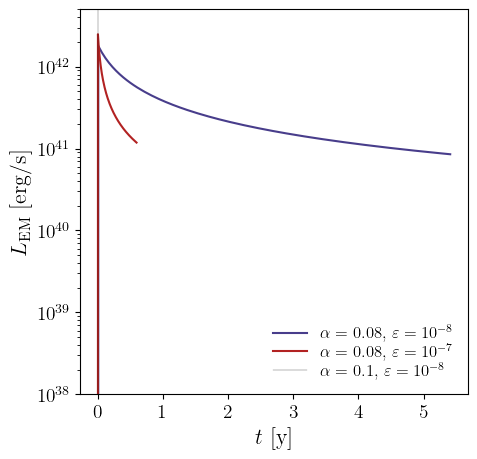

In [504]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
colorlist =  ['darkslateblue', 'firebrick', 'teal', 'orange'] #['teal', 'orange', 'indianred']
liestyle_list = ['solid', '--']
linewidth_list = [1.5, 2]

eps_list = [1e-8, 1e-7]
alpha_list = [0.08, 0.1]

for i_a, alpha in enumerate(alpha_list):
    for i_e, eps in enumerate(eps_list[1:]):
        #print(alpha, eps)
        Mbh0, abh0 = 10, 0.9 
        mu = alpha/(GN*Mbh0*MSolar)

        wf = bc.make_waveform(Mbh0, abh0, alpha, units="physical+alpha")
        t_growth = wf.cloud_growth_time()
        t_efold = wf.efold_time()
        t_start = -18*t_efold #-t_growth/6 #/np.exp(10)
        t_gw = wf.gw_time()
        t_end = 20*t_gw
        t_list = np.append(np.linspace(t_start, 0, 100)[:-1], np.linspace(0, t_end, 100)) #np.logspace(np.log10(t_start), np.log10(t_end), 100)

        mc_list = np.array([wf.mass_cloud(t) for t in t_list])
        Nocc_list = np.array([mc*MSolar/mu for mc in mc_list])
        gamma_list = np.array([Gamma_pair_fn(eps, mu, alpha, Nocc)/(alpha*mu) for Nocc in Nocc_list])

        Mbhf = wf.mass_bh_final()

        lum_list = np.array([EM_lum(eps, alpha, mc*MSolar, Mbhf*MSolar)/(erg/Second) for mc in mc_list])

        ax.plot((t_growth+t_list[gamma_list>1])*Second/Year, lum_list[gamma_list>1], color=colorlist[i_a], 
                linewidth=linewidth_list[i_e])

ax.axvline(Hour/Year, c='k', linewidth=0.2)

ax.legend([r'$\alpha=$ '+str(alpha_list[0])+r',  $\varepsilon = 10^{-8}$', 
           r'$\alpha=$ '+str(alpha_list[0])+r',  $\varepsilon = 10^{-7}$', 
           r'$\alpha=$ '+str(alpha_list[1])+r',  $\varepsilon = 10^{-8}$', 
           r'$\alpha=$ '+str(alpha_list[1])+r',  $\varepsilon = 10^{-7}$'], loc='lower right', 
          frameon=False, labelspacing=0.1, fontsize=12);
#ax.set_xscale('log');  
ax.set_yscale('log');
ax.set_ylim(1e38,5e42)

ax.set_xlabel(r'$t$ [y]', fontsize=16)
ax.set_ylabel(r'$L_{\rm{EM}}$ [erg/s]', fontsize=16);

#fig.savefig('plots/lum_evolutioon_v2.pdf', bbox_inches="tight")
#ax.set_xlim(t_list[0], t_growth+t_list[-1]);

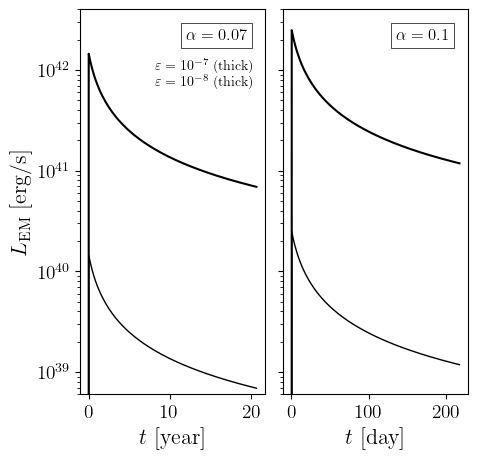

In [635]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(5,5), sharey=True)
fig.subplots_adjust(wspace=0.1)
colorlist =  ['k', 'k']#['darkslateblue', 'firebrick', 'teal', 'orange'] #['teal', 'orange', 'indianred']
liestyle_list = ['solid', '--']
linewidth_list = [1, 1.5]

alpha_list = [0.07, 0.1]
eps_list = [1e-8, 1e-7]

for i_a, alpha in enumerate(alpha_list):
    for i_e, eps in enumerate(eps_list):
        #print(alpha, eps)
        Mbh0, abh0 = 10, 0.9 
        mu = alpha/(GN*Mbh0*MSolar)

        wf = bc.make_waveform(Mbh0, abh0, alpha, units="physical+alpha")
        t_growth = wf.cloud_growth_time()
        t_efold = wf.efold_time()
        t_start = -18*t_efold #-t_growth/6 #/np.exp(10)
        t_gw = wf.gw_time()
        t_end = 20*t_gw
        t_list = np.append(np.linspace(t_start, 0, 100)[:-1], np.linspace(0, t_end, 100)) #np.logspace(np.log10(t_start), np.log10(t_end), 100)

        mc_list = np.array([wf.mass_cloud(t) for t in t_list])
        Nocc_list = np.array([mc*MSolar/mu for mc in mc_list])
        gamma_list = np.array([Gamma_pair_fn(eps, mu, alpha, Nocc)/(alpha*mu) for Nocc in Nocc_list])

        Mbhf = wf.mass_bh_final()

        lum_list = np.array([EM_lum(eps, alpha, mc*MSolar, Mbhf*MSolar)/(erg/Second) for mc in mc_list])

        if i_a==0:
            ax[i_a].plot((t_growth+t_list[gamma_list>1])*Second/Year, lum_list[gamma_list>1], color=colorlist[i_a], 
                         linewidth=linewidth_list[i_e])
        else:
            ax[i_a].plot((t_growth+t_list[gamma_list>1])*Second/(24*Hour), lum_list[gamma_list>1], color=colorlist[i_a], 
                          linewidth=linewidth_list[i_e])

    ax[i_a].set_yscale('log');
    ax[i_a].set_ylim(6e38,4e42)

ax[0].set_xlabel(r'$t$ [year]', fontsize=16)    
ax[1].set_xlabel(r'$t$ [day]', fontsize=16)    
ax[0].set_ylabel(r'$L_{\rm{EM}}$ [erg/s]', fontsize=16);
props = dict(boxstyle='square', alpha=1, fill=False, linewidth=0.5)

ax[0].text(12, 2e42, r'$\alpha = 0.07$', fontsize=12, bbox=props)
ax[1].text(135, 2e42, r'$\alpha = 0.1$', fontsize=12, bbox=props);

ax[0].text(8.2, 1e42, r'$\varepsilon = 10^{-7}$  (thick)', fontsize=10);
ax[0].text(8.2, 7e41, r'$\varepsilon = 10^{-8}$  (thick)', fontsize=10);

#fig.savefig('plots/lum_evolutioon_v2.pdf', bbox_inches="tight")

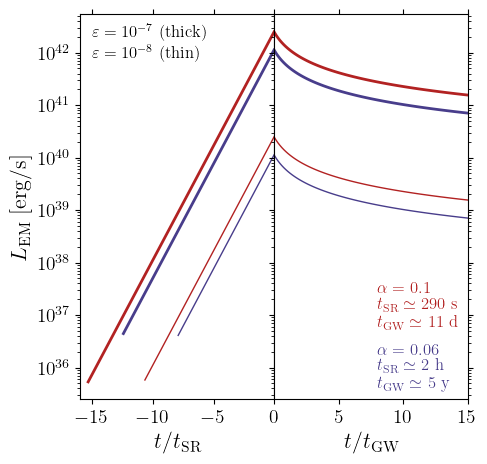

In [464]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(5,5), sharey=True)
fig.subplots_adjust(wspace=0)
colorlist =  ['darkslateblue', 'firebrick', 'teal', 'orange'] #['teal', 'orange', 'indianred']
liestyle_list = ['solid', '--']
linewidth_list = [1, 2]

eps_list = [1e-8, 1e-7]
alpha_list = [0.06, 0.1]


for i_a, alpha in enumerate(alpha_list):
    for i_e, eps in enumerate(eps_list):
        
        Mbh0, abh0 = 10, 0.9 
        mu = alpha/(GN*Mbh0*MSolar)

        wf = bc.make_waveform(Mbh0, abh0, alpha, units="physical+alpha")
        t_growth = wf.cloud_growth_time()
        t_efold = wf.efold_time()
        t_start = -16*t_efold #-t_growth/6 #/np.exp(10)
        t_gw = wf.gw_time()
        t_end = 15*t_gw
        t_list = np.append(np.linspace(t_start, 0, 100)[:-1], np.linspace(0, t_end, 100)) #np.logspace(np.log10(t_start), np.log10(t_end), 100)

        #print(t_efold, t_gw)
        
        mc_list = np.array([wf.mass_cloud(t) for t in t_list])
        Nocc_list = np.array([mc*MSolar/mu for mc in mc_list])
        gamma_list = np.array([Gamma_pair_fn(eps, mu, alpha, Nocc)/(alpha*mu) for Nocc in Nocc_list])

        Mbhf = wf.mass_bh_final()

        lum_list = np.array([EM_lum(eps, alpha, mc*MSolar, Mbhf*MSolar)/(erg/Second) for mc in mc_list])

        ax[0].plot((t_list[((gamma_list>1) & (t_list<=0))])/t_efold, 
                   lum_list[((gamma_list>1) & (t_list<=0))], color=colorlist[i_a], linewidth=linewidth_list[i_e])
        ax[1].plot((t_list[((gamma_list>1) & (t_list>=0))])/t_gw, 
                   lum_list[((gamma_list>1) & (t_list>=0))], color=colorlist[i_a], linewidth=linewidth_list[i_e])
        ax[0].set_xlim(-16, 0);
        ax[1].set_xlim(0, 15);
    
    ax[1].text(8, 1.8e36 + 2.5e37*i_a, r'$\alpha = \ $'+str(alpha), fontsize=12, c=colorlist[i_a])
    
    if i_a==0:
        ax[1].text(8, 0.9e36, r'$t_{\rm{SR}} \simeq \ $'+str(round(t_efold*Second/Hour))+' h', fontsize=12, c=colorlist[i_a])
        ax[1].text(8, 0.4e36, r'$t_{\rm{GW}} \simeq \ $'+str(round(t_gw*Second/Year))+' y', fontsize=12, c=colorlist[i_a])
    else:
        ax[1].text(8, 1.3e37, r'$t_{\rm{SR}} \simeq \ $'+str(int(round(t_efold, -1)))+' s', fontsize=12, c=colorlist[i_a])
        ax[1].text(8, 6e36, r'$t_{\rm{GW}} \simeq \ $'+str(round(t_gw*Second/Hour/24))+' d', fontsize=12, c=colorlist[i_a])

ax[0].text(-15, 2e42, r'$\varepsilon = 10^{-7}$  (thick)', fontsize=12)
ax[0].text(-15, 8e41, r'$\varepsilon = 10^{-8}$  (thin)', fontsize=12)
#ax[0].set_xscale('log');  
ax[0].set_yscale('log'); ax[1].set_yscale('log');
ax[0].set_xticks([ -15, -10., -5])
ax[1].set_xticks([ 0, 5, 10, 15])

ax[0].set_xlabel(r'$t/t_{\rm{SR}}$', fontsize=16)
ax[1].set_xlabel(r'$t/t_{\rm{GW}}$', fontsize=16)
ax[0].set_ylabel(r'$L_{\rm{EM}}$ [erg/s]', fontsize=16);

#fig.tight_layout()
ax[1].yaxis.set_ticks_position('both')
ax[0].xaxis.set_ticks_position('both')
ax[1].xaxis.set_ticks_position('both')

fig.savefig('plots/lum_evolutioon.pdf', bbox_inches="tight")

## Cloud lifetime and time evolution

In [18]:
dp_limits = np.loadtxt('pulsar_data/DPlimits.txt')

In [10]:
alpha_list = np.logspace(-2.5,-0.48, 50) #np.logspace(-2.5,-0.72, 50)
tGW_list = np.zeros(len(alpha_list))
tSR_list = np.zeros(len(alpha_list))

In [11]:
bc = ub.UltralightBoson(spin=1, model="relativistic") 

In [12]:
Mbh0, abh0 = 10, 0.9 

for i, alpha in tqdm(enumerate(alpha_list)):    
    try:
        wf = bc.make_waveform(Mbh0, abh0, alpha, units="physical+alpha")
    except ValueError:
        break 

    if wf.azimuthal_num()==1:
        tSR_list[i] = wf.efold_time()*Second
        tGW_list[i] = wf.gw_time()*Second

50it [00:01, 28.93it/s]


In [13]:
eps_list = np.logspace(-10, -6, 70)
tEM_array = np.zeros((len(eps_list), len(alpha_list)))

for i_a, alpha in enumerate(alpha_list): 
     for i_e, eps in enumerate(eps_list): 
        tEM_array[i_e, i_a] = np.log(2)*GN*Mbh0*MSolar/(eps**2*EM_lum_fit(alpha))

In [14]:
tGW_array = np.zeros((len(eps_list), len(alpha_list)))
tSR_array = np.zeros((len(eps_list), len(alpha_list)))

for i_e, eps in enumerate(eps_list): 
    tGW_array[i_e, :] = tGW_list
    tSR_array[i_e, :] = tSR_list

In [15]:
(tSR_array/tEM_array)[tSR_array/tEM_array>1]

array([ 1.0144776 ,  1.32490425,  1.73032037,  2.25979243,  1.28467132,
        2.95128112,  1.67777631,  3.85436295,  2.19117007,  1.24608906,
        5.03378471,  2.86166055,  1.62738801,  6.57410545,  3.73731879,
        2.12536313,  1.20909489,  8.58575903,  4.88092544,  2.77571691,
        1.57907375, 11.21297165,  6.37447178,  3.6250767 ,  2.06226486,
        1.17362554, 14.64410227,  8.32503814,  4.73433765,  2.69331079,
        1.5327509 , 19.12514701, 10.87247107,  6.18302863,  3.5174546 ,
        2.00176738,  1.13961675, 24.97737597, 14.19940969,  8.07501405,
        4.59378356,  2.61430129,  1.48833555, 32.62036679, 18.54438003,
       10.54594047,  5.99946547,  3.41426846,  1.94376109,  1.10700301,
       42.60208642, 24.21889631, 13.77296185,  7.83528119,  4.45902282,
        2.53854527,  1.44574211, 55.6381778 , 31.62979497, 17.98744063,
       10.23285019,  5.82346841,  3.31533136,  1.8881342 ,  1.07571728])

In [30]:
lum_list

array([3.78494889e+34, 4.53965295e+34, 5.44484205e+34, 6.53052233e+34,
       7.83268303e+34, 9.39448950e+34, 1.12677141e+35, 1.35144524e+35,
       1.62091815e+35, 1.94412291e+35, 2.33177344e+35, 2.79671997e+35,
       3.35437503e+35, 4.02322434e+35, 4.82543959e+35, 5.78761343e+35,
       6.94164099e+35, 8.32577715e+35, 9.98590466e+35, 1.19770551e+36,
       1.43652332e+36, 1.72296047e+36, 2.06651208e+36, 2.47856653e+36,
       2.97278303e+36, 3.56554438e+36, 4.27650003e+36, 5.12921747e+36,
       6.15196344e+36, 7.37864097e+36, 8.84991322e+36, 1.06145514e+37,
       1.27310516e+37, 1.52695737e+37, 1.83142671e+37, 2.19660606e+37,
       2.63460075e+37, 3.15992987e+37, 3.79000756e+37, 4.54572030e+37,
       5.45211921e+37, 6.53925052e+37, 7.84315159e+37, 9.40704544e+37,
       1.12827736e+38, 1.35325147e+38, 1.62308454e+38, 1.94672127e+38,
       2.33488990e+38, 2.80045785e+38, 3.35885823e+38, 4.02860147e+38,
       4.83188890e+38, 5.79534871e+38, 6.95091865e+38, 8.33690473e+38,
      

In [31]:
gamma_list

array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       3.18377713e-270, 4.19207363e-186, 1.28710846e-127, 6.00708348e-087,
       1.15223733e-058, 5.42311945e-039, 2.64026960e-025, 8.87966900e-016,
       3.82731559e-009, 1.61013039e-004, 2.71156234e-001, 4.87572572e+001,
       1.85139715e+003, 2.38499770e+004, 1.44919145e+005, 5.22279451e+005,
       1.30911962e+006, 2.54935891e+006, 4.16560090e+006, 6.02491480e+006,
       8.00571281e+006, 1.00288472e+007, 1.20588993e+007, 1.40927155e+007,
       1.61466720e+007, 1.82471079e+007, 2.04244307e+007, 2.27100187e+007,
       2.51349007e+007, 2.77294410e+007, 3.05235338e+007, 3.35470281e+007,
       3.68302314e+007, 4.04044246e+007, 4.43023587e+007, 4.85587256e+007,
       5.32106095e+007, 5.82979232e+007, 6.38638404e+007, 6.99552323e+007,
       7.66231164e+007, 8.39231254e+007, 9.19160036e+007, 1.00668137e+008,
       1.10252123e+008, 1.20747386e+008, 1.32240850e+008, 1.44827662e+008,
       1.58611990e+008, 1

In [32]:
Nocc_list

array([7.25114596e+69, 8.69699620e+69, 1.04311433e+70, 1.25110727e+70,
       1.50057318e+70, 1.79978162e+70, 2.15865106e+70, 2.58907767e+70,
       3.10532966e+70, 3.72452029e+70, 4.46717512e+70, 5.35791243e+70,
       6.42625928e+70, 7.70763033e+70, 9.24450177e+70, 1.10878194e+71,
       1.32986874e+71, 1.59503938e+71, 1.91308401e+71, 2.29454551e+71,
       2.75206894e+71, 3.30082076e+71, 3.95899155e+71, 4.74839903e+71,
       5.69521129e+71, 6.83081422e+71, 8.19285195e+71, 9.82647470e+71,
       1.17858354e+72, 1.41358851e+72, 1.69545255e+72, 2.03351918e+72,
       2.43899497e+72, 2.92532107e+72, 3.50861868e+72, 4.20822357e+72,
       5.04732695e+72, 6.05374427e+72, 7.26083728e+72, 8.70861993e+72,
       1.04450848e+73, 1.25277940e+73, 1.50257873e+73, 1.80218707e+73,
       2.16153615e+73, 2.59253803e+73, 3.10948000e+73, 3.72949820e+73,
       4.47314560e+73, 5.36507340e+73, 6.43484812e+73, 7.71793175e+73,
       9.25685726e+73, 1.11026385e+74, 1.33164614e+74, 1.59717118e+74,
      

In [35]:
np.log10(t_end)

7.4475142084045265

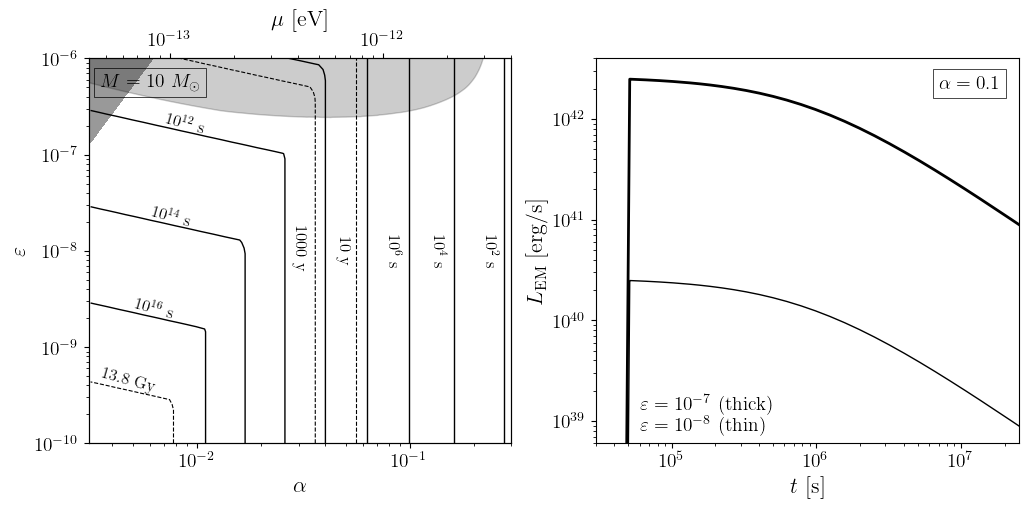

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

colorlist =  ['k', 'k']
liestyle_list = ['solid', '--']
linewidth_list = [1, 2]

eps_list_lum = [1e-8, 1e-7]

font_s = 16

alpha=0.1

for i_e, eps in enumerate(eps_list_lum):
    mu = alpha/(GN*Mbh0*MSolar)

    wf = bc.make_waveform(Mbh0, abh0, alpha, units="physical+alpha")
    t_growth = wf.cloud_growth_time()
    t_efold = wf.efold_time()
    t_start = -18*t_efold 
    t_gw = wf.gw_time()
    t_end = 30*t_gw
    t_list = np.append(np.linspace(t_start, 0, 100)[:-1], np.logspace(-3, np.log10(t_end), 100))
    #np.append(np.linspace(t_start, 0, 100)[:-1], np.linspace(0, t_end, 100)) #np.logspace(np.log10(t_start), np.log10(t_end), 100)

    mc_list = np.array([wf.mass_cloud(t) for t in t_list])
    Nocc_list = np.array([mc*MSolar/mu for mc in mc_list])
    gamma_list = np.array([Gamma_pair_fn(eps, mu, alpha, Nocc)/(alpha*mu) for Nocc in Nocc_list])

    Mbhf = wf.mass_bh_final()

    lum_list = np.array([EM_lum(eps, alpha, mc*MSolar, Mbhf*MSolar)/(erg/Second) for mc in mc_list])

    #ax[1].plot((t_growth+t_list[gamma_list>1]), lum_list[gamma_list>1], color=colorlist[i_a], 
    #            linewidth=linewidth_list[i_e])
    ax[1].plot((t_growth+t_list), lum_list, color=colorlist[0], 
                linewidth=linewidth_list[i_e])

ax[1].set_yscale('log'); ax[1].set_xscale('log');
ax[1].set_ylim(6e38,4e42); ax[1].set_xlim(3e4,2.5e7);

ax[1].set_xlabel(r'$t$ [s]', fontsize=font_s)    
ax[1].set_ylabel(r'$L_{\rm{EM}}$ [erg/s]', fontsize=font_s);

props = dict(boxstyle='square', alpha=1, fill=False, linewidth=0.5)
ax[1].text(7e6, 2e42, r'$\alpha = 0.1$', fontsize=14, bbox=props)

#ax[1].text(2.5e6, 0.9e42, r'$\varepsilon = 10^{-7}$  (thick)', fontsize=14);
#ax[1].text(2.5e6, 5.5e41, r'$\varepsilon = 10^{-8}$  (thin)', fontsize=14);
ax[1].text(6e4, 1.3e39, r'$\varepsilon = 10^{-7}$  (thick)', fontsize=14);
ax[1].text(6e4, 0.8e39, r'$\varepsilon = 10^{-8}$  (thin)', fontsize=14);


level_list = [i for i in np.arange(2,18, 2)]
level_list_2 = [np.log10(10*Year/Second), np.log10(1000*Year/Second), np.log10(13.8e9*Year/Second)]

contours = ax[0].contour(alpha_list, eps_list, np.log10(np.minimum(tGW_array, tEM_array)/Second), colors='k', 
                      levels=level_list, linewidths=1) 
contours = ax[0].contour(alpha_list, eps_list, np.log10(np.minimum(tGW_array, tEM_array)/Second), colors='k', 
                      levels=level_list_2, linewidths=0.8, linestyles='dashed') 
ax[0].contourf(alpha_list, eps_list, np.log10(tSR_array/tEM_array), levels=[0, 10], colors='k', alpha=0.4)


ax[0].set_xscale('log');  ax[0].set_yscale('log');
ax[0].set_xlim(3.1e-3, 0.3);  #ax[0].set_xlim(3.1e-3, 0.3); 
ax[0].set_ylim(1e-10,1e-6); 
#ax[0].yaxis.set_ticks_position('both')

ax[0].set_xlabel(r'$\alpha$', fontsize=font_s)
ax[0].set_ylabel(r'$\varepsilon$', fontsize=font_s);

ax2 = ax[0].twiny()
ax2.set_xscale('log');
#ax2.contour(alpha_list/(GN*Mbh0*MSolar)/eV, eps_list, np.log10(np.minimum(tGW_array, tEM_array)/Second), colors='k', levels=level_list_2, linewidths=1, linestyles='dashed') 
ax2.fill_between(dp_limits[:, 0], dp_limits[:, 1], 1, color='k', alpha=0.2)
ax2.set_xbound([x/(GN*Mbh0*MSolar)/eV for x in ax[0].get_xbound()])
ax2.set_xlabel(r'$\mu\ [\rm{eV}]$', fontsize=font_s);

ax[0].text(0.005, 2e-9, r'$10^{16}$ s', fontsize=12, rotation=-16)
ax[0].text(0.006, 1.82e-8, r'$10^{14}$ s', fontsize=12, rotation=-16)
ax[0].text(0.007, 1.68e-7, r'$10^{12}$ s', fontsize=12, rotation=-16)
ax[0].text(0.0035, 3.4e-10, r'$13.8$ Gy', fontsize=12, rotation=-16)
ax[0].text(0.077, 7e-9, r'$10^{6}$ s', fontsize=12, rotation=-90)
ax[0].text(0.125, 7e-9, r'$10^{4}$ s', fontsize=12, rotation=-90)
ax[0].text(0.22, 7e-9, r'$10^{2}$ s', fontsize=12, rotation=-90)
ax[0].text(0.045, 7.5e-9, r'$10$ y', fontsize=12, rotation=-90)
ax[0].text(0.028, 6.5e-9, r'$1000$ y', fontsize=12, rotation=-90)

props = dict(boxstyle='square', alpha=1, fill=False, linewidth=0.5)
ax[0].text(0.0035, 5e-7, r'$M = 10\ M_{\odot}$', fontsize=14, bbox=props);

fig.savefig('plots/lifetime_lum.pdf', bbox_inches="tight")

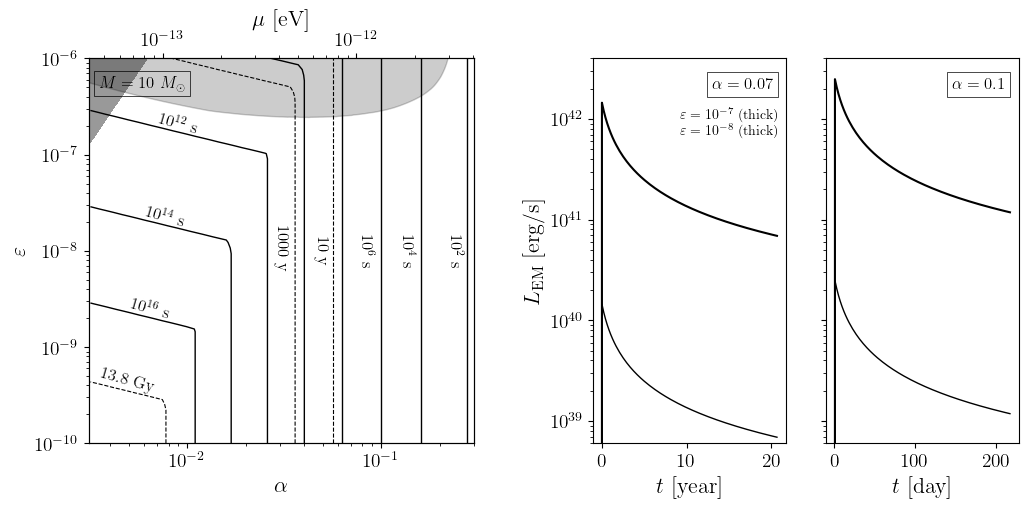

In [522]:
gridspec = dict(wspace=0.2, width_ratios=[2, 0.2, 1, 1])
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12,5), gridspec_kw=gridspec)

colorlist =  ['k', 'k']
liestyle_list = ['solid', '--']
linewidth_list = [1, 1.5]

alpha_list_lum = [0.07, 0.1]
eps_list_lum = [1e-8, 1e-7]

font_s = 16

for i_a, alpha in enumerate(alpha_list_lum):
    for i_e, eps in enumerate(eps_list_lum):
        mu = alpha/(GN*Mbh0*MSolar)

        wf = bc.make_waveform(Mbh0, abh0, alpha, units="physical+alpha")
        t_growth = wf.cloud_growth_time()
        t_efold = wf.efold_time()
        t_start = -18*t_efold 
        t_gw = wf.gw_time()
        t_end = 20*t_gw
        t_list = np.append(np.linspace(t_start, 0, 100)[:-1], np.linspace(0, t_end, 100)) #np.logspace(np.log10(t_start), np.log10(t_end), 100)

        mc_list = np.array([wf.mass_cloud(t) for t in t_list])
        Nocc_list = np.array([mc*MSolar/mu for mc in mc_list])
        gamma_list = np.array([Gamma_pair_fn(eps, mu, alpha, Nocc)/(alpha*mu) for Nocc in Nocc_list])

        Mbhf = wf.mass_bh_final()

        lum_list = np.array([EM_lum(eps, alpha, mc*MSolar, Mbhf*MSolar)/(erg/Second) for mc in mc_list])

        if i_a==0:
            ax[2+i_a].plot((t_growth+t_list[gamma_list>1])*Second/Year, lum_list[gamma_list>1], color=colorlist[i_a], 
                         linewidth=linewidth_list[i_e])
        else:
            ax[2+i_a].plot((t_growth+t_list[gamma_list>1])*Second/(24*Hour), lum_list[gamma_list>1], color=colorlist[i_a], 
                          linewidth=linewidth_list[i_e])

    ax[2+i_a].set_yscale('log');
    ax[2+i_a].set_ylim(6e38,4e42)

ax[2].set_xlabel(r'$t$ [year]', fontsize=font_s)    
ax[3].set_xlabel(r'$t$ [day]', fontsize=font_s)    
ax[2].set_ylabel(r'$L_{\rm{EM}}$ [erg/s]', fontsize=font_s);
props = dict(boxstyle='square', alpha=1, fill=False, linewidth=0.5)

ax[2].text(13, 2e42, r'$\alpha = 0.07$', fontsize=12, bbox=props)
ax[3].text(145, 2e42, r'$\alpha = 0.1$', fontsize=12, bbox=props);

ax[2].text(9.2, 1e42, r'$\varepsilon = 10^{-7}$  (thick)', fontsize=10);
ax[2].text(9.2, 7e41, r'$\varepsilon = 10^{-8}$  (thick)', fontsize=10);
ax[3].yaxis.set_ticklabels([])
ax[1].set_visible(False)

level_list = [i for i in np.arange(2,18, 2)]
level_list_2 = [np.log10(10*Year/Second), np.log10(1000*Year/Second), np.log10(13.8e9*Year/Second)]

contours = ax[0].contour(alpha_list, eps_list, np.log10(np.minimum(tGW_array, tEM_array)/Second), colors='k', 
                      levels=level_list, linewidths=1) 
contours = ax[0].contour(alpha_list, eps_list, np.log10(np.minimum(tGW_array, tEM_array)/Second), colors='k', 
                      levels=level_list_2, linewidths=0.8, linestyles='dashed') 
ax[0].contourf(alpha_list, eps_list, np.log10(tSR_array/tEM_array), levels=[0, 10], colors='k', alpha=0.4)


ax[0].set_xscale('log');  ax[0].set_yscale('log');
ax[0].set_xlim(3.1e-3, 0.3);  #ax[0].set_xlim(3.1e-3, 0.3); 
ax[0].set_ylim(1e-10,1e-6);
#ax[0].yaxis.set_ticks_position('both')

ax[0].set_xlabel(r'$\alpha$', fontsize=font_s)
ax[0].set_ylabel(r'$\varepsilon$', fontsize=font_s);

ax2 = ax[0].twiny()
ax2.set_xscale('log');
#ax2.contour(alpha_list/(GN*Mbh0*MSolar)/eV, eps_list, np.log10(np.minimum(tGW_array, tEM_array)/Second), colors='k', levels=level_list_2, linewidths=1, linestyles='dashed') 
ax2.fill_between(dp_limits[:, 0], dp_limits[:, 1], 1, color='k', alpha=0.2)
ax2.set_xbound([x/(GN*Mbh0*MSolar)/eV for x in ax[0].get_xbound()])
ax2.set_xlabel(r'$\mu\ [\rm{eV}]$', fontsize=font_s);

ax[0].text(0.005, 2e-9, r'$10^{16}$ s', fontsize=12, rotation=-16)
ax[0].text(0.006, 1.82e-8, r'$10^{14}$ s', fontsize=12, rotation=-16)
ax[0].text(0.007, 1.68e-7, r'$10^{12}$ s', fontsize=12, rotation=-16)
ax[0].text(0.0035, 3.4e-10, r'$13.8$ Gy', fontsize=12, rotation=-16)
ax[0].text(0.077, 7e-9, r'$10^{6}$ s', fontsize=12, rotation=-90)
ax[0].text(0.125, 7e-9, r'$10^{4}$ s', fontsize=12, rotation=-90)
ax[0].text(0.22, 7e-9, r'$10^{2}$ s', fontsize=12, rotation=-90)
ax[0].text(0.045, 7.5e-9, r'$10$ y', fontsize=12, rotation=-90)
ax[0].text(0.028, 6.5e-9, r'$1000$ y', fontsize=12, rotation=-90)

props = dict(boxstyle='square', alpha=1, fill=False, linewidth=0.5)
ax[0].text(0.0035, 5e-7, r'$M = 10\ M_{\odot}$', fontsize=12, bbox=props);

#fig.savefig('plots/lifetime_lum.pdf', bbox_inches="tight")

## Pair production rate vs superradiance time

In [811]:
dp_limits = np.loadtxt('pulsar_data/DPlimits.txt')

In [812]:
#alpha_list = np.logspace(-2.5,-0.48, 100) 
#eps_list = np.logspace(-10, -6, 70) 
alpha_list = np.logspace(-2.5,-0.48, 1000) 
eps_list = np.logspace(-10, -6, 1000) 

tSR_array = np.zeros((len(eps_list), len(alpha_list)))
tPl_array = np.zeros((len(eps_list), len(alpha_list)))
tPl_ON = np.zeros((len(eps_list), len(alpha_list)))

In [15]:
bc = ub.UltralightBoson(spin=1, model="relativistic") 

In [813]:
Mbh0, abh0 = 10, 0.9

for i_a, alpha in enumerate(alpha_list):    
    try:
        wf = bc.make_waveform(Mbh0, abh0, alpha, units="physical+alpha")
    except ValueError:
        break 
        
    if wf.azimuthal_num()==1:
        mu = alpha/(GN*Mbh0*MSolar)
        
        for i_e, eps in enumerate(eps_list): 
            
            t_efold = wf.efold_time()
            tSR_array[i_e, i_a] = t_efold*Second
            
            #print(wf.cloud_growth_time()/wf.efold_time(), wf.efold_time()/(1/(4*abh0*alpha**6*mu)/Second))
            
            ### Check if the plasma is created when the cloud is maximal
            Nocc_max = wf.mass_cloud(0)*MSolar/mu
            
            tPl_ON[i_e, i_a] = Gamma_pair_fn(eps, mu, alpha, Nocc_max)/(alpha*mu)
            
            if Gamma_pair_fn(eps, mu, alpha, Nocc_max)/(alpha*mu) > 1:
        
                # Function to find the approximate time when the pair production starts 
                func = lambda log10t : ElectronCharge*Efield_fn(eps, alpha, mu, wf.mass_cloud(-10**log10t)*MSolar/mu) - 0.5*4**(1/4)*MElectron**(3/2)*mu**(1/2)

                t_pair_approx = -10**fsolve(func, np.log10(15*t_efold)-1)[0]

                # Function to find the exact time when the pair production starts 
                func = lambda t : Gamma_pair_fn(eps, mu, alpha, wf.mass_cloud(t)*MSolar/mu) - alpha*mu

                t_pair = fsolve(func, t_pair_approx)[0]
                Nocc_pair =  wf.mass_cloud(t_pair)*MSolar/mu
                
                tPl_array[i_e, i_a] = tplasma_fn(eps, mu, alpha, Nocc_pair)
                
                #if np.abs(Gamma_pair_fn(eps, mu, alpha, Nocc_pair)/(alpha*mu)-1) > 0.1:
                #    print(alpha, eps, t_pair_new, Gamma_pair_fn(eps, mu, alpha, Nocc_pair)/(alpha*mu))
                
            else:
                tPl_array[i_e, i_a] = np.nan

/Users/crimondino/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [814]:
Mbh_list = np.array([10, 100])
mu_list = np.array([np.logspace(-16, -11, 1000), np.logspace(-16, -12, 1000)])
eps_pair_th = 1+np.zeros(mu_list.shape)

In [815]:
abh0 = 0.9

for i_bh, Mbh0 in enumerate(Mbh_list):

    for i_mu, mu in enumerate(mu_list[i_bh]):   

        mu_eV = mu*eV    
        alpha = mu_eV*Mbh0*MSolar*GN 

        try:
            wf = bc.make_waveform(Mbh0, abh0, alpha, units="physical+alpha")
        except ValueError:
            break 
        
        if wf.azimuthal_num()==1:
                        
            Nocc = wf.mass_cloud(0)*MSolar/mu_eV
            
            ### Compute the minimum value of epsilon allowed when the cloud reaches saturation
            func = lambda log_eps : Gamma_pair_fn(10**log_eps, mu_eV, alpha, Nocc)/(alpha*mu_eV) - 1  

            eps_start = 1/(ElectronCharge*alpha**(3/2))*(MElectron/mu_eV)**(3/2)/np.sqrt(Nocc)

            #eps_start = 1/(ElectronCharge*alpha**(5/2)*np.sqrt(delta_as_fn(a_star, alpha)))*MElectron/MPlanck*np.sqrt(2*MElectron/mu_eV)
            eps_pair_th[i_bh, i_mu] = 10**fsolve(func, np.log10(eps_start))[0]   

<ipython-input-9-4d28ce97094e>:9: RuntimeWarning: overflow encountered in power
  exp_factor = 4*myu.MElectron**6*mu**2/((myu.ElectronCharge*E_field)**4)
<ipython-input-815-32fc1d3a733b>:20: RuntimeWarning: overflow encountered in true_divide
  func = lambda log_eps : Gamma_pair_fn(10**log_eps, mu_eV, alpha, Nocc)/(alpha*mu_eV) - 1
<ipython-input-815-32fc1d3a733b>:20: RuntimeWarning: overflow encountered in power
  func = lambda log_eps : Gamma_pair_fn(10**log_eps, mu_eV, alpha, Nocc)/(alpha*mu_eV) - 1


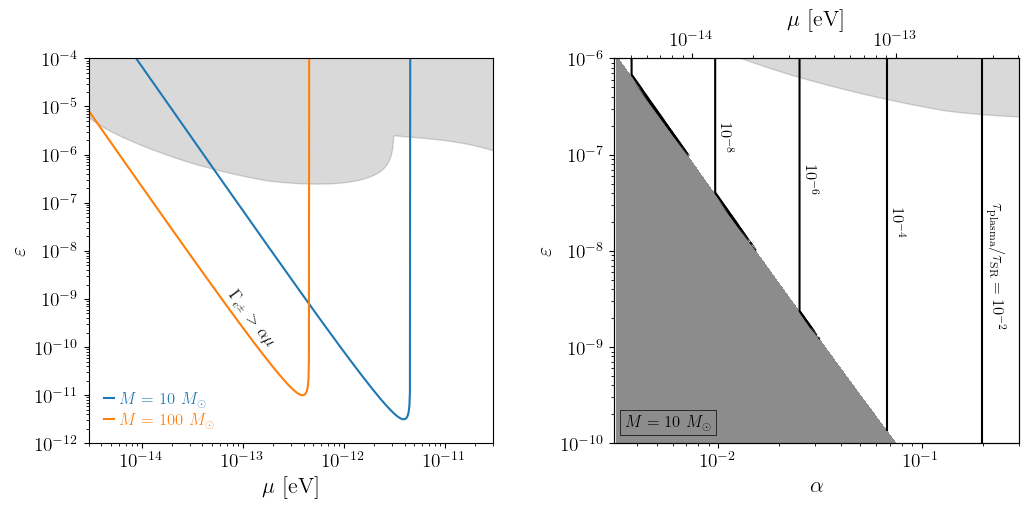

In [817]:
import scipy.ndimage

gridspec = dict(wspace=0.3, width_ratios=[1, 1])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5), gridspec_kw=gridspec)
font_s = 16


ax[0].plot(mu_list[0], eps_pair_th[0])
ax[0].plot(mu_list[1], eps_pair_th[1])
#ax[0].fill_between(mu_list[0], eps_pair_th[0], 1, alpha=0.4)
#ax[0].fill_between(mu_list[1], eps_pair_th[1], 1, alpha=0.4)

ax[0].legend([r'$M =\ $'+str(mbh)+'$\ M_{\odot}$' for mbh in Mbh_list], loc='lower left', frameon=False, labelspacing=0.3, handletextpad=0.3, handlelength=0.6, fontsize=12, labelcolor='linecolor');

ax[0].fill_between(dp_limits[:, 0], dp_limits[:, 1], 1, color='k', alpha=0.15)

ax[0].set_xscale('log');  ax[0].set_yscale('log');
ax[0].set_xlim(3e-15, 3e-11); ax[0].set_ylim(1e-12,1e-4);

#ax.set_title(r'GW strain for '+str(count)+' pulsars with $\dot{f} > 0$', pad=10);
ax[0].set_xlabel(r'$\mu\ [\rm{eV}]$', fontsize=font_s)
ax[0].set_ylabel(r'$\varepsilon$', fontsize=font_s);

#ax[1].text(2.5e-5, 1e-8, r'Efficient $e^{\pm}$ production', fontsize=12, rotation=-52, va='center')
ax[1].text(3.8e-5, 2e-9, r' $\Gamma_{e^{\pm}} > \alpha \mu $ ', fontsize=12, rotation=-53, va='center')

level_list = [i for i in np.arange(2, 12, 2)]
level_list_2 = [1, 12]

ax[1].contourf(alpha_list, eps_list, tPl_ON, levels=[0, 1], colors=['k', 'white'], alpha=0.45)

contours = ax[1].contour(alpha_list, eps_list, np.log10(tSR_array/tPl_array), levels=level_list, colors='k')

#xv, yv = np.meshgrid(alpha_list, eps_list)
#ax[1].plot(xv.reshape(len(alpha_list)*len(eps_list)), yv.reshape(len(alpha_list)*len(eps_list)), '.', markersize=0.2)

#ax[1].clabel(contours, inline=True, fontsize=10)

ax[1].set_xscale('log');  ax[1].set_yscale('log');
ax[1].set_xlim(3.1e-3, 0.3); ax[1].set_ylim(1e-10,1e-6);
#ax[0].yaxis.set_ticks_position('both')

ax[1].set_xlabel(r'$\alpha$', fontsize=font_s)
ax[1].set_ylabel(r'$\varepsilon$', fontsize=font_s);

ax2 = ax[1].twiny()
ax2.set_xscale('log');
#ax2.contour(alpha_list/(GN*Mbh0*MSolar)/eV, eps_list, np.log10(tSR_array/tPl_array), colors='k', levels=level_list_2, linewidths=1, linestyles='dashed') 
ax2.fill_between(dp_limits[:, 0], dp_limits[:, 1], 1, color='k', alpha=0.15)
ax2.set_xbound([x/(GN*Mbh0*MSolar)/eV for x in ax[1].get_xbound()])
ax2.set_xlabel(r'$\mu\ [\rm{eV}]$', fontsize=font_s);

ax[1].text(0.21, 7e-9, r'$\tau_{\rm plasma}/\tau_{\rm{SR}} = 10^{-2}$', fontsize=12, rotation=-90, va='center')
ax[1].text(0.07, 1.94429629e-08, r'$10^{-4}$', fontsize=12, rotation=-90, va='center')
ax[1].text(0.026, 5.40041149e-08, r'$10^{-6}$', fontsize=12, rotation=-90, va='center')
ax[1].text(0.01, 1.5e-7, r'$10^{-8}$', fontsize=12, rotation=-90, va='center');

props = dict(boxstyle='square', alpha=1, fill=False, linewidth=0.5)
ax[1].text(0.0035, 1.5e-10, r'$M = 10\ M_{\odot}$', fontsize=12, bbox=props);

fig.savefig('plots/plasma.pdf', bbox_inches="tight")

## Compare with sdf_pulsarpin down GW

In [67]:
strain_ratio = []

for pul_i in tqdm(range(len(df_pulsar))):
    
    [f_obs, fdot_obs, dist] = df_pulsar.iloc[pul_i][['F0', 'F1', 'DIST']].to_numpy()
    
    #print(strain_ratio[i], [f_obs, fdot_obs, np.max(df_res.iloc[(pul_i)*alpha_points:(pul_i+1)*alpha_points]['strain'])/hsp_fn(2*f_obs, 2*fdot_obs, dist)])
    strain_ratio.append([f_obs, fdot_obs, np.max(df_res.iloc[(pul_i)*alpha_points:(pul_i+1)*alpha_points]['strain'])/hsp_fn(2*f_obs, 2*fdot_obs, dist)])
    #print(np.max(df_res.iloc[(pul_i)*alpha_points:(pul_i+1)*alpha_points]['strain']), hsp_fn(2*f_obs, 2*fdot_obs, dist))
    
strain_ratio = np.array(strain_ratio)

100%|██████████| 49/49 [00:00<00:00, 1361.42it/s]


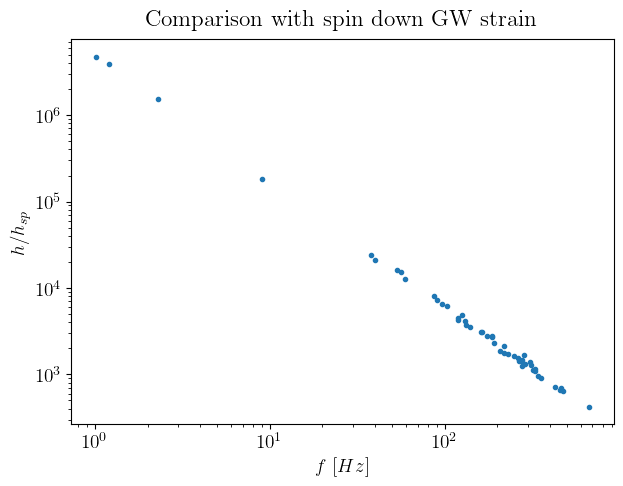

In [79]:
ith_pul = 1 ### Accesing the i_th pulsar

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist = ['darkslateblue', 'firebrick', 'green', 'orange']
liestyle_list = ['-.', 'solid']

ax.plot(strain_ratio[:, 0], strain_ratio[:, 2], '.');

#ax.set_xlim(0.8, 45); ax.set_ylim(1e-26, (3e-23));
ax.set_title(r'Comparison with spin down GW strain', pad=10);
ax.set_xlabel(r'$f\ [Hz]$')
ax.set_ylabel(r'$h/h_{sp}$');

ax.set_xscale('log');  ax.set_yscale('log');

## Checks

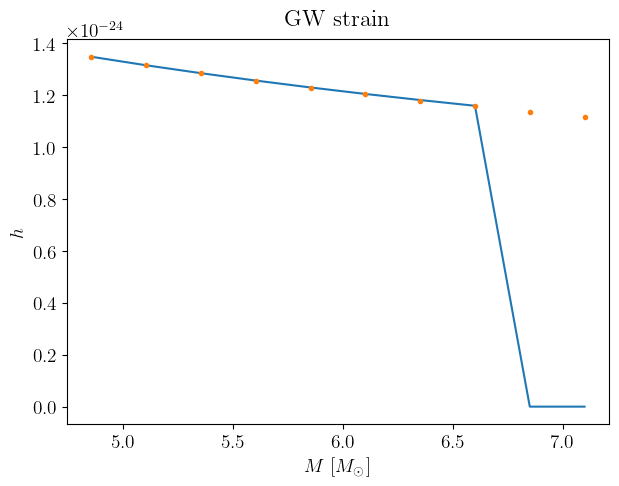

In [378]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist = ['darkslateblue', 'firebrick', 'green', 'orange']
liestyle_list = ['-.', 'solid']



ax.plot(Mbh_list, strain_list, '-');
ax.plot(Mbh_list, strain_list[1]/(alpha_list/alpha_list[1])**(1/2), '.');
ax.set_title(r'GW strain', pad=10);
ax.set_xlabel(r'$M\ [M_\odot]$')
ax.set_ylabel(r'$h$');
#ax.set_xscale('log'); 
#ax.set_yscale('log');

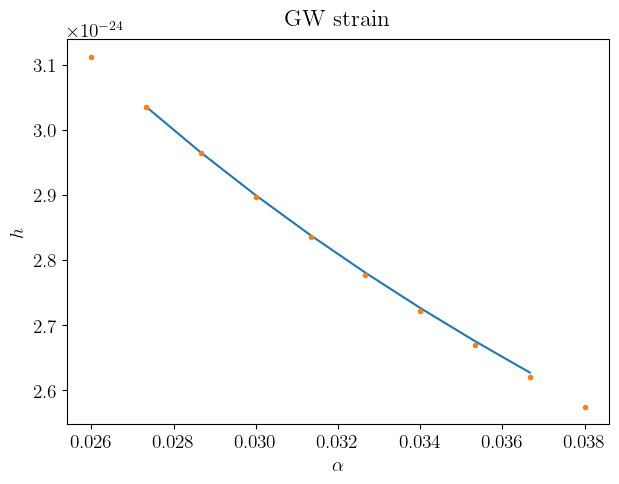

In [342]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist = ['darkslateblue', 'firebrick', 'green', 'orange']
liestyle_list = ['-.', 'solid']



ax.plot(alpha_list, strain_list, '-');
ax.plot(alpha_list, strain_list[1]/(alpha_list/alpha_list[1])**(1/2), '.');
ax.set_title(r'GW strain', pad=10);
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$h$');
#ax.set_xscale('log'); 
#ax.set_yscale('log');

In [294]:
powGW_list*Watt/(erg/Second)

array([0.00000000e+00, 3.46024209e+41, 3.30141917e+41, 3.15666974e+41,
       3.02419753e+41, 2.90249953e+41, 2.79030850e+41, 2.68654848e+41,
       2.59029998e+41, 2.50077260e+41])

In [236]:
fdot_ratio

array([ 0.63064352,  1.17392453,  2.11868774,  3.71780578,  6.3586095 ,
       10.62240864, 17.36549533, 27.8277468 , 43.77623887, 67.69275558])

In [295]:
alpha = 0.03
mu = 2*np.pi*f_obs*Hz/eV ## Fix the dark photon mass to the pulsar frequency
Mbh0 = alpha/(GN*mu*eV)/MSolar
abh0 = 0.7

bc = ub.UltralightBoson(spin=1, model="relativistic") 
bc.make_waveform(Mbh0, abh0, alpha, units="physical+alpha")
wf = bc.make_waveform(Mbh0, abh0, alpha, units="physical+alpha")
tauGW = wf.gw_time()
tauGW*Second/Year
wf.power_gw(0)

1.1735885023840232e+35

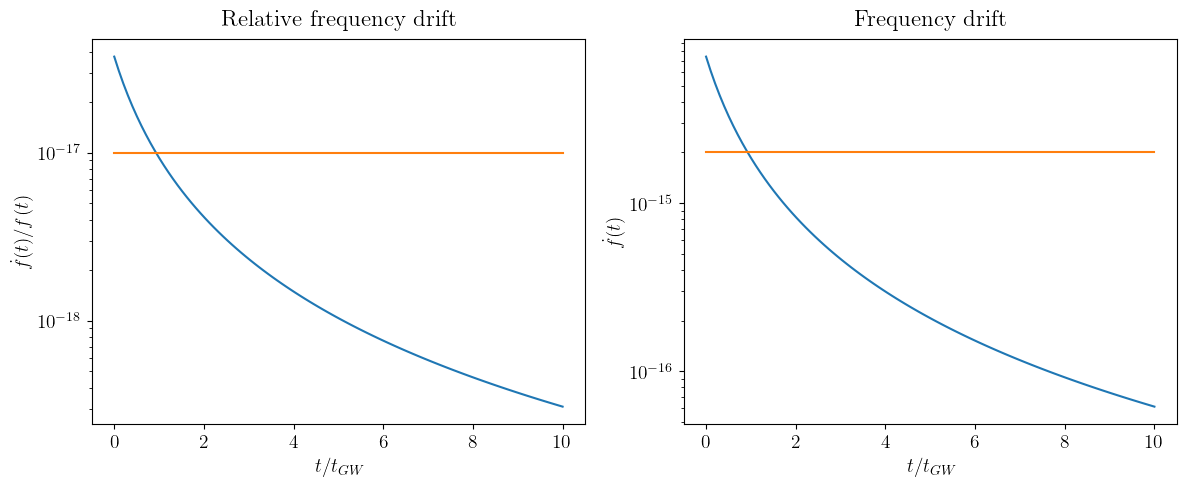

In [293]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
colorlist = ['darkslateblue', 'firebrick', 'green', 'orange']
liestyle_list = ['-.', 'solid']

t_list = np.linspace(0, 10*tauGW, 100) #np.append(np.array([0]),tauGW*np.logspace(0, 2, num=100)) #tauGW*np.logspace(0, 2, num=100) #np.logspace(0, 10*tauGW, 100)
f_list = wf.freq_gw(t_list)
fdot_list = wf.freqdot_gw(t_list)
fdot_list_approx = fdot_fn(alpha, wf.mass_cloud(t_list), Mbh0)
ax[0].plot(t_list/tauGW, fdot_list/f_list[0])
#ax[0].plot(t_list/tauGW, fdot_list_approx/f_list)
ax[0].plot(t_list/tauGW, np.ones(len(t_list))*fdot_obs/f_obs)

#ax.set_xscale('log'); 
ax[0].set_yscale('log');
# Set ticks on both sides of axes on
#ax.minorticks_on()
#ax.tick_params(axis='both', which='both', bottom=True, top=True, labelbottom=True, labeltop=False, left=True, right=True, labelleft=True, labelright=False)
ax[0].set_title(r'Relative frequency drift', pad=10);
ax[0].set_xlabel(r'$t/t_{GW}$')
ax[0].set_ylabel(r'$\dot{f} (t)/f (t)$');

ax[1].plot(t_list/tauGW, fdot_list)
#ax[1].plot(t_list/tauGW, fdot_list_approx)
ax[1].plot(t_list/tauGW, np.ones(len(t_list))*2*fdot_obs)
ax[1].set_yscale('log');
ax[1].set_title(r'Frequency drift', pad=10);
ax[1].set_xlabel(r'$t/t_{GW}$')
ax[1].set_ylabel(r'$\dot{f} (t)$');

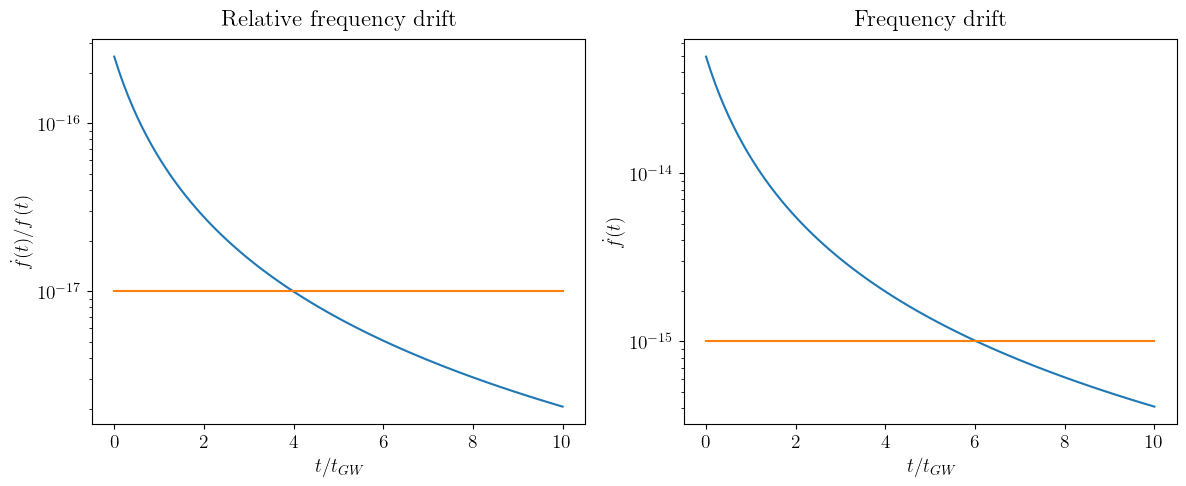

In [147]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
colorlist = ['darkslateblue', 'firebrick', 'green', 'orange']
liestyle_list = ['-.', 'solid']

t_list = np.linspace(0, 10*tauGW, 100) #np.append(np.array([0]),tauGW*np.logspace(0, 2, num=100)) #tauGW*np.logspace(0, 2, num=100) #np.logspace(0, 10*tauGW, 100)
f_list = wf.freq_gw(t_list)
fdot_list = wf.freqdot_gw(t_list)
ax[0].plot(t_list/tauGW, fdot_list/f_list)
ax[0].plot(t_list/tauGW, np.ones(len(t_list))*fdot_obs/f_obs)

#ax.set_xscale('log'); 
ax[0].set_yscale('log');
# Set ticks on both sides of axes on
#ax.minorticks_on()
#ax.tick_params(axis='both', which='both', bottom=True, top=True, labelbottom=True, labeltop=False, left=True, right=True, labelleft=True, labelright=False)
ax[0].set_title(r'Relative frequency drift', pad=10);
ax[0].set_xlabel(r'$t/t_{GW}$')
ax[0].set_ylabel(r'$\dot{f} (t)/f (t)$');

ax[1].plot(t_list/tauGW, fdot_list)
ax[1].plot(t_list/tauGW, np.ones(len(t_list))*fdot_obs)
ax[1].set_yscale('log');
ax[1].set_title(r'Frequency drift', pad=10);
ax[1].set_xlabel(r'$t/t_{GW}$')
ax[1].set_ylabel(r'$\dot{f} (t)$');

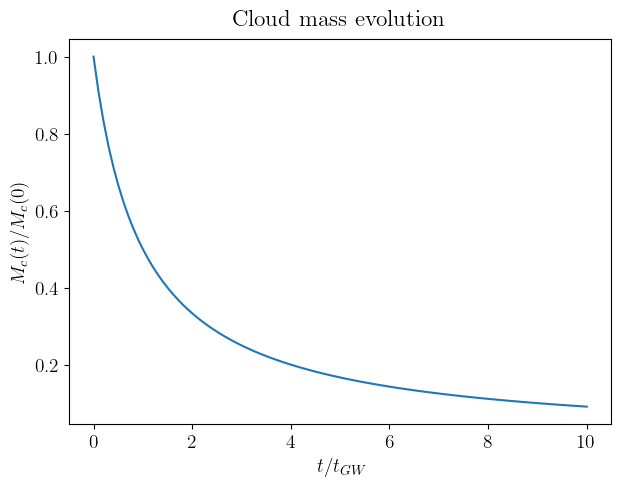

In [146]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist = ['darkslateblue', 'firebrick', 'green', 'orange']
liestyle_list = ['-.', 'solid']

t_list = np.linspace(0, 10*tauGW, 100) #np.append(np.array([0]),tauGW*np.logspace(0, 2, num=100)) #tauGW*np.logspace(0, 2, num=100) #np.logspace(0, 10*tauGW, 100)
mass_list = wf.mass_cloud(t_list)
ax.plot(t_list/tauGW, mass_list/mass_list[0])

#ax.set_xscale('log'); ax.set_yscale('log');
# Set ticks on both sides of axes on
#ax.minorticks_on()
#ax.tick_params(axis='both', which='both', bottom=True, top=True, labelbottom=True, labeltop=False, left=True, right=True, labelleft=True, labelright=False)
ax.set_title(r'Cloud mass evolution', pad=10);
ax.set_xlabel(r'$t/t_{GW}$')
ax.set_ylabel(r'$M_c (t)/M_c (0)$');
#ax.axis([1*math.pow(10, 7), math.pow(10, 9), 0.7, 16]);
#ax.set_ylim(0.6, 10)
#fig.tight_layout()
#fig.savefig(FigDir+'Compact_lens_limit_DR2_EDR3.pdf')

# Fermi

## Select merger events

In [301]:
df_ligo = pd.read_csv('ligo_data/ligo_catalog.csv', index_col=0)
len(df_ligo)

93

In [302]:
df_ligo = df_ligo[~np.isnan(df_ligo['final_mass_source'])]
len(df_ligo)

89

In [318]:
### Drop the NS-NS merger
df_ligo.drop(index='GW170817-v3', inplace=True)

In [34]:
from datetime import date

d0 = date(2015, 9, 1)
ndays = np.zeros(len(df_ligo))

for i in range(len(df_ligo)):
    year = int('20'+df_ligo['commonName'][i][2:4])
    month = int(df_ligo['commonName'][i][4:6])
    day = int(df_ligo['commonName'][i][6:8])
    
    d1 = date(year, month, day)
    delta = d1 - d0
    ndays[i] = delta.days

In [50]:
all_events = np.array([df_ligo['final_mass_source'].to_numpy(), df_ligo['luminosity_distance'].to_numpy(), ndays]).T
all_events = all_events[~np.isnan(all_events[:, 0])];

In [414]:
spin_list = [0.69, 0.67, 0.74, 0.66, 0.69, 0.81, 0.70, 0.72, 0.67, 0.72, 0.91, 0, 0.67, 0.67, 0.69, 0.69, 0.68, 0, 0, 0 ]
spin_list[:11]

[0.69, 0.67, 0.74, 0.66, 0.69, 0.81, 0.7, 0.72, 0.67, 0.72, 0.91]

In [415]:
array_o1 = []

for i in range(11):
    print(df_ligo.iloc[i]['commonName'])
    array_o1.append([df_ligo.iloc[i]['commonName'], df_ligo.iloc[i]['final_mass_source'],df_ligo.iloc[i]['luminosity_distance']/1000, spin_list[i]])
    
array_o1 = np.array(array_o1)

GW150914
GW151012
GW151226
GW170104
GW170608
GW170729
GW170809
GW170814
GW170818
GW170823
GW190403_051519


In [177]:
array_spin_o3 = np.array([['GW200322G',0.78],['GW200316I',0.70],['GW200311L',0.69],['GW200308G',0.91],['GW200306A',0.78],['GW200302A',0.66],['GW200225B',0.66],['GW200224H',0.73],['GW200220H',0.67],['GW200220E',0.71],
 ['GW200219D',0.66],['GW200216G',0.70],['GW200210B',0.34],['GW200209E',0.66],['GW200208K',0.83],['GW200208G',0.66],['GW200202F',0.69],['GW200129D',0.73],['GW200128C',0.74],['GW200115A',0.42],
 ['GW200112H',0.71],['GW200105F',0.43],['GW191230H',0.68],['GW191222A',0.67],['GW191219E',0.14],  ['GW191216G',0.70],['GW191215G',0.68],['GW191204G',0.73],['GW191204A',0.71],['GW191129G',0.69],
 ['GW191127B',0.75],['GW191126C',0.75],['GW191113B',0.45],['GW191109A',0.61],['GW191105C',0.67],['GW191103A',0.75]])

In [351]:
array_mass_o3 = np.array([['GW200322G',74],['GW200316I',20.2],['GW200311L',59.0],['GW200308G',88],['GW200306A',41.7],['GW200302A',55.5],['GW200225B',32.1],['GW200224H',68.6],['GW200220H',64],['GW200220E',141],
                          ['GW200219D',62.2],['GW200216G',78],['GW200210B',26.7],['GW200209E',59.9],['GW200208K',61],['GW200208G',62.5],['GW200202F',16.76],['GW200129D',60.3],['GW200128C',71],['GW200115A',7.2],
                          ['GW200112H',60.8],['GW200105F',10.7],['GW191230H',82],['GW191222A',75.5],['GW191219E',32.2],['GW191216G',18.87],['GW191215G',41.4],['GW191204G',19.21],['GW191204A',45.0],['GW191129G',16.8],
                          ['GW191127B',76],['GW191126C',19.6],['GW191113B',34],['GW191109A',107],['GW191105C',17.6],['GW191103A',19.0]])

In [179]:
array_dist_o3 = np.array([['GW200322G',3.6],['GW200316I',1.12],['GW200311L',1.17],['GW200308G',5.4],['GW200306A',2.1],['GW200302A',1.48],['GW200225B',1.15],['GW200224H',1.71],['GW200220H',4.0],['GW200220E',6.0],['GW200219D',3.4],
                          ['GW200216G',3.8],['GW200210B',0.94],['GW200209E',3.4],['GW200208K',4.1],['GW200208G',2.23],['GW200202F',0.41],['GW200129D',0.90],['GW200128C',3.4],['GW200115A',0.29],['GW200112H',1.25],['GW200105F',0.27],
                          ['GW191230H',4.3],['GW191222A',3.0],['GW191219E',0.55],['GW191216G',0.34],['GW191215G',1.93],['GW191204G',0.65],['GW191204A',1.8],['GW191129G',0.79],['GW191127B',3.4],['GW191126C',1.62],['GW191113B',1.37],
                          ['GW191109A',1.29],['GW191105C',1.15],['GW191103A',0.99]]);

In [362]:
array_mass_o2 = np.array([['GW190930A',19.4],['GW190929A',101.5],['GW190924A',13.3],['GW190915A',57.2],['GW190910A',75.8], ['GW190909A',72.0], ['GW190828B',33.1],['GW190828A',54.9],['GW190814A',25.6],['GW190803A',61.7],
                          ['GW190731A',67.0],['GW190728A',19.6], ['GW190727A',63.8],['GW190720A',20.4],['GW190719A',54.9], ['GW190708A',29.5], ['GW190707A',19.2],['GW190706A',99.0],['GW190701A',90.2],['GW190630A',56.4],
                          ['GW190620A',87.2],['GW190602A',110.9],['GW190527A',56.4],['GW190521B',71.0],['GW190521A',156.3],['GW190519A',101.0],['GW190517A',59.3],['GW190514A',64.5],['GW190513A',51.6],['GW190512A',34.5],
                          ['GW190503A',68.6],['GW190424A',68.9], ['GW190421A',69.7],['GW190413B',75.5],['GW190413A',56.0], ['GW190412A',37.3], ['GW190408A',41.1]])
len(array_mass_o2)

37

In [77]:
array_spin_o2 = np.array([['GW190930A',0.72],['GW190929A',0.66],['GW190924A',0.67],['GW190915A',0.70],['GW190910A',0.70],['GW190909A',0.66],['GW190828B',0.65],['GW190828A',0.75],['GW190814A',0.28],['GW190803A',0.68],
                          ['GW190731A',0.70],['GW190728A',0.71],['GW190727A',0.73],['GW190720A',0.72],['GW190719A',0.78],['GW190708A',0.69],['GW190707A',0.66],['GW190706A',0.78],['GW190701A',0.66],['GW190630A',0.70],
                          ['GW190620A',0.79],['GW190602A',0.70],['GW190527A',0.71],['GW190521B',0.72],['GW190521A',0.71],['GW190519A',0.79],['GW190517A',0.87],['GW190514A',0.63],['GW190513A',0.68],['GW190512A',0.65],
                          ['GW190503A',0.66],['GW190424A',0.74],['GW190421A',0.67],['GW190413B',0.68],['GW190413A',0.68],['GW190412A',0.67],['GW190408A',0.67]]);

In [159]:
array_dist_o2 = np.array([['GW190930A',0.76],['GW190929A',2.13],['GW190924A',0.57],['GW190915A',1.62],['GW190910A',1.46],['GW190909A',3.77],['GW190828B',1.60],['GW190828A',2.13],['GW190814A',0.24],['GW190803A',3.27],
                          ['GW190731A',3.30],['GW190728A',0.87],['GW190727A',3.30],['GW190720A',0.79],['GW190719A',3.94],['GW190708A',0.88],['GW190707A',0.77],['GW190706A',4.42],['GW190701A',2.06],['GW190630A',0.89],
                          ['GW190620A',2.81],['GW190602A',2.69],['GW190527A',2.49],['GW190521B',1.24],['GW190521A',3.92],['GW190519A',2.53],['GW190517A',1.86],['GW190514A',4.13],['GW190513A',2.06],['GW190512A',1.43],
                          ['GW190503A',1.45],['GW190424A',2.20],['GW190421A',2.88],['GW190413B',4.45],['GW190413A',3.55],['GW190412A',0.74],['GW190408A',1.55]]);

In [416]:
array_o3 = np.flip(np.array([array_mass_o3[:, 0], array_mass_o3[:, 1], array_dist_o3[:, 1], array_spin_o3[:, 1]]).T, axis=0)

In [417]:
array_o2 = np.flip(np.array([array_mass_o2[:, 0], array_mass_o2[:, 1], array_dist_o2[:, 1], array_spin_o2[:, 1]]).T, axis=0)

In [418]:
all_events = np.concatenate([array_o1, array_o2, array_o3])

In [419]:
from datetime import date

d0 = date(2015, 9, 1)
ndays = np.zeros(len(all_events))

for i in range(len(all_events)):
    year = int('20'+all_events[i, 0][2:4])
    month = int(df_ligo['commonName'][i][4:6])
    day = int(df_ligo['commonName'][i][6:8])
    
    d1 = date(year, month, day)
    delta = d1 - d0
    ndays[i] = delta.days

In [420]:
all_events = np.c_[ all_events, ndays ] 

In [439]:
len(all_events)

84

In [422]:
np.savetxt('ligo_data/all_events.txt',all_events, delimiter=" ", fmt="%s") 

In [448]:
dict_all_events = {'name': all_events[:,0], 'final_mass': all_events[:,1].astype(float), 'dist': all_events[:,2].astype(float), 'final_spin': all_events[:,3].astype(float), 'n_days': all_events[:,4].astype(float)}
df_all_events = pd.DataFrame(data=dict_all_events)
df_all_events

,name,final_mass,dist,final_spin,n_days
0,GW150914,63.1,0.44,0.69,13.0
1,GW151012,35.6,1.08,0.67,41.0
2,GW151226,20.5,0.45,0.74,116.0
3,GW170104,48.9,0.99,0.66,491.0
4,GW170608,17.8,0.32,0.69,646.0
...,...,...,...,...,...
79,GW200306A,41.7,2.10,0.78,1633.0
80,GW200308G,88.0,5.40,0.91,1637.0
81,GW200311L,59.0,1.17,0.69,1638.0
82,GW200316I,20.2,1.12,0.70,1644.0


In [449]:
df_all_events.to_csv('ligo_data/all_events.csv', index=False)

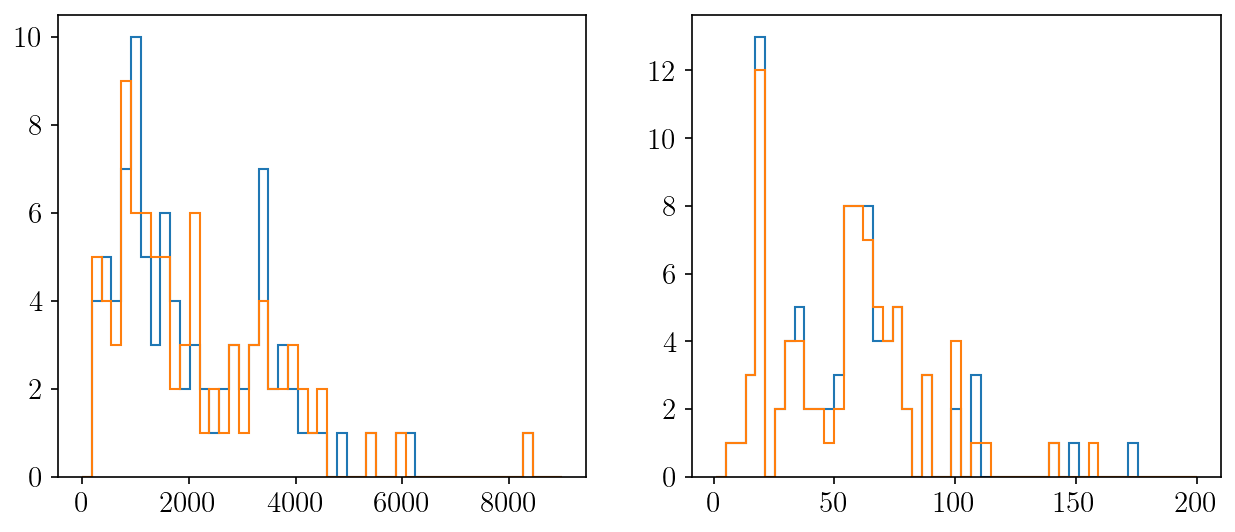

In [427]:
fig,ax = plt.subplots(1,2,figsize=(10,4), dpi = 150)

ax[0].hist(df_ligo['luminosity_distance'], bins=np.linspace(0, 9000, 50), log=False, density=False, histtype='step');
ax[0].hist(all_events[:, 2].astype(float)*1000, bins=np.linspace(0, 9000, 50), log=False, density=False, histtype='step');

ax[1].hist(df_ligo['final_mass_source'], bins=np.linspace(1, 200, 50), log=False, density=False, histtype='step');
ax[1].hist(all_events[:, 1].astype(float), bins=np.linspace(1, 200, 50), log=False, density=False, histtype='step');


## Estimate photon counts

In [543]:
dp_limits = np.loadtxt('pulsar_data/DPlimits.txt')

In [446]:
from my_units import * 

In [450]:
df_all_events = pd.read_csv('ligo_data/all_events.csv')
df_all_events

,name,final_mass,dist,final_spin,n_days
0,GW150914,63.1,0.44,0.69,13.0
1,GW151012,35.6,1.08,0.67,41.0
2,GW151226,20.5,0.45,0.74,116.0
3,GW170104,48.9,0.99,0.66,491.0
4,GW170608,17.8,0.32,0.69,646.0
...,...,...,...,...,...
79,GW200306A,41.7,2.10,0.78,1633.0
80,GW200308G,88.0,5.40,0.91,1637.0
81,GW200311L,59.0,1.17,0.69,1638.0
82,GW200316I,20.2,1.12,0.70,1644.0


In [47]:
df_events = pd.DataFrame(np.array([['GW170814', 600, 53.2, 0.72, 87], ['GW190814', 230, 25.7, 0.28, 19], ['GW200202_154313', 410, 16.76, 0.69, 170]]), 
                         columns=['commonName', 'luminosity_distance', 'final_mass_source', 'final_chi', 'delta_omega'])
df_events

,commonName,luminosity_distance,final_mass_source,final_chi,delta_omega
0,GW170814,600,53.2,0.72,87
1,GW190814,230,25.7,0.28,19
2,GW200202_154313,410,16.76,0.69,170


In [457]:
bc = ub.UltralightBoson(spin=1, model="relativistic") 

In [550]:
F0V = 0.2
eff_area = 0.9*Meter**2
E_gamma = 1*GeV

In [588]:
mu_list = np.logspace(np.log10(3e-14), np.log10(3e-12), 100)*eV

n_gamma_list = np.zeros((len(df_all_events), len(mu_list)))
n_gamma_list[0].shape

(100,)

In [589]:
for i_event in tqdm(range(len(df_all_events))):
    
    for i_mu, mu in enumerate(mu_list):

        eps = np.interp(np.log10(mu/eV), np.log10(dp_limits[:, 0]), dp_limits[:, 1])
        #print(mu/eV, eps)

        Mbh0, abh0, dist = df_all_events.iloc[i_event]['final_mass']*MSolar, df_all_events.iloc[i_event]['final_spin'], df_all_events.iloc[i_event]['dist']*1000*Mpc
        nday_merger = df_all_events.iloc[i_event]['n_days']

        alpha = mu*Mbh0*GN

        try:
            wf = bc.make_waveform(Mbh0/MSolar, abh0, alpha, units="physical+alpha")
        except ValueError:
            break 
        #print(wf.azimuthal_num())

        if wf.azimuthal_num()==1:

            t_growth = wf.cloud_growth_time()
            t_merger = nday_merger*24*Hour/Second
            t_today = 7*Year/Second

            if t_growth < (t_today - t_merger): 
                #print('time ok')

                t_start = -3*wf.efold_time()
                t_end = min(30*wf.gw_time(), t_today - t_merger - t_growth)

                t_list = np.append(np.linspace(t_start, 0, 100)[:-1], np.logspace(-3, np.log10(t_end), 500))

                mc_list = np.array([wf.mass_cloud(t) for t in t_list])
                Nocc_list = np.array([mc*MSolar/mu for mc in mc_list])
                Mbhf = wf.mass_bh_final()

                lum_list = np.array([EM_lum(eps, alpha, mc*MSolar, Mbhf*MSolar)/(erg/Second) for mc in mc_list])

                # construct a linear interpolation function of luminosity
                lum_interp = lambda xx: np.interp(xx, t_growth+t_merger+t_list, lum_list)

                int_lum = quad(lum_interp, t_growth+t_merger+t_start, t_growth+t_merger+t_end)[0]

                n_gamma_list[i_event][i_mu] = F0V*int_lum*erg/(4*np.pi*dist**2)*eff_area/E_gamma

  0%|          | 0/84 [00:00<?, ?it/s]<ipython-input-589-552fba7fad1a>:42: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_lum = quad(lum_interp, t_growth+t_merger+t_start, t_growth+t_merger+t_end)[0]
<ipython-input-589-552fba7fad1a>:42: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  int_lum = quad(lum_interp, t_growth+t_merger+t_start, t_growth+t_merger+t_end)[0]
 10%|▉         | 8/84 [00:04<00:45,  1.65it/s]<ipython-input-589-552fba7fad1a>:42: IntegrationWar

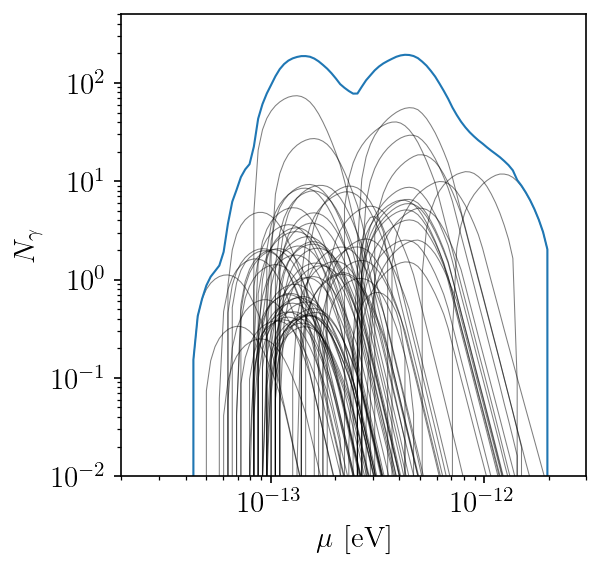

In [594]:
fig,ax = plt.subplots(1,1,figsize=(4,4), dpi = 150)

for i_event in range(len(df_all_events)):
    ax.plot(mu_list/eV, n_gamma_list[i_event], '-', linewidth=0.5, c='k', alpha=0.5);

ax.plot(mu_list/eV, np.sum(n_gamma_list, axis=0), '-', linewidth=1);

ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel(r'$\mu$ [eV]'); ax.set_ylabel(r'$N_{\gamma}$');
ax.set_xlim(2e-14, 3e-12)
ax.set_ylim(0.01, 500)
fig.savefig('plots/fermi.pdf', bbox_inches="tight")

In [595]:
np.max(n_gamma_list, axis=0)

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.15351108,  0.42539583,
        0.63557499,  0.79605313,  0.91977102,  1.01006508,  1.07382786,
        1.1078993 ,  1.11495042,  2.00361046,  2.8803744 ,  3.5476184 ,
        4.06283701,  4.43234057,  4.78337877, 20.73089841, 33.38075431,
       43.59855529, 51.7923831 , 58.59933354, 64.04229513, 68.39585622,
       71.71738213, 73.58973142, 74.10603177, 72.75992894, 69.29540967,
       63.92015135, 56.70383314, 48.4516699 , 40.04207194, 32.26490348,
       25.31299627, 19.41576856, 15.28675814, 12.37200875, 10.72239063,
       15.34937954, 19.40776484, 23.04776836, 26.36730629, 29.44013524,
       32.25785245, 34.82779702, 38.70186519, 42.91765482, 46.74315368,
       50.24678554, 53.08443762, 55.14507096, 56.01249817, 55.55220875,
       53.38829962, 48.86652459, 43.40777097, 37.12425297, 31.06621742,
       25.1231057 , 19.87219877, 15.38011949, 11.06205341, 11.76

In [647]:
np.sort(n_gamma_list[:, 20][n_gamma_list[:, 20]>0])[-2:]

array([1.67323351, 4.06283701])

In [651]:
top2 = np.zeros(len(mu_list))
top5 = np.zeros(len(mu_list))
for i_mu in range(len(mu_list)):
    #print(len(n_gamma_list[:,i_mu]))
    #print(n_gamma_list.T[:, i_mu][n_gamma_list[:, i_mu]>0])
    if len(n_gamma_list[:, i_mu][n_gamma_list[:, i_mu]>0])>0:
        top2[i_mu] = np.sum(np.sort(n_gamma_list[:, i_mu][n_gamma_list[:, i_mu]>0])[-2:])
        top5[i_mu] = np.sum(np.sort(n_gamma_list[:, i_mu][n_gamma_list[:, i_mu]>0])[-5:])

<ipython-input-652-40015aa9554f>:3: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(mu_list/eV, np.max(n_gamma_list, axis=0)/np.sum(n_gamma_list, axis=0), '-', linewidth=1);
<ipython-input-652-40015aa9554f>:4: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(mu_list/eV, top2/np.sum(n_gamma_list, axis=0), '-', linewidth=1);
<ipython-input-652-40015aa9554f>:5: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(mu_list/eV, top5/np.sum(n_gamma_list, axis=0), '-', linewidth=1);


(0.0, 1.1)

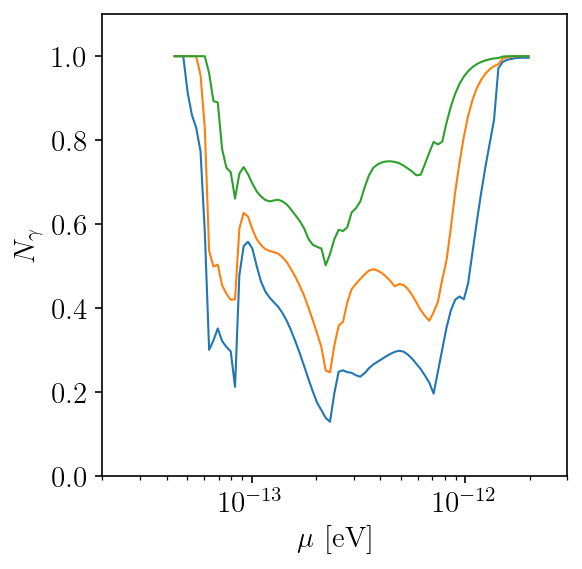

In [652]:
fig,ax = plt.subplots(1,1,figsize=(4,4), dpi = 150)

ax.plot(mu_list/eV, np.max(n_gamma_list, axis=0)/np.sum(n_gamma_list, axis=0), '-', linewidth=1);
ax.plot(mu_list/eV, top2/np.sum(n_gamma_list, axis=0), '-', linewidth=1);
ax.plot(mu_list/eV, top5/np.sum(n_gamma_list, axis=0), '-', linewidth=1);


ax.set_xscale('log'); #ax.set_yscale('log')
ax.set_xlabel(r'$\mu$ [eV]'); ax.set_ylabel(r'$N_{\gamma}$');
ax.set_xlim(2e-14, 3e-12)
ax.set_ylim(0, 1.1)
#fig.savefig('plots/fermi.pdf', bbox_inches="tight")

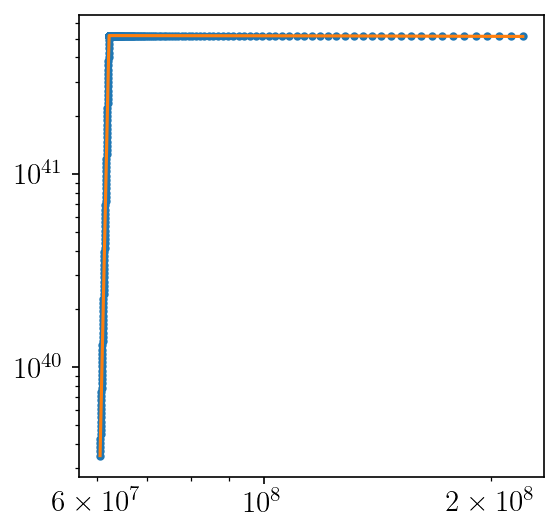

In [534]:
fig,ax = plt.subplots(1,1,figsize=(4,4), dpi = 150)

ax.plot(t_growth+t_merger+t_list, lum_list, '.');
ax.plot(t_growth+t_merger+t_list, lum_interp(t_growth+t_merger+t_list))
ax.set_xscale('log'); ax.set_yscale('log')